In [447]:
%load_ext autoreload
%autoreload 2
import pickle, numpy as np
import sys
import torch as t
sys.path.append("../../")
import matplotlib.pyplot as plt
from som.intopolate import weighted_log
from utils.number_handler import to_numeral
import glob
import seaborn as sns
import pandas as pd
import json
from evaluate_numeral_context import Evaluator

sns.set(style='darkgrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [385]:
filtered_dataset = pickle.load(open('build/data_filtered_0.05Bnotable.val.v2.pkl','rb'))
nc = pickle.load(open('../../data/wikipedia/preprocess0.05Bnotable/NumeralAsNumeral/nc.dat','rb'))
idx2word = pickle.load(open('../../data/wikipedia/preprocess0.05Bnotable/NumeralAsNumeral/idx2word.dat','rb'))
wc = pickle.load(open('../../data/wikipedia/preprocess0.05Bnotable/NumeralAsNumeral/wc.dat','rb'))
word2idx = pickle.load(open('../../data/wikipedia/preprocess0.05Bnotable/NumeralAsNumeral/word2idx.dat','rb'))
print(len(filtered_dataset))
print(filtered_dataset[:30])

# filtered_dataset = filter_oov(word2idx, filtered_dataset)
numerals = np.array([float(i[0]) for i in filtered_dataset])
print(len(filtered_dataset))
print(numerals)

wf = np.array([wc[word] for word in idx2word])
w_sum = wf.sum()
wf = wf / w_sum
wf = np.power(wf, 0.75)
wf = wf / wf.sum()
nf = np.array(list(nc.values()))
n_sum = nf.sum()
nf = nf / n_sum

100
[('1241.0', ['effective', 'lord', 'of', 'rome', 'from', 'when', 'he', 'defeated', 'the', 'imperial']), ('82000.0', ['of', 'regular', 'personnel', 'set', 'at', 'and', 'see', 'an', 'increase', 'in']), ('1097.0', ['forced', 'him', 'to', 'retreat', 'in', 'henry', 'withdrew', 'from', 'italy', 'altogether']), ('1732.0', ['then', 'called', 'consumption', 'in', 'july', 'about', 'two', 'weeks', 'before', 'john']), ('1276.0', ['actions', 'and', 'policies', 'on', 'march', 'pope', 'innocent', 'granted', 'to', 'king']), ('1562.0', ['sacked', 'by', 'the', 'huguenots', 'in', 'and', 'many', 'of', 'its', 'valuable']), ('25.3', ['retaining', 'wall', 'repairs', 'and', 'installation', 'million', 'project', 'airports', 'pittsburgh', 'international']), ('1939.0', ['houses', 'in', 'the', 'united', 'states', 'travel', 'bureau', 'specialized', 'in', 'accommodations']), ('1343.0', ['born', 'in', 'london', 'sometime', 'around', 'though', 'the', 'precise', 'date', 'and']), ('1816.0', ['the', 'french', 'ship',

In [387]:
show_ERROR = False

def filter_oov(word2idx, dataset):
    processed_dataset = []
    for pair in dataset:# get rid of pair where unknown or numeral at
        flag = 1
        for item in pair[1]:
            if item not in word2idx:
                flag = 0
        if flag == 1:
            processed_dataset.append(pair)
    return processed_dataset


def compute_mean_vec(idx2vec):
    vecs = []
    c_dict = {}
    for i in filtered_dataset:
        C = i[1]
        for c in C:
            if c not in c_dict:
                if c in word2idx:
                    vecs.append(idx2vec[word2idx[c]])
            else:
                c_dict[c] += 1
    
    mean_vec = np.array(vecs)
    print('Computing mean vectors, missing {} vectors'.format(len(filtered_dataset)*len(filtered_dataset[0][1]) - len(mean_vec)))
    return np.mean(mean_vec, axis=0)
    

In [428]:
# norms = None

def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def compute_norm_factor():
    # N x H
    # normalization factor for p(c_j|n_i)
    norms = np.zeros(numeral_embed_i.shape[0])
    c_dict = {}
    for i in filtered_dataset:
        C = i[1]
        for c in C:
            if c not in c_dict:
                try:
                    wordvec = idx2vec_o[word2idx[c]]
                except KeyError:
                    wordvec = mean_vec_o
                    
                score = np.dot(wordvec, np.array(numeral_embed_i).T) # N x 1 # remove the replicated c?
                norms += np.exp(score)
                c_dict[c] = 0
            else:
                c_dict[c] += 1
                
    return norms, c_dict

def compute_norm_factor_1():
    # N x H
    # normalization factor for p(c_j|n_i)
    mat = np.dot(idx2vec_o, np.array(numeral_embed_i).T)
    mat = np.exp(mat)
    norms = np.sum(mat, axis=0)
    
    return norms

def _get_score_0(i):
    
    s = np.zeros((len(numerals),))
    for c in i[1]:
        try:
            wordvec = idx2vec_o[word2idx[c]]
        except KeyError:
            wordvec = mean_vec_o
            
        score = np.dot(wordvec, np.array(numeral_embed_i).T)
        s += score
    score = s
    
    return score

# speed and caculation can be futher optimized
# also metrics
def _get_score_sg_0(i):
    
    s = np.zeros((len(numerals),))
    
    for c in i[1]:
        neg_vec = np.take(idx2vec_o, np.random.choice(100000, 20, p=wf, replace=True), axis=0)
        # (20 x 150)
        
        try:
            wordvec = idx2vec_o[word2idx[c]]
        except KeyError:
            wordvec = mean_vec_o
            
        score = np.log(sigmoid(np.dot(wordvec, np.array(numeral_embed_i).T)))
        score_1 = np.sum(np.log(sigmoid(-np.dot(neg_vec, np.array(numeral_embed_i).T))),axis=0)
        
        s += score
        s += score_1
        
    score = s
    
    return score

def _get_score_sg(i):
    
    s = np.zeros((len(numerals),))
    neg_vec = np.take(idx2vec_o, np.random.choice(100000, 20, p=wf, replace=True), axis=0)
    
    # (20 x 150)
    for c in i[1]:
        
        try:
            wordvec = idx2vec_o[word2idx[c]]
        except KeyError:
            wordvec = mean_vec_o
            
        score = np.log(sigmoid(np.dot(wordvec, np.array(numeral_embed_i).T)))
        score_1 = np.sum(np.log(sigmoid(-np.dot(neg_vec, np.array(numeral_embed_i).T))),axis=0)
        
        s += score
        s += score_1
        
    score = s
    
    return score

def _get_score_sg_1(i):
    
    s = np.zeros((len(numerals),))
    neg_vec = np.take(idx2vec_o, np.random.choice(100000, 20, p=wf, replace=True), axis=0)
    
    # (20 x 150)
    for c in i[1]:
        
        try:
            wordvec = idx2vec_o[word2idx[c]]
        except KeyError:
            wordvec = mean_vec_o
            
        score = np.log(sigmoid(np.dot(wordvec, np.array(numeral_embed_i).T)))
        score_1 = np.sum(np.log(sigmoid(-np.dot(neg_vec, np.array(numeral_embed_i).T))),axis=0)
        
        s += score
        s += score_1
        
        try:
            wordvec = idx2vec_i[word2idx[c]]
        except KeyError:
            wordvec = mean_vec_i
            
        score = np.dot(wordvec, np.array(numeral_embed_o).T)
        s += score
        
    score = s
    
    return score


def _get_score_1(i):
    
    s = np.zeros((len(numerals),))
    for c in i[1]:
        try:
            wordvec = idx2vec_o[word2idx[c]]
        except KeyError:
            wordvec = mean_vec_o
            
        score = np.dot(wordvec, np.array(numeral_embed_i).T)
        s += score
    score = s
    score -= len(i[1])* np.log(norms)
    return score

def _get_score_2(i):
    
    s = np.zeros((len(numerals),))
    for c in i[1]:
        try:
            wordvec = idx2vec_o[word2idx[c]]
        except KeyError:
            wordvec = mean_vec_o
            
        score = np.dot(wordvec, np.array(numeral_embed_i).T)
        s += score
        
        try:
            wordvec = idx2vec_i[word2idx[c]]
        except KeyError:
            wordvec = mean_vec_i
            
        score = np.dot(wordvec, np.array(numeral_embed_o).T)
        s += score
        
    score = s
    score -= len(i[1]) * np.log(norms)
    return score

def _get_score_3(i):
    
    s = np.zeros((len(numerals),))
    for c in i[1]:
        
        try:
            wordvec = idx2vec_i[word2idx[c]]
        except KeyError:
            wordvec = mean_vec_i
            
        score = np.dot(wordvec, np.array(numeral_embed_o).T)
        s += score
        
    score = s
    return score

def predict(score):
    
    pred_idx = np.argsort(score)[-1]
    reduplic = np.where(score == score[pred_idx])
#     print(len(reduplic))

    if len(reduplic) > 1:
        pred_idx = np.random.choice(reduplic)
        print('predict UNK_W, randomly choose a word')

    # random:
#     pred_idx = np.random.choice(len(score))
    
    pred = numerals[pred_idx]
    
    return pred

def evaluate(kbest, fn=_get_score_0):
    right = 0
    for i in filtered_dataset:
        
        score = fn(i)
        nn = np.argsort(score)[-kbest:]
        
        if float(i[0]) in numerals[nn]:
            right += 1
    return right/len(filtered_dataset)

def evaluate_RMSE(fn=_get_score_0):
    
    total_square_err = []
    
    for i in filtered_dataset:
        
        score = fn(i)
        
        pred = predict(score)
        
        total_square_err.append((float(i[0]) - pred)**2)
    
#     total_square_err = sorted(total_square_err)[:-3]
        
    RMSE = np.sqrt(np.mean(total_square_err))
    return RMSE
    
def evaluate_avg_rank(fn=_get_score_0):
    total_rank = 0
    for i in filtered_dataset:
        
        score = fn(i)
        nn = np.argsort(score)[::-1]
        
        rank = 0
        for k in numerals[nn]:
            rank += 1
            if k == float(i[0]):
                break
        
        total_rank += rank
        
    avg_rank = total_rank / len(filtered_dataset)
    return avg_rank




def evaluate_avg_mean_absolute_percent_err(fn=_get_score_0): # emmmm
    total_mape = []
    for i in filtered_dataset:
        
        score = fn(i)
        
        pred = predict(score)
    
        mape = abs((float(i[0]) - pred)/max(abs(float(i[0])), 1e-4))
                
        
        if mape > 1000 and show_ERROR:
            print(float(i[0]), pred, mape, fn)
        
        total_mape.append(mape)
        
#     total_mape = sorted(total_mape)[:-3]
        
    avg_mape = np.mean(total_mape)
    
    return avg_mape

def evaluate_avg_mean_absolute_err(fn=_get_score_0): # emmmm
    total_mae = []
    for i in filtered_dataset:
        
        score = fn(i)
        
        pred = predict(score)
        
        mae = abs((float(i[0]) - pred))
        
        if mae > 1000 and show_ERROR:
            print(float(i[0]), pred, mae, fn)
        
        total_mae.append(mae)
        
#     total_mae = sorted(total_mae)[:-3]
        
    avg_mape = np.mean(total_mae)
    
    return avg_mape

def evaluate_median_mean_absolute_percent_err(fn=_get_score_0): # emmmm
    total_mape = 0
    mape_list = []
    
    for i in filtered_dataset:
        
        score = fn(i)
        
        pred = predict(score)
        
        mape = abs((float(i[0]) - pred)/max(abs(float(i[0])), 1e-4))
        
        mape_list.append(mape)
  

    median_mape = np.median(mape_list)
#     print(sorted(mape_list))

    return median_mape


def evaluate_median_mean_absolute_err(fn=_get_score_0): # emmmm
    total_mape = 0
    mdae_list = []
    
    for i in filtered_dataset:
        
        score = fn(i)
        
        pred = predict(score)
        
        mdae = abs((float(i[0]) - pred))
        
        mdae_list.append(mdae)
    
    median_mdae = np.median(mdae_list)

    return median_mdae


def eval_res(mode='val'):
    
    assert mode in ['test', 'val']

    res = {}
    
    if mode == 'val':
        a = [1, 3, 10, 15, 25, 40, 50, 60, 80, 100]
    else:
        a = [3, 10, 15, 25, 40, 100, 150, 200, 250, 320]
        
    base_res = [i/len(filtered_dataset) for i in a]
    base_rank = 0.5*(len(filtered_dataset)+1)
    
    fn_s = [_get_score_0, _get_score_1, _get_score_2, _get_score_3]
    res['x'] = a
    res['topk'] = [base_res] + [[evaluate(i, fn) for i in a] for fn in fn_s]
    res['mape'] =  [evaluate_avg_mean_absolute_percent_err(fn) for fn in fn_s]
    res['mae'] =  [evaluate_avg_mean_absolute_err(fn) for fn in fn_s]
    res['mdae'] =  [evaluate_median_mean_absolute_err(fn) for fn in fn_s]
    res['mdape'] =  [evaluate_median_mean_absolute_percent_err(fn) for fn in fn_s]
    res['RMSE'] =  [evaluate_RMSE(fn) for fn in fn_s]
    res['avg_rank'] = [base_rank] + [evaluate_avg_rank(fn) for fn in fn_s]
    
    return res


def draw(res):
    f = 1
    topk_label = ['base', 'score0', 'score1', 'score2', 'score3']
    fig = plt.figure(f)
    fig.set_figheight(7)
    fig.set_figwidth(14)
    count = 1
    for k in list(res.keys()):
        plt.subplot(1, len(list(res.keys())), count)
        R = res[k]
        x = R['x']
        topk = R['topk']
        for i in range(len(topk)):
            plt.plot(x, topk[i], label=topk_label[i])
        plt.title(k)
        plt.legend(loc='upper left')
        count += 1
        
    plt.show()
    f += 1
    
    fig = plt.figure(f)
    fig.set_figheight(7)
    fig.set_figwidth(14)
    for i in range(4):
        plt.subplot(2,2,i+1)
        for k in list(res.keys()):
            R = res[k]
            x = R['x']
            topk = R['topk']
            plt.plot(x, topk[i+1], label=k)
        plt.title(topk_label[i+1])
        plt.legend(loc='upper left')
    plt.show()
    f += 1
    
    fig = plt.figure(f)
    fig.set_figheight(21)
    fig.set_figwidth(21)

    mape_data = []
    mdape_data = []
    mdae_data = []
    RMSE_data = []
    mae_data = []
    avg_rank_data = []
    for k in list(res.keys()):
        d = res[k]['mape']
        for j in range(len(d)):
            mape_data.append([float(d[j]),topk_label[1:][j],'mape',k])

        d = res[k]['mdape']
        for j in range(len(d)):
            mdape_data.append([float(d[j]),topk_label[1:][j],'mdape',k])

        d = res[k]['mdae']
        for j in range(len(d)):
            mdae_data.append([float(d[j]),topk_label[1:][j],'mdae',k])

        d = res[k]['mae']
        for j in range(len(d)):
            mae_data.append([float(d[j]),topk_label[1:][j],'mae',k])

        d = res[k]['RMSE']
        for j in range(len(d)):
            RMSE_data.append([float(d[j]),topk_label[1:][j],'RMSE',k])
            
        d = res[k]['avg_rank']
        lab = ['r',0,1,2,3]
        for j in range(len(d)):
            avg_rank_data.append([d[j],lab[j],'avg_rank',k])

    mae_data = pd.DataFrame(mae_data, columns=['val', 'score', 'scheme', 'type'])
    mdape_data = pd.DataFrame(mdape_data, columns=['val', 'score', 'scheme', 'type'])
    mdae_data = pd.DataFrame(mdae_data, columns=['val', 'score', 'scheme', 'type'])
    RMSE_data = pd.DataFrame(RMSE_data, columns=['val', 'score', 'scheme', 'type'])
    mape_data = pd.DataFrame(mape_data, columns=['val', 'score', 'scheme', 'type'])
    avg_rank_data = pd.DataFrame(avg_rank_data, columns=['val', 'score', 'scheme', 'type'])
    
    plt.subplot(3,2,1)
    sns.barplot(x='type', y='val', hue='score',data=mape_data)
    plt.title('MAPE')
    
    plt.subplot(3,2,2)
    sns.barplot(x='type', y='val', hue='score',data=mae_data)
    plt.title('MAE')
    
    plt.subplot(3,2,3)
    sns.barplot(x='type', y='val', hue='score',data=mdae_data)
    plt.title('MDAE')
    
    plt.subplot(3,2,4)
    sns.barplot(x='type', y='val', hue='score',data=mdape_data)
    plt.title('MDAPE')
    
    plt.subplot(3,2,5)
    sns.barplot(x='type', y='val', hue='score',data=RMSE_data)
    plt.title('RMSE')
    
    plt.subplot(3,2,6)
    sns.barplot(x='type', y='val', hue='score',data=avg_rank_data)
    plt.title('AVG_RANK')
    plt.show()

$$s(c_j|n_i) = {v_{c_j}^o}^T v_{n_i}^i$$
$$s(n_i|c_j) = {v_{n_i}^o}^T v_{c_j}^i$$
$$argmax_{n_i}\sum_j \log{[p(c_j|n_i)p(n_i|c_j)]}$$
$$\sum_j \log{[p(c_j|n_i)p(n_i|c_j)]} = \sum_j \log{p(c_j|n_i)}+\sum_j \log{p(n_i|c_j)}$$

one way to caculate
$$\sum_j \log{p(c_j|n_i)} = \sum_j \log{\frac{e^{s(c_j| n_i)}}{\sum_{c_k \in C} e^{s(c_k| n_i)}}} = \sum_j \log{\frac{e^{s(c_j| n_i)}}{Z(n_i)}} =  \sum_j s(c_j| n_i) - \sum_j \log{Z(n_i)}$$

another way skip gram:
$$\sum_j \log{p(c_j|n_i)} = \sum_j \log{\frac{e^{s(c_j| n_i)}}{\sum_{c_k \in C} e^{s(c_k| n_i)}}} \approx \sum_j \log{\frac{e^{s(c_j| n_i)}}{Z(n_i)}} =  \sum_j s(c_j| n_i) - \sum_j \log{Z(n_i)}$$

$$\sum_j \log{p(n_i|c_j)} = \sum_j \log{\frac{e^{s(n_i| c_j)}}{\sum_{n_k \in N} e^{s(n_k| c_j)}}} = \sum_j \log{\frac{e^{s(n_i| c_j)}}{Z(c_j)}} =  \sum_j s(n_i| c_j) - \sum_j \log{Z(c_j)} = \sum_j s(n_i| c_j) - Constant$$

## score 0: ignore normalization factor, and reverse prob
$$argmax_{n_i}\sum_j \log{[p(c_j|n_i)]} \approx argmax_{n_i} \sum_j s(c_j| n_i)$$

## score 1: ignore reverse prob
$$argmax_{n_i}\sum_j \log{[p(c_j|n_i)]} \approx argmax_{n_i} (\sum_j s(c_j |n_i) - \sum_j \log{Z(n_i)} )$$

## score 2
$$argmax_{n_i}\sum_j \log{[p(c_j|n_i)p(n_i|c_j)]} = argmax_{n_i} (\sum_j s(c_j| n_i) - \sum_j \log{Z(n_i)} + \sum_j s(n_i| c_j))$$

## score 3 only context predict numeral
$$argmax_{n_i}\sum_j \log{[p(n_i|c_j)]} = \sum_j s(n_i| c_j)$$

# Test for different number of prototypes

In [389]:
def get_numeral_embed_weights_batch(numerals,transformed_protp,alpha=1.0,fn=weighted_log):
    """
    :param numerals: tensor of numerals
    :return: weights matrix
    """
    # TODO: can we get a function that can easily be gpu_accelerated?
    numerals.apply_(fn)
    l_numerals = numerals.size()[0]
    l_prototypes = transformed_protp.size()[0]

    min_margin =  t.tensor(0.0001, dtype=t.float32)
    transformed_prototypes_batch = transformed_protp.expand(l_prototypes, l_numerals)
    prototype_weights = t.pow(1 / t.max(t.abs(transformed_prototypes_batch - numerals),min_margin), alpha)
    prototype_weights /= t.sum(prototype_weights, 0)
    
    return prototype_weights # [prototype_size x num_of_numerals]

Computing mean vectors, missing 20 vectors
Computing mean vectors, missing 20 vectors
Computing mean vectors, missing 20 vectors
Computing mean vectors, missing 20 vectors
Computing mean vectors, missing 20 vectors
Computing mean vectors, missing 20 vectors
Computing mean vectors, missing 20 vectors
Computing mean vectors, missing 20 vectors
Computing mean vectors, missing 20 vectors
Computing mean vectors, missing 20 vectors


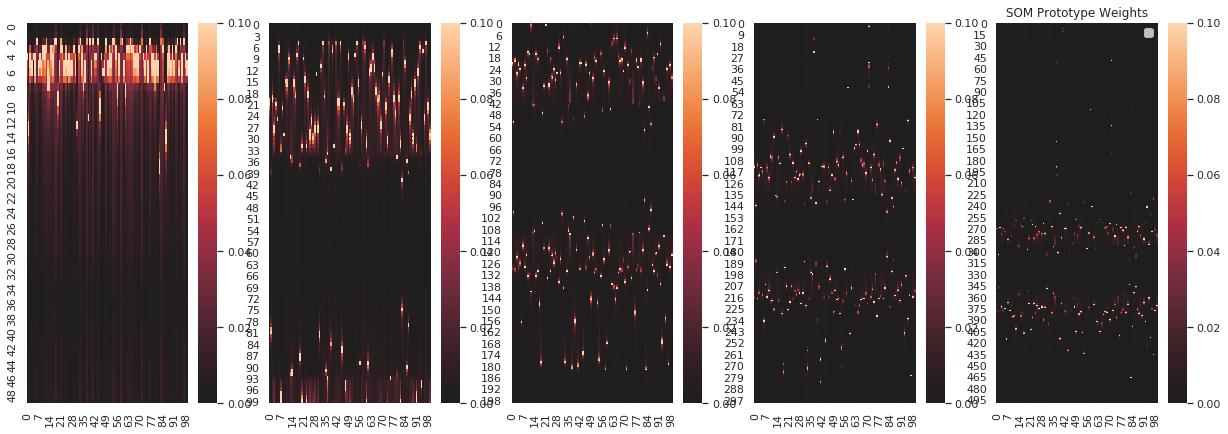

{'50': {'x': [1, 3, 10, 15, 25, 40, 50, 60, 80, 100], 'topk': [[0.01, 0.03, 0.1, 0.15, 0.25, 0.4, 0.5, 0.6, 0.8, 1.0], [0.04, 0.12, 0.28, 0.47, 0.64, 0.81, 0.87, 0.91, 0.97, 1.0], [0.06, 0.13, 0.35, 0.49, 0.65, 0.81, 0.85, 0.88, 0.94, 1.0], [0.03, 0.09, 0.29, 0.4, 0.56, 0.75, 0.81, 0.89, 0.96, 1.0], [0.01, 0.05, 0.22, 0.33, 0.48, 0.66, 0.79, 0.85, 0.94, 1.0]], 'mape': [121752.71412868629, 124953.27709883693, 209.965694668, 274.46312656173313], 'mae': [40490.84742, 28062.24908, 10554.224479999999, 8963.14204], 'mdae': [1753.8600000000001, 503.5, 598.85, 685.0], 'mdape': [0.9974057237409717, 0.642264422247359, 0.8061972996197162, 0.8554328142614231], 'RMSE': [113381.0734828911, 94008.03061428355, 49982.40020220432, 48183.31073986901], 'avg_rank': [50.5, 24.35, 25.39, 28.03, 32.37]}, '100': {'x': [1, 3, 10, 15, 25, 40, 50, 60, 80, 100], 'topk': [[0.01, 0.03, 0.1, 0.15, 0.25, 0.4, 0.5, 0.6, 0.8, 1.0], [0.04, 0.11, 0.36, 0.49, 0.67, 0.8, 0.87, 0.91, 0.96, 1.0], [0.04, 0.1, 0.5, 0.57, 0.69, 

In [392]:
prototype_size = ['50', '100', '200', '300', '500']
res = {}

fig = plt.figure(0)
fig.set_figheight(7)
fig.set_figwidth(21)
count = 1
for sz in prototype_size:
    
    idx2vec_o = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/prototypes/{}/idx2vec_o_epoch5.dat'.format(sz),'rb'))
    idx2vec_i = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/prototypes/{}/idx2vec_i_epoch5.dat'.format(sz),'rb'))
    trained_prototypes = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/prototypes/{}/trained_prototypes_epoch5.dat'.format(sz),'rb'))

    mean_vec_o = compute_mean_vec(idx2vec_o)
    mean_vec_i = compute_mean_vec(idx2vec_i)
    prototypes = trained_prototypes['prototypes']

    prototypes2vec_i = trained_prototypes['i_embedding']
    prototypes2vec_o = trained_prototypes['o_embedding']

    transformed_protp = t.tensor(t.from_numpy(prototypes), dtype=t.float32).apply_(weighted_log).view(-1,1)
    numerals = np.array([float(i[0]) for i in filtered_dataset])
    prototype_weights = get_numeral_embed_weights_batch(t.tensor(t.from_numpy(numerals),dtype=t.float),transformed_protp)
    numeral_embed_i = t.matmul(prototype_weights.transpose(0,1),t.from_numpy(prototypes2vec_i))
    numeral_embed_o = t.matmul(prototype_weights.transpose(0,1),t.from_numpy(prototypes2vec_o))

    plt.subplot(1, len(prototype_size), count)
    sns.heatmap(prototype_weights, vmin=0, vmax=.1, center=0, label=sz)
    norms, _ = compute_norm_factor()
#     norms = compute_norm_factor_1()    
    
    res[sz] = eval_res('val')
    count += 1

plt.legend('upper left')
plt.title('SOM Prototype Weights')    
plt.show()
print(res)
# draw(res)

with open('res_sz_val.v2.json','w') as f:
    f.write(str(res))

In [393]:
pd.DataFrame(res)

,50,100,200,300,500
RMSE,"[113381.0734828911, 94008.03061428355, 49982.4...","[53755.735298553795, 81114.8446651566, 48130.1...","[49865.61309448397, 67487.06488813259, 48120.7...","[47651.25878430585, 79957.06152949734, 48688.6...","[65193.07648543108, 65813.03549000448, 48016.2..."
avg_rank,"[50.5, 24.35, 25.39, 28.03, 32.37]","[50.5, 23.87, 24.01, 27.57, 31.79]","[50.5, 22.62, 23.49, 26.82, 32.8]","[50.5, 20.81, 22.5, 25.63, 32.04]","[50.5, 22.84, 24.31, 27.05, 32.8]"
mae,"[40490.84742, 28062.24908, 10554.224479999999,...","[13900.20264, 20386.871379999997, 8789.5550400...","[12873.010119999999, 15983.073379999998, 8976....","[9292.90752, 18668.296779999997, 9576.44384, 9...","[13445.140120000002, 14096.34892, 8662.6155399..."
mape,"[121752.71412868629, 124953.27709883693, 209.9...","[1688.7642838803877, 114251.32774709881, 67.45...","[510.5610621544114, 392.2532663429662, 72.3845...","[1226.754559544872, 86.23826238220016, 72.7438...","[1416.246277997811, 349.3371136925987, 70.7510..."
mdae,"[1753.8600000000001, 503.5, 598.85, 685.0]","[1330.5, 311.5, 569.0, 834.5]","[196.0, 266.5, 534.45, 803.5]","[1493.77, 260.5, 549.45, 904.45]","[274.0, 214.0, 526.0, 550.45]"
mdape,"[0.9974057237409717, 0.642264422247359, 0.8061...","[0.8613228938467428, 0.5713732394366198, 0.892...","[0.49352357299820204, 0.6735664134412016, 0.96...","[0.8748962010549808, 0.5133477667215323, 0.963...","[0.596055013287687, 0.5941524041196893, 0.8989..."
topk,"[[0.01, 0.03, 0.1, 0.15, 0.25, 0.4, 0.5, 0.6, ...","[[0.01, 0.03, 0.1, 0.15, 0.25, 0.4, 0.5, 0.6, ...","[[0.01, 0.03, 0.1, 0.15, 0.25, 0.4, 0.5, 0.6, ...","[[0.01, 0.03, 0.1, 0.15, 0.25, 0.4, 0.5, 0.6, ...","[[0.01, 0.03, 0.1, 0.15, 0.25, 0.4, 0.5, 0.6, ..."
x,"[1, 3, 10, 15, 25, 40, 50, 60, 80, 100]","[1, 3, 10, 15, 25, 40, 50, 60, 80, 100]","[1, 3, 10, 15, 25, 40, 50, 60, 80, 100]","[1, 3, 10, 15, 25, 40, 50, 60, 80, 100]","[1, 3, 10, 15, 25, 40, 50, 60, 80, 100]"


In [394]:
print(pd.DataFrame(res))

                                                         50  \
RMSE      [113381.0734828911, 94008.03061428355, 49982.4...   
avg_rank                 [50.5, 24.35, 25.39, 28.03, 32.37]   
mae       [40490.84742, 28062.24908, 10554.224479999999,...   
mape      [121752.71412868629, 124953.27709883693, 209.9...   
mdae             [1753.8600000000001, 503.5, 598.85, 685.0]   
mdape     [0.9974057237409717, 0.642264422247359, 0.8061...   
topk      [[0.01, 0.03, 0.1, 0.15, 0.25, 0.4, 0.5, 0.6, ...   
x                   [1, 3, 10, 15, 25, 40, 50, 60, 80, 100]   

                                                        100  \
RMSE      [53755.735298553795, 81114.8446651566, 48130.1...   
avg_rank                 [50.5, 23.87, 24.01, 27.57, 31.79]   
mae       [13900.20264, 20386.871379999997, 8789.5550400...   
mape      [1688.7642838803877, 114251.32774709881, 67.45...   
mdae                          [1330.5, 311.5, 569.0, 834.5]   
mdape     [0.8613228938467428, 0.5713732394366198, 0.8

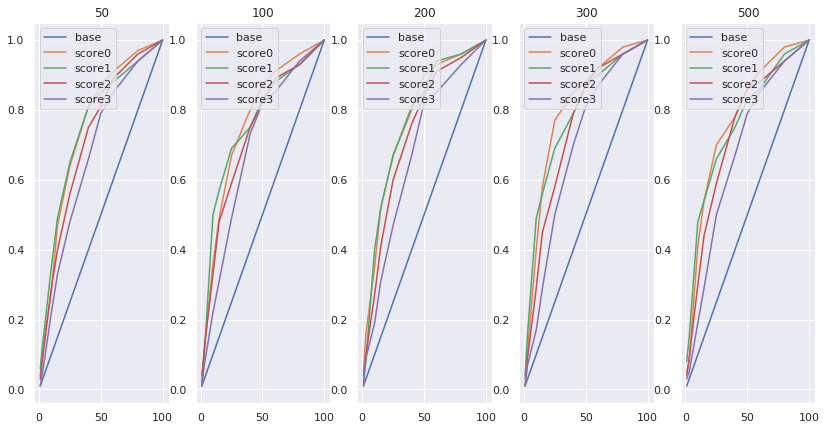

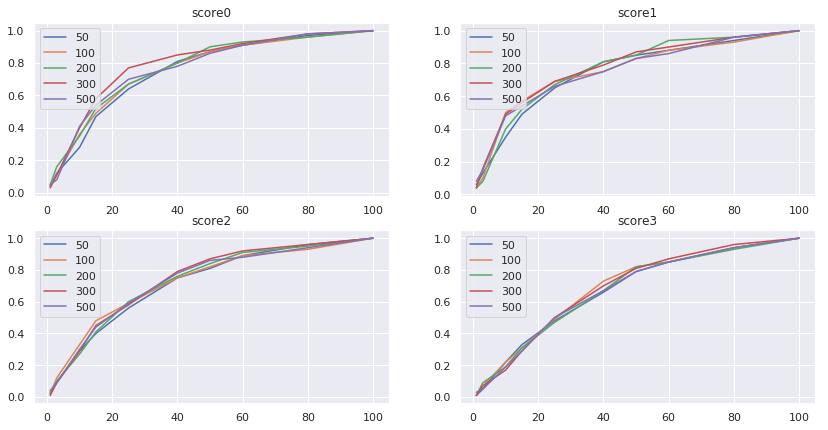

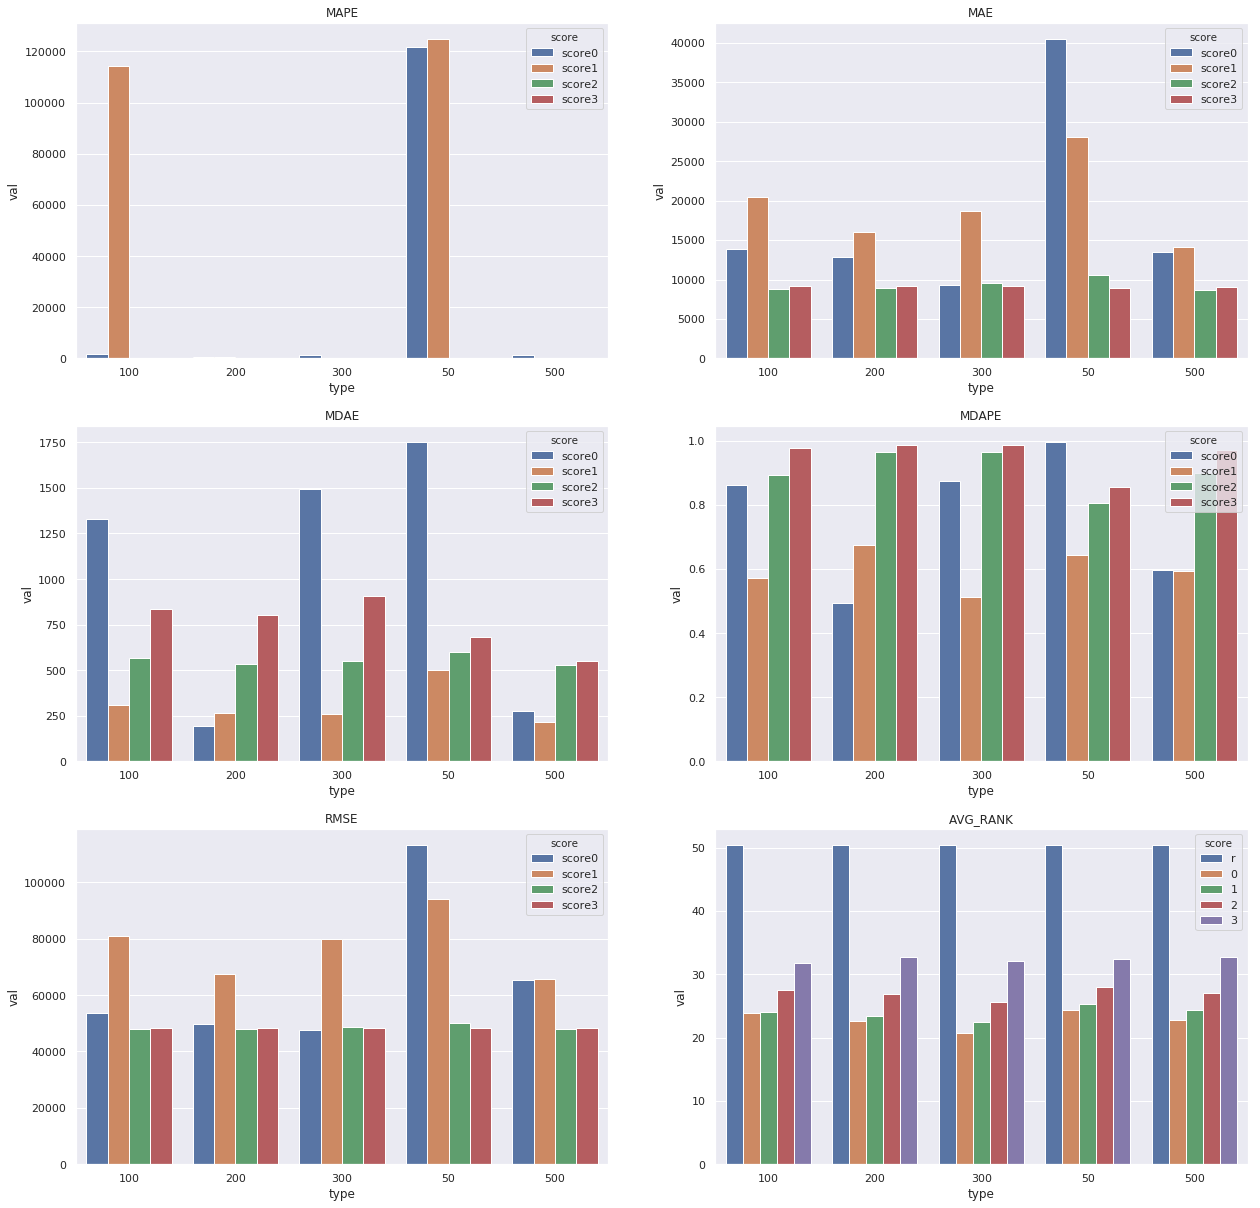

In [395]:
draw(res)

Computing mean vectors, missing 48 vectors
Computing mean vectors, missing 48 vectors
19.1 50171.0 2625.7539267015704 <function _get_score_0 at 0x7fe42abdfa60>
1637.0 3850000.0 2350.8631643249846 <function _get_score_0 at 0x7fe42abdfa60>
2930.0 490000000.0 167234.4948805461 <function _get_score_0 at 0x7fe42abdfa60>
3.14 75000.0 23884.350318471337 <function _get_score_0 at 0x7fe42abdfa60>
127.0 1022000.0 8046.244094488189 <function _get_score_0 at 0x7fe42abdfa60>
0.7179 27000.0 37608.69494358546 <function _get_score_0 at 0x7fe42abdfa60>
0.83 1561.0 1879.7228915662652 <function _get_score_0 at 0x7fe42abdfa60>
0.9995 3680.0 3680.84092046023 <function _get_score_0 at 0x7fe42abdfa60>
0.2 1041.0 5203.999999999999 <function _get_score_0 at 0x7fe42abdfa60>
81.0 213000.0 2628.6296296296296 <function _get_score_0 at 0x7fe42abdfa60>
362.0 3850000.0 10634.3591160221 <function _get_score_0 at 0x7fe42abdfa60>
0.15 2930.0 19532.333333333332 <function _get_score_0 at 0x7fe42abdfa60>
1494.0 12970479.0 

27000.0 487.0 26513.0 <function _get_score_0 at 0x7fe42abdfa60>
1852.0 75.9 1776.1 <function _get_score_0 at 0x7fe42abdfa60>
1807.0 42.0 1765.0 <function _get_score_0 at 0x7fe42abdfa60>
3183.0 1191.0 1992.0 <function _get_score_0 at 0x7fe42abdfa60>
1832.0 0.0833 1831.9167 <function _get_score_0 at 0x7fe42abdfa60>
1825.0 75.9 1749.1 <function _get_score_0 at 0x7fe42abdfa60>
2600.0 4.08 2595.92 <function _get_score_0 at 0x7fe42abdfa60>
1755.0 196670.0 194915.0 <function _get_score_0 at 0x7fe42abdfa60>
54.0 1275.0 1221.0 <function _get_score_0 at 0x7fe42abdfa60>
278.0 1814.0 1536.0 <function _get_score_0 at 0x7fe42abdfa60>
10.1 1909.0 1898.9 <function _get_score_0 at 0x7fe42abdfa60>
101325.0 90.0 101235.0 <function _get_score_0 at 0x7fe42abdfa60>
1158.0 16.3 1141.7 <function _get_score_0 at 0x7fe42abdfa60>
8.05 1645.0 1636.95 <function _get_score_0 at 0x7fe42abdfa60>
1255.0 4.8 1250.2 <function _get_score_0 at 0x7fe42abdfa60>
1647.0 389.0 1258.0 <function _get_score_0 at 0x7fe42abdfa60>
8

1687.0 14000.0 12313.0 <function _get_score_0 at 0x7fe42abdfa60>
5.54 2014.0 2008.46 <function _get_score_0 at 0x7fe42abdfa60>
1620.0 22.5 1597.5 <function _get_score_0 at 0x7fe42abdfa60>
0.5538 1379.0 1378.4462 <function _get_score_0 at 0x7fe42abdfa60>
5.7 6600.0 6594.3 <function _get_score_0 at 0x7fe42abdfa60>
1830.0 31395.0 29565.0 <function _get_score_0 at 0x7fe42abdfa60>
1251.0 20.5 1230.5 <function _get_score_0 at 0x7fe42abdfa60>
1663.0 496.0 1167.0 <function _get_score_0 at 0x7fe42abdfa60>
34.2 196670.0 196635.8 <function _get_score_0 at 0x7fe42abdfa60>
23.0 1280.0 1257.0 <function _get_score_0 at 0x7fe42abdfa60>
5.9 1700.0 1694.1 <function _get_score_0 at 0x7fe42abdfa60>
1643.0 4500.0 2857.0 <function _get_score_0 at 0x7fe42abdfa60>
46000.0 1874.0 44126.0 <function _get_score_0 at 0x7fe42abdfa60>
75000.0 166000.0 91000.0 <function _get_score_0 at 0x7fe42abdfa60>
1030.0 4760.0 3730.0 <function _get_score_0 at 0x7fe42abdfa60>
2.376 12970479.0 12970476.624 <function _get_score_0 a

145.0 264000.0 263855.0 <function _get_score_1 at 0x7fe42abdfae8>
10.9 1240.0 1229.1 <function _get_score_1 at 0x7fe42abdfae8>
507.5 1808.0 1300.5 <function _get_score_1 at 0x7fe42abdfae8>
1275.0 1022000.0 1020725.0 <function _get_score_1 at 0x7fe42abdfae8>
1698.0 9.9 1688.1 <function _get_score_1 at 0x7fe42abdfae8>
395.0 1554.0 1159.0 <function _get_score_1 at 0x7fe42abdfae8>
220444.0 0.5538 220443.4462 <function _get_score_1 at 0x7fe42abdfae8>
893.0 1914.0 1021.0 <function _get_score_1 at 0x7fe42abdfae8>
40000.0 200.0 39800.0 <function _get_score_1 at 0x7fe42abdfae8>
1238.0 210.0 1028.0 <function _get_score_1 at 0x7fe42abdfae8>
399.0 1850.0 1451.0 <function _get_score_1 at 0x7fe42abdfae8>
600000.0 31395.0 568605.0 <function _get_score_1 at 0x7fe42abdfae8>
1772.0 40000.0 38228.0 <function _get_score_1 at 0x7fe42abdfae8>
1850.0 794.0 1056.0 <function _get_score_1 at 0x7fe42abdfae8>
490000000.0 54.0 489999946.0 <function _get_score_1 at 0x7fe42abdfae8>
264000.0 270.0 263730.0 <function 

1644.0 3.14 1640.86 <function _get_score_2 at 0x7fe42a279e18>
1177.0 8.05 1168.95 <function _get_score_2 at 0x7fe42a279e18>
14000.0 1945.0 12055.0 <function _get_score_2 at 0x7fe42a279e18>
6958.0 0.95 6957.05 <function _get_score_2 at 0x7fe42a279e18>
1531.0 475.0 1056.0 <function _get_score_2 at 0x7fe42a279e18>
1390.0 307.0 1083.0 <function _get_score_2 at 0x7fe42a279e18>
45.8 1933.0 1887.2 <function _get_score_2 at 0x7fe42a279e18>
182000.0 0.9995 181999.0005 <function _get_score_2 at 0x7fe42a279e18>
2930.0 0.5538 2929.4462 <function _get_score_2 at 0x7fe42a279e18>
4.1 1026.0 1021.9 <function _get_score_2 at 0x7fe42a279e18>
3.14 1012.0 1008.86 <function _get_score_2 at 0x7fe42a279e18>
27000.0 1756.0 25244.0 <function _get_score_2 at 0x7fe42a279e18>
1852.0 6958.0 5106.0 <function _get_score_2 at 0x7fe42a279e18>
3183.0 386.0 2797.0 <function _get_score_2 at 0x7fe42a279e18>
44.6 1916.0 1871.4 <function _get_score_2 at 0x7fe42a279e18>
1832.0 2930.0 1098.0 <function _get_score_2 at 0x7fe42a

50171.0 1002.0 49169.0 <function _get_score_2 at 0x7fe42a279e18>
1909.0 1.83 1907.17 <function _get_score_2 at 0x7fe42a279e18>
1951.0 9.9 1941.1 <function _get_score_2 at 0x7fe42a279e18>
1400.0 46354.0 44954.0 <function _get_score_2 at 0x7fe42a279e18>
860000.0 22.5 859977.5 <function _get_score_2 at 0x7fe42a279e18>
0.0833 1409.0 1408.9167 <function _get_score_2 at 0x7fe42a279e18>
1552.0 378.0 1174.0 <function _get_score_2 at 0x7fe42a279e18>
361.0 1733.0 1372.0 <function _get_score_2 at 0x7fe42a279e18>
1716.0 545.0 1171.0 <function _get_score_2 at 0x7fe42a279e18>
196670.0 1647.0 195023.0 <function _get_score_2 at 0x7fe42a279e18>
5700.0 1689.0 4011.0 <function _get_score_2 at 0x7fe42a279e18>
11.16 4760.0 4748.84 <function _get_score_2 at 0x7fe42a279e18>
1625.0 3.14 1621.86 <function _get_score_2 at 0x7fe42a279e18>
1808.0 270.0 1538.0 <function _get_score_2 at 0x7fe42a279e18>
794.0 264000.0 263206.0 <function _get_score_2 at 0x7fe42a279e18>
251.0 1409.0 1158.0 <function _get_score_2 at 0x

1922.0 374000.0 372078.0 <function _get_score_3 at 0x7fe42c5e8488>
1517.0 290.0 1227.0 <function _get_score_3 at 0x7fe42c5e8488>
451.0 1604.0 1153.0 <function _get_score_3 at 0x7fe42c5e8488>
200000.0 2600.0 197400.0 <function _get_score_3 at 0x7fe42c5e8488>
1672.0 432.0 1240.0 <function _get_score_3 at 0x7fe42c5e8488>
1743.0 161.0 1582.0 <function _get_score_3 at 0x7fe42c5e8488>
1098.0 20.5 1077.5 <function _get_score_3 at 0x7fe42c5e8488>
713.0 1972.0 1259.0 <function _get_score_3 at 0x7fe42c5e8488>
479.0 3680.0 3201.0 <function _get_score_3 at 0x7fe42c5e8488>
1689.0 568.0 1121.0 <function _get_score_3 at 0x7fe42c5e8488>
90000.0 1584.0 88416.0 <function _get_score_3 at 0x7fe42c5e8488>
1733.0 270.0 1463.0 <function _get_score_3 at 0x7fe42c5e8488>
1.6 1645.0 1643.4 <function _get_score_3 at 0x7fe42c5e8488>
166.0 1643.0 1477.0 <function _get_score_3 at 0x7fe42c5e8488>
374000.0 90.0 373910.0 <function _get_score_3 at 0x7fe42c5e8488>
307.0 1547.0 1240.0 <function _get_score_3 at 0x7fe42c5e8

0.1429 1248.0 8732.379986004198 <function _get_score_0 at 0x7fe42abdfa60>
19.5 149031.0 7641.615384615385 <function _get_score_0 at 0x7fe42abdfa60>
10.9 11108.0 1018.0825688073395 <function _get_score_0 at 0x7fe42abdfa60>
34.7 144000.0 4148.85590778098 <function _get_score_0 at 0x7fe42abdfa60>
0.9998 166000.0 166032.20664132826 <function _get_score_0 at 0x7fe42abdfa60>
0.0833 750.0 9002.60144057623 <function _get_score_0 at 0x7fe42abdfa60>
0.95 50171.0 52810.57894736843 <function _get_score_0 at 0x7fe42abdfa60>
0.5538 1743.0 3146.3456121343447 <function _get_score_0 at 0x7fe42abdfa60>
5.7 374000.0 65613.0350877193 <function _get_score_0 at 0x7fe42abdfa60>
0.0028 9.82 3506.142857142857 <function _get_score_0 at 0x7fe42abdfa60>
0.0537 1743.0 32457.100558659222 <function _get_score_0 at 0x7fe42abdfa60>
2.376 53000.0 22305.39730639731 <function _get_score_0 at 0x7fe42abdfa60>
83.0 374000.0 4505.024096385542 <function _get_score_1 at 0x7fe42abdfae8>
49.0 374000.0 7631.65306122449 <function 

545.0 1922.0 1377.0 <function _get_score_0 at 0x7fe42abdfa60>
20.5 1500.0 1479.5 <function _get_score_0 at 0x7fe42abdfa60>
1009.0 0.9995 1008.0005 <function _get_score_0 at 0x7fe42abdfa60>
45.8 156922.0 156876.2 <function _get_score_0 at 0x7fe42abdfa60>
182000.0 936.0 181064.0 <function _get_score_0 at 0x7fe42abdfa60>
1887.0 10.9 1876.1 <function _get_score_0 at 0x7fe42abdfa60>
4.1 6958.0 6953.9 <function _get_score_0 at 0x7fe42abdfa60>
1446.0 27000.0 25554.0 <function _get_score_0 at 0x7fe42abdfa60>
27000.0 1643.0 25357.0 <function _get_score_0 at 0x7fe42abdfa60>
1852.0 850000.0 848148.0 <function _get_score_0 at 0x7fe42abdfa60>
1807.0 49.2 1757.8 <function _get_score_0 at 0x7fe42abdfa60>
3183.0 1645.0 1538.0 <function _get_score_0 at 0x7fe42abdfa60>
1832.0 3850000.0 3848168.0 <function _get_score_0 at 0x7fe42abdfa60>
1825.0 374000.0 372175.0 <function _get_score_0 at 0x7fe42abdfa60>
2600.0 10.9 2589.1 <function _get_score_0 at 0x7fe42abdfa60>
1755.0 0.95 1754.05 <function _get_score_

1707.0 6500.0 4793.0 <function _get_score_0 at 0x7fe42abdfa60>
1212.0 75.6 1136.4 <function _get_score_0 at 0x7fe42abdfa60>
60000.0 1830.0 58170.0 <function _get_score_0 at 0x7fe42abdfa60>
4250.0 1195.0 3055.0 <function _get_score_0 at 0x7fe42abdfa60>
137.0 1972.0 1835.0 <function _get_score_0 at 0x7fe42abdfa60>
1586.0 3183.0 1597.0 <function _get_score_0 at 0x7fe42abdfa60>
0.9998 200000.0 199999.0002 <function _get_score_0 at 0x7fe42abdfa60>
219.0 200000.0 199781.0 <function _get_score_0 at 0x7fe42abdfa60>
43.0 1379.0 1336.0 <function _get_score_0 at 0x7fe42abdfa60>
151.0 31395.0 31244.0 <function _get_score_0 at 0x7fe42abdfa60>
1195.0 49.0 1146.0 <function _get_score_0 at 0x7fe42abdfa60>
1409.0 264000.0 262591.0 <function _get_score_0 at 0x7fe42abdfa60>
1659.0 90.0 1569.0 <function _get_score_0 at 0x7fe42abdfa60>
50171.0 502.0 49669.0 <function _get_score_0 at 0x7fe42abdfa60>
1555.0 132.0 1423.0 <function _get_score_0 at 0x7fe42abdfa60>
860000.0 0.0028 859999.9972 <function _get_scor

21.0 7400.0 7379.0 <function _get_score_1 at 0x7fe42abdfae8>
1634.0 550.0 1084.0 <function _get_score_1 at 0x7fe42abdfae8>
200.0 1945.0 1745.0 <function _get_score_1 at 0x7fe42abdfae8>
1922.0 303.0 1619.0 <function _get_score_1 at 0x7fe42abdfae8>
200000.0 83.0 199917.0 <function _get_score_1 at 0x7fe42abdfae8>
1737.0 475.0 1262.0 <function _get_score_1 at 0x7fe42abdfae8>
265.0 1266.0 1001.0 <function _get_score_1 at 0x7fe42abdfae8>
1688.0 314.0 1374.0 <function _get_score_1 at 0x7fe42abdfae8>
1672.0 314.0 1358.0 <function _get_score_1 at 0x7fe42abdfae8>
1111.0 6852.0 5741.0 <function _get_score_1 at 0x7fe42abdfae8>
1743.0 6600.0 4857.0 <function _get_score_1 at 0x7fe42abdfae8>
713.0 46354.0 45641.0 <function _get_score_1 at 0x7fe42abdfae8>
1689.0 150.0 1539.0 <function _get_score_1 at 0x7fe42abdfae8>
90000.0 713.0 89287.0 <function _get_score_1 at 0x7fe42abdfae8>
2400.0 5.7 2394.3 <function _get_score_1 at 0x7fe42abdfae8>
1733.0 504.0 1229.0 <function _get_score_1 at 0x7fe42abdfae8>
18

1785.0 127.0 1658.0 <function _get_score_2 at 0x7fe42a279e18>
3.9 1848.0 1844.1 <function _get_score_2 at 0x7fe42a279e18>
1700.0 575.0 1125.0 <function _get_score_2 at 0x7fe42a279e18>
1253.0 48.0 1205.0 <function _get_score_2 at 0x7fe42a279e18>
1265.0 14000.0 12735.0 <function _get_score_2 at 0x7fe42a279e18>
1930.0 53000.0 51070.0 <function _get_score_2 at 0x7fe42a279e18>
127.0 166000.0 165873.0 <function _get_score_2 at 0x7fe42a279e18>
27.1 1756.0 1728.9 <function _get_score_2 at 0x7fe42a279e18>
101325.0 893.0 100432.0 <function _get_score_2 at 0x7fe42a279e18>
0.7179 38400.0 38399.2821 <function _get_score_2 at 0x7fe42a279e18>
475.0 1580.0 1105.0 <function _get_score_2 at 0x7fe42a279e18>
1158.0 30.6 1127.4 <function _get_score_2 at 0x7fe42a279e18>
8.05 1208268.0 1208259.95 <function _get_score_2 at 0x7fe42a279e18>
27.5 1702.0 1674.5 <function _get_score_2 at 0x7fe42a279e18>
57.5 1814.0 1756.5 <function _get_score_2 at 0x7fe42a279e18>
1645.0 166000.0 164355.0 <function _get_score_2 at 

794.0 6600.0 5806.0 <function _get_score_2 at 0x7fe42a279e18>
1122.0 76.0 1046.0 <function _get_score_2 at 0x7fe42a279e18>
1641.0 27000.0 25359.0 <function _get_score_2 at 0x7fe42a279e18>
6500.0 200.0 6300.0 <function _get_score_2 at 0x7fe42a279e18>
6600.0 27000.0 20400.0 <function _get_score_2 at 0x7fe42a279e18>
5.54 5700.0 5694.46 <function _get_score_2 at 0x7fe42a279e18>
1604.0 1.0025 1602.9975 <function _get_score_2 at 0x7fe42a279e18>
682.0 1763.0 1081.0 <function _get_score_2 at 0x7fe42a279e18>
0.5538 1229.0 1228.4462 <function _get_score_2 at 0x7fe42a279e18>
5.7 220444.0 220438.3 <function _get_score_2 at 0x7fe42a279e18>
1251.0 9.0 1242.0 <function _get_score_2 at 0x7fe42a279e18>
1663.0 2930.0 1267.0 <function _get_score_2 at 0x7fe42a279e18>
34.2 1850.0 1815.8 <function _get_score_2 at 0x7fe42a279e18>
370.0 1446.0 1076.0 <function _get_score_2 at 0x7fe42a279e18>
568.0 1967.0 1399.0 <function _get_score_2 at 0x7fe42a279e18>
210.0 40000.0 39790.0 <function _get_score_2 at 0x7fe42a2

220444.0 1763.0 218681.0 <function _get_score_3 at 0x7fe42c5e8488>
1537.0 222555.0 221018.0 <function _get_score_3 at 0x7fe42c5e8488>
290.0 30069.0 29779.0 <function _get_score_3 at 0x7fe42c5e8488>
40000.0 1178.0 38822.0 <function _get_score_3 at 0x7fe42c5e8488>
42.0 1098.0 1056.0 <function _get_score_3 at 0x7fe42c5e8488>
5.23 213000.0 212994.77 <function _get_score_3 at 0x7fe42c5e8488>
399.0 1500.0 1101.0 <function _get_score_3 at 0x7fe42c5e8488>
600000.0 1446.0 598554.0 <function _get_score_3 at 0x7fe42c5e8488>
1850.0 303.0 1547.0 <function _get_score_3 at 0x7fe42c5e8488>
490000000.0 166000.0 489834000.0 <function _get_score_3 at 0x7fe42c5e8488>
264000.0 11.2 263988.8 <function _get_score_3 at 0x7fe42c5e8488>
1607.0 217.0 1390.0 <function _get_score_3 at 0x7fe42c5e8488>
11108.0 386.0 10722.0 <function _get_score_3 at 0x7fe42c5e8488>
1990.0 165.0 1825.0 <function _get_score_3 at 0x7fe42c5e8488>
1828.0 0.15 1827.85 <function _get_score_3 at 0x7fe42c5e8488>
378.0 282606.0 282228.0 <func

0.95 1785.0 1877.9473684210527 <function _get_score_1 at 0x7fe42abdfae8>
0.5538 575.0 1037.2809678584326 <function _get_score_1 at 0x7fe42abdfae8>
0.0028 1561.0 557499.0 <function _get_score_1 at 0x7fe42abdfae8>
19.1 12970479.0 679081.6701570681 <function _get_score_2 at 0x7fe42a279e18>
303.0 850000.0 2804.2805280528055 <function _get_score_2 at 0x7fe42a279e18>
0.7179 1162.0 1617.6098342387518 <function _get_score_2 at 0x7fe42a279e18>
57.5 1022000.0 17772.91304347826 <function _get_score_2 at 0x7fe42a279e18>
0.83 1604.0 1931.530120481928 <function _get_score_2 at 0x7fe42a279e18>
0.9995 1643.0 1642.8219109554777 <function _get_score_2 at 0x7fe42a279e18>
0.2 314.0 1569.0 <function _get_score_2 at 0x7fe42a279e18>
90.0 3850000.0 42776.77777777778 <function _get_score_2 at 0x7fe42a279e18>
0.15 155.0 1032.3333333333333 <function _get_score_2 at 0x7fe42a279e18>
1973.0 3850000.0 1950.3431322858592 <function _get_score_2 at 0x7fe42a279e18>
0.5538 936.0 1689.1408450704225 <function _get_score_2 

1733.0 10.9 1722.1 <function _get_score_0 at 0x7fe42abdfa60>
1.6 1191.0 1189.4 <function _get_score_0 at 0x7fe42abdfa60>
189.0 1972.0 1783.0 <function _get_score_0 at 0x7fe42abdfa60>
76.0 1972.0 1896.0 <function _get_score_0 at 0x7fe42abdfa60>
1622.0 60000.0 58378.0 <function _get_score_0 at 0x7fe42abdfa60>
1460.0 196670.0 195210.0 <function _get_score_0 at 0x7fe42abdfa60>
1237.0 144000.0 142763.0 <function _get_score_0 at 0x7fe42abdfa60>
620.0 1951.0 1331.0 <function _get_score_0 at 0x7fe42abdfa60>
165.0 490000000.0 489999835.0 <function _get_score_0 at 0x7fe42abdfa60>
374000.0 1990.0 372010.0 <function _get_score_0 at 0x7fe42abdfa60>
2040.0 55.4 1984.6 <function _get_score_0 at 0x7fe42abdfa60>
166000.0 0.95 165999.05 <function _get_score_0 at 0x7fe42abdfa60>
72.4 4000.0 3927.6 <function _get_score_0 at 0x7fe42abdfa60>
6338.0 1876.0 4462.0 <function _get_score_0 at 0x7fe42abdfa60>
3.49 1030.0 1026.51 <function _get_score_0 at 0x7fe42abdfa60>
1584.0 27.1 1556.9 <function _get_score_0 a

850000.0 220444.0 629556.0 <function _get_score_1 at 0x7fe42abdfae8>
1644.0 504.0 1140.0 <function _get_score_1 at 0x7fe42abdfae8>
1177.0 0.1429 1176.8571 <function _get_score_1 at 0x7fe42abdfae8>
14000.0 1002.0 12998.0 <function _get_score_1 at 0x7fe42abdfae8>
6958.0 3680.0 3278.0 <function _get_score_1 at 0x7fe42abdfae8>
1531.0 10.1 1520.9 <function _get_score_1 at 0x7fe42abdfae8>
20.5 1943.0 1922.5 <function _get_score_1 at 0x7fe42abdfae8>
1390.0 200.0 1190.0 <function _get_score_1 at 0x7fe42abdfae8>
1747.0 46354.0 44607.0 <function _get_score_1 at 0x7fe42abdfae8>
45.8 30069.0 30023.2 <function _get_score_1 at 0x7fe42abdfae8>
182000.0 1689.0 180311.0 <function _get_score_1 at 0x7fe42abdfae8>
2930.0 1098.0 1832.0 <function _get_score_1 at 0x7fe42abdfae8>
1887.0 809.0 1078.0 <function _get_score_1 at 0x7fe42abdfae8>
4.1 101325.0 101320.9 <function _get_score_1 at 0x7fe42abdfae8>
1446.0 2.2 1443.8 <function _get_score_1 at 0x7fe42abdfae8>
27000.0 14.0 26986.0 <function _get_score_1 at 

902.0 6958.0 6056.0 <function _get_score_1 at 0x7fe42abdfae8>
1620.0 166.0 1454.0 <function _get_score_1 at 0x7fe42abdfae8>
682.0 1936.0 1254.0 <function _get_score_1 at 0x7fe42abdfae8>
5.7 1300.0 1294.3 <function _get_score_1 at 0x7fe42abdfae8>
1251.0 11.2 1239.8 <function _get_score_1 at 0x7fe42abdfae8>
1663.0 307.0 1356.0 <function _get_score_1 at 0x7fe42abdfae8>
370.0 1733.0 1363.0 <function _get_score_1 at 0x7fe42abdfae8>
0.0028 1580.0 1579.9972 <function _get_score_1 at 0x7fe42abdfae8>
502.0 1584.0 1082.0 <function _get_score_1 at 0x7fe42abdfae8>
23.0 1785.0 1762.0 <function _get_score_1 at 0x7fe42abdfae8>
1140.0 374000.0 372860.0 <function _get_score_1 at 0x7fe42abdfae8>
0.0537 1814.0 1813.9463 <function _get_score_1 at 0x7fe42abdfae8>
46000.0 9.82 45990.18 <function _get_score_1 at 0x7fe42abdfae8>
75000.0 57.5 74942.5 <function _get_score_1 at 0x7fe42abdfae8>
1779.0 20.6 1758.4 <function _get_score_1 at 0x7fe42abdfae8>
120.0 1945.0 1825.0 <function _get_score_1 at 0x7fe42abdfae

90000.0 5.54 89994.46 <function _get_score_2 at 0x7fe42a279e18>
1.6 1237.0 1235.4 <function _get_score_2 at 0x7fe42a279e18>
166.0 90000.0 89834.0 <function _get_score_2 at 0x7fe42a279e18>
76.0 1022000.0 1021924.0 <function _get_score_2 at 0x7fe42a279e18>
1622.0 355.5 1266.5 <function _get_score_2 at 0x7fe42a279e18>
0.15 1191.0 1190.85 <function _get_score_2 at 0x7fe42a279e18>
767.0 1972.0 1205.0 <function _get_score_2 at 0x7fe42a279e18>
343.0 1987.0 1644.0 <function _get_score_2 at 0x7fe42a279e18>
620.0 4500.0 3880.0 <function _get_score_2 at 0x7fe42a279e18>
374000.0 1347.0 372653.0 <function _get_score_2 at 0x7fe42a279e18>
1559.0 4500.0 2941.0 <function _get_score_2 at 0x7fe42a279e18>
2040.0 38400.0 36360.0 <function _get_score_2 at 0x7fe42a279e18>
166000.0 1720.0 164280.0 <function _get_score_2 at 0x7fe42a279e18>
72.4 282606.0 282533.6 <function _get_score_2 at 0x7fe42a279e18>
6338.0 0.7179 6337.2821 <function _get_score_2 at 0x7fe42a279e18>
1584.0 220444.0 218860.0 <function _get_sc

1255.0 149031.0 147776.0 <function _get_score_3 at 0x7fe42c5e8488>
1647.0 182000.0 180353.0 <function _get_score_3 at 0x7fe42c5e8488>
496.0 673094.0 672598.0 <function _get_score_3 at 0x7fe42c5e8488>
57.5 1852.0 1794.5 <function _get_score_3 at 0x7fe42c5e8488>
1645.0 42.5 1602.5 <function _get_score_3 at 0x7fe42c5e8488>
91.3 1158.0 1066.7 <function _get_score_3 at 0x7fe42c5e8488>
160000.0 62.3 159937.7 <function _get_score_3 at 0x7fe42c5e8488>
1956.0 3.14 1952.86 <function _get_score_3 at 0x7fe42c5e8488>
4500.0 75.6 4424.4 <function _get_score_3 at 0x7fe42c5e8488>
14.9 673094.0 673079.1 <function _get_score_3 at 0x7fe42c5e8488>
62.3 1973.0 1910.7 <function _get_score_3 at 0x7fe42c5e8488>
389.0 101325.0 100936.0 <function _get_score_3 at 0x7fe42c5e8488>
0.2 2600.0 2599.8 <function _get_score_3 at 0x7fe42c5e8488>
282606.0 57.5 282548.5 <function _get_score_3 at 0x7fe42c5e8488>
75.6 1769.0 1693.4 <function _get_score_3 at 0x7fe42c5e8488>
1906.0 54.0 1852.0 <function _get_score_3 at 0x7fe4

Computing mean vectors, missing 48 vectors
Computing mean vectors, missing 48 vectors
1.0025 1832.0 1826.431421446384 <function _get_score_0 at 0x7fe42abdfa60>
3.9 860000.0 220511.8205128205 <function _get_score_0 at 0x7fe42abdfa60>
0.83 913.0 1099.0 <function _get_score_0 at 0x7fe42abdfa60>
0.9995 1643.0 1642.8219109554777 <function _get_score_0 at 0x7fe42abdfa60>
0.2 731.0 3653.9999999999995 <function _get_score_0 at 0x7fe42abdfa60>
0.15 1265.0 8432.333333333334 <function _get_score_0 at 0x7fe42abdfa60>
2.4 7400.0 3082.3333333333335 <function _get_score_0 at 0x7fe42abdfa60>
40.7 490000000.0 12039311.039312039 <function _get_score_0 at 0x7fe42abdfa60>
199.0 12970479.0 65177.28643216081 <function _get_score_0 at 0x7fe42abdfa60>
1.83 40000.0 21856.92349726776 <function _get_score_0 at 0x7fe42abdfa60>
4.08 50171.0 12295.813725490196 <function _get_score_0 at 0x7fe42abdfa60>
1024.0 3850000.0 3758.765625 <function _get_score_0 at 0x7fe42abdfa60>
0.0833 1850.0 22207.88355342137 <function _g

62.3 2930.0 2867.7 <function _get_score_0 at 0x7fe42abdfa60>
1449.0 82.0 1367.0 <function _get_score_0 at 0x7fe42abdfa60>
282606.0 362.0 282244.0 <function _get_score_0 at 0x7fe42abdfa60>
1906.0 713.0 1193.0 <function _get_score_0 at 0x7fe42abdfa60>
3850000.0 1830.0 3848170.0 <function _get_score_0 at 0x7fe42abdfa60>
1769.0 6338.0 4569.0 <function _get_score_0 at 0x7fe42abdfa60>
2019.0 2.2 2016.8 <function _get_score_0 at 0x7fe42abdfa60>
9.0 1500.0 1491.0 <function _get_score_0 at 0x7fe42abdfa60>
113.0 1240.0 1127.0 <function _get_score_0 at 0x7fe42abdfa60>
8848.0 200000.0 191152.0 <function _get_score_0 at 0x7fe42abdfa60>
1731.0 9.82 1721.18 <function _get_score_0 at 0x7fe42abdfa60>
1893.0 750.0 1143.0 <function _get_score_0 at 0x7fe42abdfa60>
1514.0 90000.0 88486.0 <function _get_score_0 at 0x7fe42abdfa60>
132.0 1379.0 1247.0 <function _get_score_0 at 0x7fe42abdfa60>
1876.0 475.0 1401.0 <function _get_score_0 at 0x7fe42abdfa60>
1983.0 5.7 1977.3 <function _get_score_0 at 0x7fe42abdfa

1967.0 510.0 1457.0 <function _get_score_1 at 0x7fe42abdfae8>
130000.0 38400.0 91600.0 <function _get_score_1 at 0x7fe42abdfae8>
38400.0 1080.0 37320.0 <function _get_score_1 at 0x7fe42abdfae8>
16000.0 1622.0 14378.0 <function _get_score_1 at 0x7fe42abdfae8>
533.0 1832.0 1299.0 <function _get_score_1 at 0x7fe42abdfae8>
242885.0 49.0 242836.0 <function _get_score_1 at 0x7fe42abdfae8>
1554.0 3.49 1550.51 <function _get_score_1 at 0x7fe42abdfae8>
634.5 1924.0 1289.5 <function _get_score_1 at 0x7fe42abdfae8>
1022000.0 251.0 1021749.0 <function _get_score_1 at 0x7fe42abdfae8>
1221.0 374000.0 372779.0 <function _get_score_1 at 0x7fe42abdfae8>
53000.0 944.0 52056.0 <function _get_score_1 at 0x7fe42abdfae8>
30069.0 1625.0 28444.0 <function _get_score_1 at 0x7fe42abdfae8>
114.0 1945.0 1831.0 <function _get_score_1 at 0x7fe42abdfae8>
46354.0 936.0 45418.0 <function _get_score_1 at 0x7fe42abdfae8>
1229.0 5.23 1223.77 <function _get_score_1 at 0x7fe42abdfae8>
1655.0 151.0 1504.0 <function _get_sco

1987.0 20.6 1966.4 <function _get_score_1 at 0x7fe42abdfae8>
12970479.0 2639.0 12967840.0 <function _get_score_1 at 0x7fe42abdfae8>
340.0 200000.0 199660.0 <function _get_score_1 at 0x7fe42abdfae8>
1208268.0 27000.0 1181268.0 <function _get_score_1 at 0x7fe42abdfae8>
1480.0 361.0 1119.0 <function _get_score_1 at 0x7fe42abdfae8>
149031.0 27000.0 122031.0 <function _get_score_1 at 0x7fe42abdfae8>
673094.0 860000.0 186906.0 <function _get_score_1 at 0x7fe42abdfae8>
156922.0 1221.0 155701.0 <function _get_score_1 at 0x7fe42abdfae8>
3680.0 1689.0 1991.0 <function _get_score_1 at 0x7fe42abdfae8>
177.0 220444.0 220267.0 <function _get_score_1 at 0x7fe42abdfae8>
1973.0 479.0 1494.0 <function _get_score_1 at 0x7fe42abdfae8>
222555.0 1009.0 221546.0 <function _get_score_1 at 0x7fe42abdfae8>
144000.0 156922.0 12922.0 <function _get_score_1 at 0x7fe42abdfae8>
1130.0 490000000.0 489998870.0 <function _get_score_1 at 0x7fe42abdfae8>
792000.0 22.5 791977.5 <function _get_score_1 at 0x7fe42abdfae8>
12

282606.0 91.3 282514.7 <function _get_score_2 at 0x7fe42a279e18>
1906.0 60000.0 58094.0 <function _get_score_2 at 0x7fe42a279e18>
3850000.0 1208268.0 2641732.0 <function _get_score_2 at 0x7fe42a279e18>
1769.0 91.3 1677.7 <function _get_score_2 at 0x7fe42a279e18>
8848.0 1945.0 6903.0 <function _get_score_2 at 0x7fe42a279e18>
1731.0 395.0 1336.0 <function _get_score_2 at 0x7fe42a279e18>
1893.0 1.83 1891.17 <function _get_score_2 at 0x7fe42a279e18>
1514.0 6500.0 4986.0 <function _get_score_2 at 0x7fe42a279e18>
1876.0 192.0 1684.0 <function _get_score_2 at 0x7fe42a279e18>
504.0 1645.0 1141.0 <function _get_score_2 at 0x7fe42a279e18>
1983.0 8.05 1974.95 <function _get_score_2 at 0x7fe42a279e18>
2014.0 62.3 1951.7 <function _get_score_2 at 0x7fe42a279e18>
270.0 144000.0 143730.0 <function _get_score_2 at 0x7fe42a279e18>
1916.0 5.3 1910.7 <function _get_score_2 at 0x7fe42a279e18>
1756.0 600.0 1156.0 <function _get_score_2 at 0x7fe42a279e18>
213000.0 151.0 212849.0 <function _get_score_2 at 0x

38400.0 458.0 37942.0 <function _get_score_3 at 0x7fe42c5e8488>
192.0 1852.0 1660.0 <function _get_score_3 at 0x7fe42c5e8488>
16000.0 1024.0 14976.0 <function _get_score_3 at 0x7fe42c5e8488>
242885.0 0.9995 242884.0005 <function _get_score_3 at 0x7fe42c5e8488>
1554.0 46000.0 44446.0 <function _get_score_3 at 0x7fe42c5e8488>
1022000.0 75.6 1021924.4 <function _get_score_3 at 0x7fe42c5e8488>
53000.0 475.0 52525.0 <function _get_score_3 at 0x7fe42c5e8488>
30069.0 217.0 29852.0 <function _get_score_3 at 0x7fe42c5e8488>
114.0 1295.0 1181.0 <function _get_score_3 at 0x7fe42c5e8488>
130.0 40000.0 39870.0 <function _get_score_3 at 0x7fe42c5e8488>
1300.0 270.0 1030.0 <function _get_score_3 at 0x7fe42c5e8488>
46354.0 343.0 46011.0 <function _get_score_3 at 0x7fe42c5e8488>
1655.0 4760.0 3105.0 <function _get_score_3 at 0x7fe42c5e8488>
42.5 75000.0 74957.5 <function _get_score_3 at 0x7fe42c5e8488>
850000.0 1924.0 848076.0 <function _get_score_3 at 0x7fe42c5e8488>
14000.0 137.0 13863.0 <function _g

Computing mean vectors, missing 48 vectors
Computing mean vectors, missing 48 vectors
1967.0 12970479.0 6593.041179461108 <function _get_score_0 at 0x7fe42abdfa60>
1300.0 3850000.0 2960.5384615384614 <function _get_score_0 at 0x7fe42abdfa60>
1531.0 490000000.0 320051.2534291313 <function _get_score_0 at 0x7fe42abdfa60>
54.0 673094.0 12463.703703703704 <function _get_score_0 at 0x7fe42abdfa60>
0.9995 1987.0 1986.9939969984991 <function _get_score_0 at 0x7fe42abdfa60>
0.2 907.0 4533.999999999999 <function _get_score_0 at 0x7fe42abdfa60>
75.6 222555.0 2942.8492063492063 <function _get_score_0 at 0x7fe42abdfa60>
265.0 600000.0 2263.1509433962265 <function _get_score_0 at 0x7fe42abdfa60>
16.3 196670.0 12064.644171779142 <function _get_score_0 at 0x7fe42abdfa60>
340.0 600000.0 1763.7058823529412 <function _get_score_0 at 0x7fe42abdfa60>
39.48 182000.0 4608.929078014185 <function _get_score_0 at 0x7fe42abdfa60>
0.5538 4500.0 8124.677139761648 <function _get_score_0 at 0x7fe42abdfa60>
0.0028 8

1737.0 55.4 1681.6 <function _get_score_0 at 0x7fe42abdfa60>
217.0 1251.0 1034.0 <function _get_score_0 at 0x7fe42abdfa60>
1688.0 264000.0 262312.0 <function _get_score_0 at 0x7fe42abdfa60>
478.0 1531.0 1053.0 <function _get_score_0 at 0x7fe42abdfa60>
1672.0 40000.0 38328.0 <function _get_score_0 at 0x7fe42abdfa60>
1111.0 75.6 1035.4 <function _get_score_0 at 0x7fe42abdfa60>
386.0 1586.0 1200.0 <function _get_score_0 at 0x7fe42abdfa60>
397.0 160000.0 159603.0 <function _get_score_0 at 0x7fe42abdfa60>
1098.0 1022000.0 1020902.0 <function _get_score_0 at 0x7fe42abdfa60>
713.0 242885.0 242172.0 <function _get_score_0 at 0x7fe42abdfa60>
479.0 130000.0 129521.0 <function _get_score_0 at 0x7fe42abdfa60>
0.1429 200000.0 199999.8571 <function _get_score_0 at 0x7fe42abdfa60>
90000.0 12970479.0 12880479.0 <function _get_score_0 at 0x7fe42abdfa60>
1.6 156922.0 156920.4 <function _get_score_0 at 0x7fe42abdfa60>
189.0 1808.0 1619.0 <function _get_score_0 at 0x7fe42abdfa60>
76.0 149031.0 148955.0 <f

0.83 1559.0 1558.17 <function _get_score_1 at 0x7fe42abdfae8>
1560.0 144000.0 142440.0 <function _get_score_1 at 0x7fe42abdfae8>
160000.0 2019.0 157981.0 <function _get_score_1 at 0x7fe42abdfae8>
1956.0 240.0 1716.0 <function _get_score_1 at 0x7fe42abdfae8>
172.0 1994.0 1822.0 <function _get_score_1 at 0x7fe42abdfae8>
4500.0 49.0 4451.0 <function _get_score_1 at 0x7fe42abdfae8>
14.9 166000.0 165985.1 <function _get_score_1 at 0x7fe42abdfae8>
0.9995 46000.0 45999.0005 <function _get_score_1 at 0x7fe42abdfae8>
4.8 27000.0 26995.2 <function _get_score_1 at 0x7fe42abdfae8>
62.3 1936.0 1873.7 <function _get_score_1 at 0x7fe42abdfae8>
389.0 600000.0 599611.0 <function _get_score_1 at 0x7fe42abdfae8>
1449.0 132.0 1317.0 <function _get_score_1 at 0x7fe42abdfae8>
282606.0 3183.0 279423.0 <function _get_score_1 at 0x7fe42abdfae8>
75.6 50171.0 50095.4 <function _get_score_1 at 0x7fe42abdfae8>
1906.0 30.6 1875.4 <function _get_score_1 at 0x7fe42abdfae8>
3850000.0 1951.0 3848049.0 <function _get_sc

1687.0 161.0 1526.0 <function _get_score_1 at 0x7fe42abdfae8>
5.54 1779.0 1773.46 <function _get_score_1 at 0x7fe42abdfae8>
1620.0 4.8 1615.2 <function _get_score_1 at 0x7fe42abdfae8>
0.5538 1634.0 1633.4462 <function _get_score_1 at 0x7fe42abdfae8>
1830.0 120.0 1710.0 <function _get_score_1 at 0x7fe42abdfae8>
1251.0 50171.0 48920.0 <function _get_score_1 at 0x7fe42abdfae8>
34.2 1240.0 1205.8 <function _get_score_1 at 0x7fe42abdfae8>
370.0 600000.0 599630.0 <function _get_score_1 at 0x7fe42abdfae8>
568.0 1641.0 1073.0 <function _get_score_1 at 0x7fe42abdfae8>
487.0 101325.0 100838.0 <function _get_score_1 at 0x7fe42abdfae8>
0.0028 53000.0 52999.9972 <function _get_score_1 at 0x7fe42abdfae8>
210.0 1644.0 1434.0 <function _get_score_1 at 0x7fe42abdfae8>
502.0 1702.0 1200.0 <function _get_score_1 at 0x7fe42abdfae8>
23.0 1449.0 1426.0 <function _get_score_1 at 0x7fe42abdfae8>
1080.0 3850000.0 3848920.0 <function _get_score_1 at 0x7fe42abdfae8>
1643.0 251.0 1392.0 <function _get_score_1 at 

199.0 1500.0 1301.0 <function _get_score_2 at 0x7fe42a279e18>
220444.0 8.05 220435.95 <function _get_score_2 at 0x7fe42a279e18>
1537.0 370.0 1167.0 <function _get_score_2 at 0x7fe42a279e18>
809.0 1950.0 1141.0 <function _get_score_2 at 0x7fe42a279e18>
290.0 1828.0 1538.0 <function _get_score_2 at 0x7fe42a279e18>
40000.0 14.9 39985.1 <function _get_score_2 at 0x7fe42a279e18>
5.23 200000.0 199994.77 <function _get_score_2 at 0x7fe42a279e18>
1238.0 4.8 1233.2 <function _get_score_2 at 0x7fe42a279e18>
399.0 1763.0 1364.0 <function _get_score_2 at 0x7fe42a279e18>
600000.0 1022000.0 422000.0 <function _get_score_2 at 0x7fe42a279e18>
1772.0 731.0 1041.0 <function _get_score_2 at 0x7fe42a279e18>
1850.0 43.0 1807.0 <function _get_score_2 at 0x7fe42a279e18>
490000000.0 1041.0 489998959.0 <function _get_score_2 at 0x7fe42a279e18>
264000.0 1248.0 262752.0 <function _get_score_2 at 0x7fe42a279e18>
11108.0 27.5 11080.5 <function _get_score_2 at 0x7fe42a279e18>
1990.0 22.5 1967.5 <function _get_score

1637.0 1022000.0 1020363.0 <function _get_score_3 at 0x7fe42c5e8488>
182000.0 132.0 181868.0 <function _get_score_3 at 0x7fe42c5e8488>
2930.0 1906.0 1024.0 <function _get_score_3 at 0x7fe42c5e8488>
1887.0 8848.0 6961.0 <function _get_score_3 at 0x7fe42c5e8488>
4.1 1620.0 1615.9 <function _get_score_3 at 0x7fe42c5e8488>
3.14 1928.0 1924.86 <function _get_score_3 at 0x7fe42c5e8488>
1446.0 0.5538 1445.4462 <function _get_score_3 at 0x7fe42c5e8488>
27000.0 1876.0 25124.0 <function _get_score_3 at 0x7fe42c5e8488>
1852.0 365.0 1487.0 <function _get_score_3 at 0x7fe42c5e8488>
3183.0 46354.0 43171.0 <function _get_score_3 at 0x7fe42c5e8488>
1832.0 30069.0 28237.0 <function _get_score_3 at 0x7fe42c5e8488>
1825.0 39.48 1785.52 <function _get_score_3 at 0x7fe42c5e8488>
2600.0 550.0 2050.0 <function _get_score_3 at 0x7fe42c5e8488>
1755.0 39.48 1715.52 <function _get_score_3 at 0x7fe42c5e8488>
1778.0 374000.0 372222.0 <function _get_score_3 at 0x7fe42c5e8488>
54.0 1238.0 1184.0 <function _get_score

1195.0 22.5 1172.5 <function _get_score_3 at 0x7fe42c5e8488>
1409.0 199.0 1210.0 <function _get_score_3 at 0x7fe42c5e8488>
1364.0 14.9 1349.1 <function _get_score_3 at 0x7fe42c5e8488>
2015.0 219.0 1796.0 <function _get_score_3 at 0x7fe42c5e8488>
50171.0 4096.0 46075.0 <function _get_score_3 at 0x7fe42c5e8488>
1555.0 4760.0 3205.0 <function _get_score_3 at 0x7fe42c5e8488>
1909.0 767.0 1142.0 <function _get_score_3 at 0x7fe42c5e8488>
1685.0 355.5 1329.5 <function _get_score_3 at 0x7fe42c5e8488>
1400.0 0.0028 1399.9972 <function _get_score_3 at 0x7fe42c5e8488>
860000.0 1951.0 858049.0 <function _get_score_3 at 0x7fe42c5e8488>
0.0833 149031.0 149030.9167 <function _get_score_3 at 0x7fe42c5e8488>
1552.0 113.0 1439.0 <function _get_score_3 at 0x7fe42c5e8488>
30.6 1987.0 1956.4 <function _get_score_3 at 0x7fe42c5e8488>
196670.0 97.0 196573.0 <function _get_score_3 at 0x7fe42c5e8488>
1814.0 90.0 1724.0 <function _get_score_3 at 0x7fe42c5e8488>
5700.0 42.5 5657.5 <function _get_score_3 at 0x7fe

251.0 3850000.0 15337.645418326692 <function _get_score_3 at 0x7fe42c5e8488>
0.5538 1659.0 2994.6663055254608 <function _get_score_3 at 0x7fe42c5e8488>
0.0028 81.0 28927.57142857143 <function _get_score_3 at 0x7fe42c5e8488>
5.9 860000.0 145761.71186440677 <function _get_score_3 at 0x7fe42c5e8488>
0.0537 97.0 1805.3314711359403 <function _get_score_3 at 0x7fe42c5e8488>
19.1 1814.0 1794.9 <function _get_score_0 at 0x7fe42abdfa60>
1848.0 3680.0 1832.0 <function _get_score_0 at 0x7fe42abdfa60>
167.0 1990.0 1823.0 <function _get_score_0 at 0x7fe42abdfa60>
412.0 1914.0 1502.0 <function _get_score_0 at 0x7fe42abdfa60>
228.6 1769.0 1540.4 <function _get_score_0 at 0x7fe42abdfa60>
1038.0 4.57 1033.43 <function _get_score_0 at 0x7fe42abdfa60>
11.2 1198.0 1186.8 <function _get_score_0 at 0x7fe42abdfa60>
1936.0 370.0 1566.0 <function _get_score_0 at 0x7fe42abdfa60>
97.0 200000.0 199903.0 <function _get_score_0 at 0x7fe42abdfa60>
1580.0 75.6 1504.4 <function _get_score_0 at 0x7fe42abdfa60>
1950.0 6

1208268.0 1825.0 1206443.0 <function _get_score_0 at 0x7fe42abdfa60>
1480.0 30.6 1449.4 <function _get_score_0 at 0x7fe42abdfa60>
149031.0 0.9995 149030.0005 <function _get_score_0 at 0x7fe42abdfa60>
673094.0 8.05 673085.95 <function _get_score_0 at 0x7fe42abdfa60>
156922.0 0.7179 156921.2821 <function _get_score_0 at 0x7fe42abdfa60>
3680.0 1480.0 2200.0 <function _get_score_0 at 0x7fe42abdfa60>
2025.0 600.0 1425.0 <function _get_score_0 at 0x7fe42abdfa60>
1973.0 23.0 1950.0 <function _get_score_0 at 0x7fe42abdfa60>
222555.0 14.0 222541.0 <function _get_score_0 at 0x7fe42abdfa60>
144000.0 4.57 143995.43 <function _get_score_0 at 0x7fe42abdfa60>
1949.0 620.0 1329.0 <function _get_score_0 at 0x7fe42abdfa60>
792000.0 809.0 791191.0 <function _get_score_0 at 0x7fe42abdfa60>
1024.0 23.0 1001.0 <function _get_score_0 at 0x7fe42abdfa60>
604.0 1607.0 1003.0 <function _get_score_0 at 0x7fe42abdfa60>
39.48 1098.0 1058.52 <function _get_score_0 at 0x7fe42abdfa60>
1285.0 2.376 1282.624 <function _

1743.0 167.0 1576.0 <function _get_score_1 at 0x7fe42abdfae8>
1098.0 0.0028 1097.9972 <function _get_score_1 at 0x7fe42abdfae8>
362.0 156922.0 156560.0 <function _get_score_1 at 0x7fe42abdfae8>
0.1429 1814.0 1813.8571 <function _get_score_1 at 0x7fe42abdfae8>
90000.0 1221.0 88779.0 <function _get_score_1 at 0x7fe42abdfae8>
2400.0 199.0 2201.0 <function _get_score_1 at 0x7fe42abdfae8>
1733.0 4.08 1728.92 <function _get_score_1 at 0x7fe42abdfae8>
1.6 1514.0 1512.4 <function _get_score_1 at 0x7fe42abdfae8>
1460.0 490000000.0 489998540.0 <function _get_score_1 at 0x7fe42abdfae8>
1237.0 0.0537 1236.9463 <function _get_score_1 at 0x7fe42abdfae8>
165.0 1022000.0 1021835.0 <function _get_score_1 at 0x7fe42abdfae8>
374000.0 161.0 373839.0 <function _get_score_1 at 0x7fe42abdfae8>
1559.0 0.83 1558.17 <function _get_score_1 at 0x7fe42abdfae8>
2040.0 0.95 2039.05 <function _get_score_1 at 0x7fe42abdfae8>
166000.0 11.2 165988.8 <function _get_score_1 at 0x7fe42abdfae8>
1228.0 5.9 1222.1 <function _

1022000.0 1672.0 1020328.0 <function _get_score_2 at 0x7fe42a279e18>
53000.0 8848.0 44152.0 <function _get_score_2 at 0x7fe42a279e18>
30069.0 12970479.0 12940410.0 <function _get_score_2 at 0x7fe42a279e18>
114.0 16000.0 15886.0 <function _get_score_2 at 0x7fe42a279e18>
901.0 1936.0 1035.0 <function _get_score_2 at 0x7fe42a279e18>
314.0 2025.0 1711.0 <function _get_score_2 at 0x7fe42a279e18>
130.0 130000.0 129870.0 <function _get_score_2 at 0x7fe42a279e18>
1300.0 55.4 1244.6 <function _get_score_2 at 0x7fe42a279e18>
46354.0 1756.0 44598.0 <function _get_score_2 at 0x7fe42a279e18>
1229.0 80.0 1149.0 <function _get_score_2 at 0x7fe42a279e18>
1655.0 487.0 1168.0 <function _get_score_2 at 0x7fe42a279e18>
42.5 1265.0 1222.5 <function _get_score_2 at 0x7fe42a279e18>
850000.0 5.3 849994.7 <function _get_score_2 at 0x7fe42a279e18>
1177.0 72.4 1104.6 <function _get_score_2 at 0x7fe42a279e18>
14000.0 255.0 13745.0 <function _get_score_2 at 0x7fe42a279e18>
6958.0 1531.0 5427.0 <function _get_score

3680.0 9.0 3671.0 <function _get_score_2 at 0x7fe42a279e18>
177.0 1449.0 1272.0 <function _get_score_2 at 0x7fe42a279e18>
75.9 1842.0 1766.1 <function _get_score_2 at 0x7fe42a279e18>
222555.0 23.0 222532.0 <function _get_score_2 at 0x7fe42a279e18>
144000.0 432.0 143568.0 <function _get_score_2 at 0x7fe42a279e18>
1949.0 9.0 1940.0 <function _get_score_2 at 0x7fe42a279e18>
792000.0 16000.0 776000.0 <function _get_score_2 at 0x7fe42a279e18>
39.48 46354.0 46314.52 <function _get_score_2 at 0x7fe42a279e18>
600.0 3183.0 2583.0 <function _get_score_2 at 0x7fe42a279e18>
1707.0 682.0 1025.0 <function _get_score_2 at 0x7fe42a279e18>
60000.0 200.0 59800.0 <function _get_score_2 at 0x7fe42a279e18>
4250.0 12970479.0 12966229.0 <function _get_score_2 at 0x7fe42a279e18>
1586.0 5.9 1580.1 <function _get_score_2 at 0x7fe42a279e18>
0.9998 90000.0 89999.0002 <function _get_score_2 at 0x7fe42a279e18>
219.0 156922.0 156703.0 <function _get_score_2 at 0x7fe42a279e18>
43.0 1825.0 1782.0 <function _get_score_

397.0 101325.0 100928.0 <function _get_score_3 at 0x7fe42c5e8488>
362.0 1951.0 1589.0 <function _get_score_3 at 0x7fe42c5e8488>
0.1429 166000.0 165999.8571 <function _get_score_3 at 0x7fe42c5e8488>
90000.0 1807.0 88193.0 <function _get_score_3 at 0x7fe42c5e8488>
2400.0 75000.0 72600.0 <function _get_score_3 at 0x7fe42c5e8488>
1733.0 161.0 1572.0 <function _get_score_3 at 0x7fe42c5e8488>
1.6 1743.0 1741.4 <function _get_score_3 at 0x7fe42c5e8488>
166.0 1386.0 1220.0 <function _get_score_3 at 0x7fe42c5e8488>
1237.0 2400.0 1163.0 <function _get_score_3 at 0x7fe42c5e8488>
620.0 1945.0 1325.0 <function _get_score_3 at 0x7fe42c5e8488>
165.0 1449.0 1284.0 <function _get_score_3 at 0x7fe42c5e8488>
374000.0 50171.0 323829.0 <function _get_score_3 at 0x7fe42c5e8488>
2040.0 120.0 1920.0 <function _get_score_3 at 0x7fe42c5e8488>
355.5 1390.0 1034.5 <function _get_score_3 at 0x7fe42c5e8488>
166000.0 49.2 165950.8 <function _get_score_3 at 0x7fe42c5e8488>
72.4 222555.0 222482.6 <function _get_score_

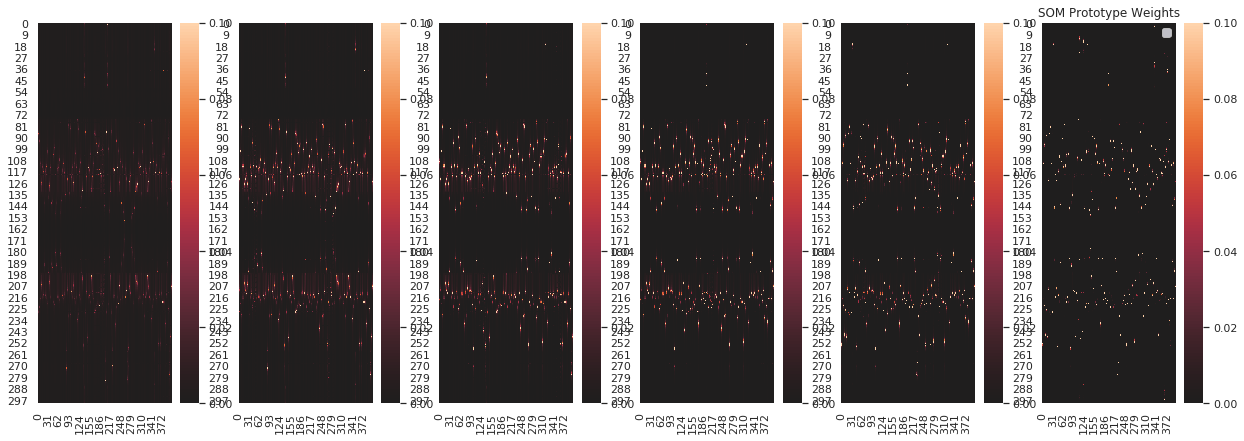

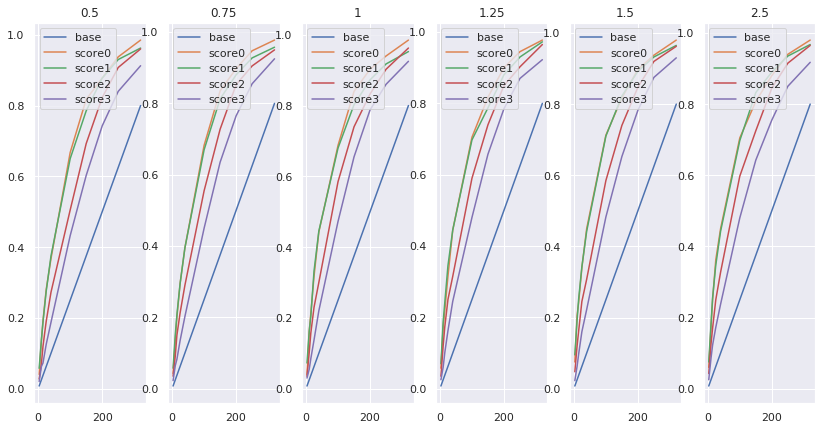

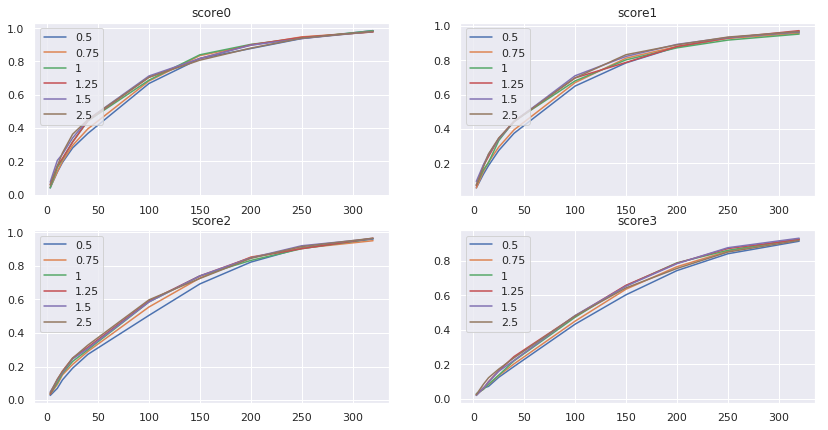

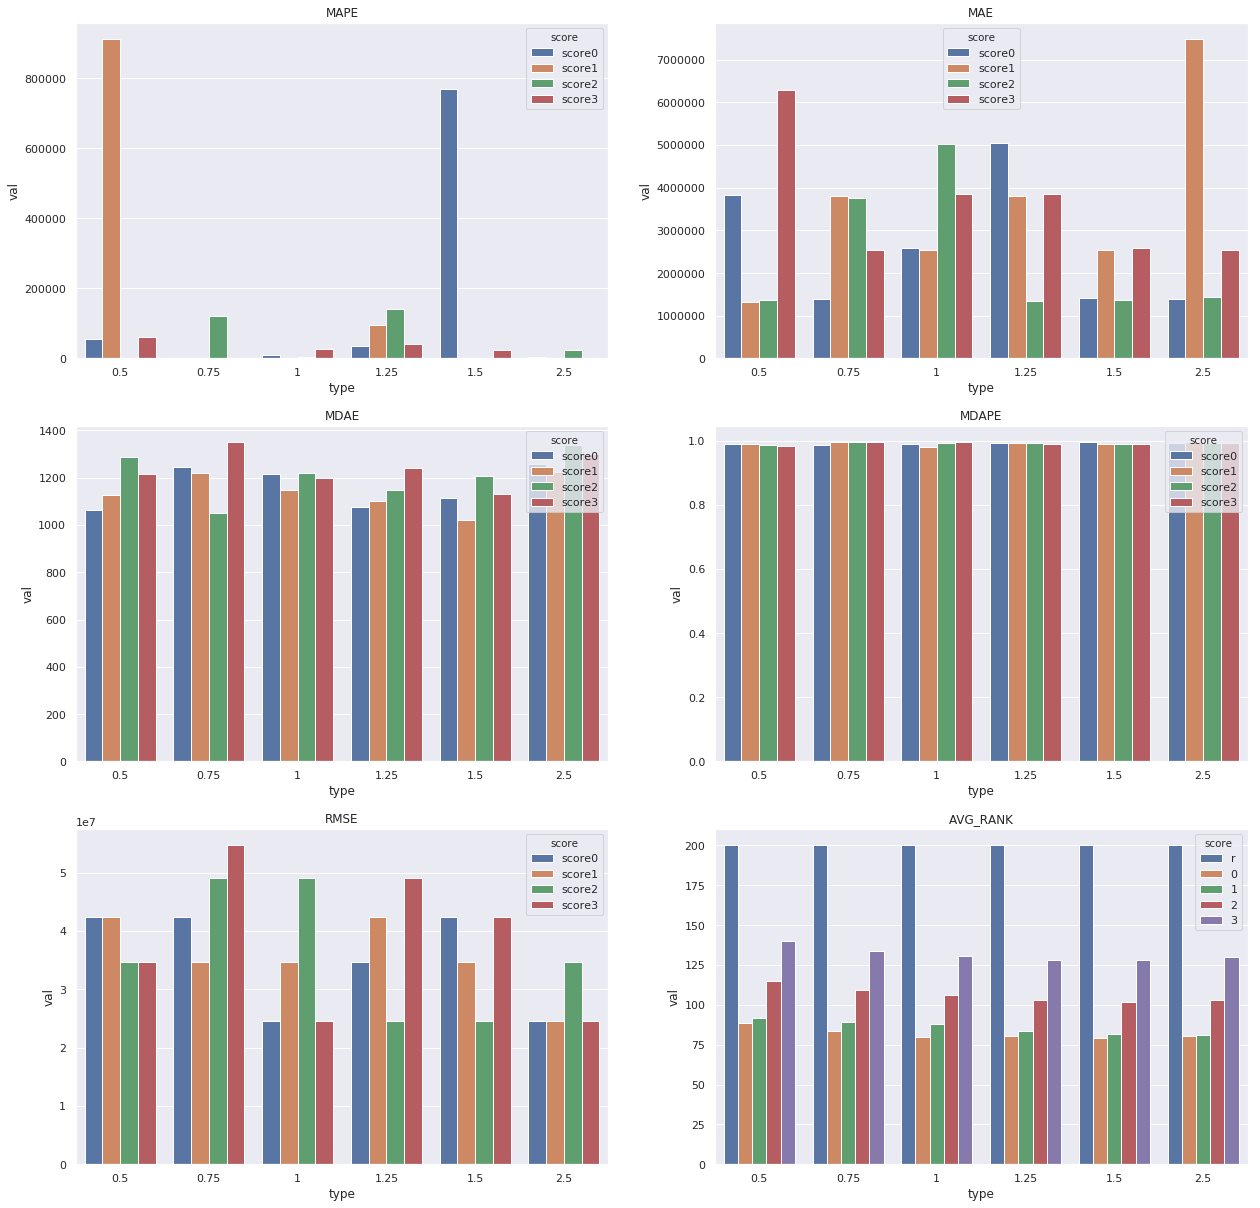

In [359]:
alphas = ['0.5', '0.75', '1', '1.25', '1.5','2.5']

res = {}

fig = plt.figure(0)
fig.set_figheight(7)
fig.set_figwidth(21)
count = 1
for alpha in alphas:
    
    idx2vec_o = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/alpha/{}/idx2vec_o_epoch5.dat'.format(alpha),'rb'))
    idx2vec_i = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/alpha/{}/idx2vec_i_epoch5.dat'.format(alpha),'rb'))
    trained_prototypes = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/alpha/{}/trained_prototypes_epoch5_300_{}.dat'.format(alpha, alpha),'rb'))

    mean_vec_o = compute_mean_vec(idx2vec_o)
    mean_vec_i = compute_mean_vec(idx2vec_i)
    prototypes = trained_prototypes['prototypes']

    prototypes2vec_i = trained_prototypes['i_embedding']
    prototypes2vec_o = trained_prototypes['o_embedding']

    transformed_protp = t.tensor(t.from_numpy(prototypes), dtype=t.float32).apply_(weighted_log).view(-1,1)
    numerals = np.array([float(i[0]) for i in filtered_dataset])
    prototype_weights = get_numeral_embed_weights_batch(t.tensor(t.from_numpy(numerals),dtype=t.float),transformed_protp,alpha=float(alpha))
    numeral_embed_i = t.matmul(prototype_weights.transpose(0,1),t.from_numpy(prototypes2vec_i))
    numeral_embed_o = t.matmul(prototype_weights.transpose(0,1),t.from_numpy(prototypes2vec_o))

    plt.subplot(1, len(alphas), count)
    sns.heatmap(prototype_weights, vmin=0, vmax=.1, center=0, label=alpha)
    norms, _ = compute_norm_factor()
    res[alpha] = eval_res('test')
    count += 1

plt.legend('upper left')
plt.title('SOM Prototype Weights')    
plt.show()
draw(res)

with open('res_alpha_test.v2.json','w') as f:
    f.write(str(res))




# Test for LSTM encoder 150 dim epoch 5, 0.05B no table

In [360]:
LSTM_model_path = '../../data/wikipedia/save/0.05Bnotable/1/LSTM/sgns_epoch5.pt'

In [361]:
LSTM_params = t.load(LSTM_model_path,map_location='cpu')

In [362]:
digital_RNN_i = t.nn.LSTM(14, 150, 1, batch_first=True)
digital_RNN_o = t.nn.LSTM(14, 150, 1, batch_first=True)

In [363]:
digital_RNN_i.bias_hh_l0 = t.nn.Parameter(LSTM_params['embedding.digital_RNN_i.bias_hh_l0'])
digital_RNN_i.bias_ih_l0 = t.nn.Parameter(LSTM_params['embedding.digital_RNN_i.bias_ih_l0'])
digital_RNN_i.weight_hh_l0 = t.nn.Parameter(LSTM_params['embedding.digital_RNN_i.weight_hh_l0'])
digital_RNN_i.weight_ih_l0 = t.nn.Parameter(LSTM_params['embedding.digital_RNN_i.weight_ih_l0'])
digital_RNN_o.bias_hh_l0 = t.nn.Parameter(LSTM_params['embedding.digital_RNN_o.bias_hh_l0'])
digital_RNN_o.bias_ih_l0 = t.nn.Parameter(LSTM_params['embedding.digital_RNN_o.bias_ih_l0'])
digital_RNN_o.weight_hh_l0 = t.nn.Parameter(LSTM_params['embedding.digital_RNN_o.weight_hh_l0'])
digital_RNN_o.weight_ih_l0 = t.nn.Parameter(LSTM_params['embedding.digital_RNN_o.weight_ih_l0'])

In [364]:
idx2digit = ['0','1','2','3','4','5','6','7','8','9','.','-','+','e']
digit2idx = {idx2digit[i]:i for i in range(len(idx2digit))}
max_token_len = 20 # should be equal to

def convert_digit_to_tensor(numeral_str):
    represent = t.zeros(max_token_len, len(idx2digit))
    assert len(numeral_str) <= max_token_len
    for i in range(len(numeral_str)):
        digit = numeral_str[i]
        idx = digit2idx[digit]
        represent[i][idx] = 1

    return represent

In [343]:
idx2vec_o = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/1/LSTM/idx2vec_o_epoch5.dat','rb'))
idx2vec_i = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/1/LSTM/idx2vec_i_epoch5.dat','rb'))
numeral_embed_i = np.zeros((len(filtered_dataset), 150))
numeral_embed_o = np.zeros((len(filtered_dataset), 150))

counter = 0
for i in filtered_dataset:
    temp = convert_digit_to_tensor(i[0]).view(1,20,14)
    _, (hn, cn) = digital_RNN_i(temp)
    e = hn.squeeze().detach().numpy()
    numeral_embed_i[counter] = e
    counter += 1
    
counter = 0
for i in filtered_dataset:
    temp = convert_digit_to_tensor(i[0]).view(1,20,14)
    _, (hn, cn) = digital_RNN_o(temp)
    e = hn.squeeze().detach().numpy()
    numeral_embed_o[counter] = e
    counter += 1

print('haha')
norms, _ = compute_norm_factor()

haha


In [365]:
res = eval_res('test')
with open('res_LSTM_test.v2.json','w') as f:
    f.write(str(res))

97.0 242885.0 2502.9690721649486 <function _get_score_0 at 0x7fe42abdfa60>
55.4 156922.0 2831.5270758122747 <function _get_score_0 at 0x7fe42abdfa60>
1253.0 490000000.0 391060.4525139665 <function _get_score_0 at 0x7fe42abdfa60>
0.7179 2639.0 3674.999442819334 <function _get_score_0 at 0x7fe42abdfa60>
91.3 242885.0 2659.2957283680175 <function _get_score_0 at 0x7fe42abdfa60>
4.8 600000.0 124999.0 <function _get_score_0 at 0x7fe42abdfa60>
0.1429 1111.0 7773.667599720084 <function _get_score_0 at 0x7fe42abdfa60>
0.15 1772.0 11812.333333333334 <function _get_score_0 at 0x7fe42abdfa60>
40.7 46000.0 1129.2211302211301 <function _get_score_0 at 0x7fe42abdfa60>
19.5 40000.0 2050.2820512820513 <function _get_score_0 at 0x7fe42abdfa60>
4096.0 12970479.0 3165.620849609375 <function _get_score_0 at 0x7fe42abdfa60>
458.0 792000.0 1728.2576419213974 <function _get_score_0 at 0x7fe42abdfa60>
39.48 50171.0 1269.7953394123608 <function _get_score_0 at 0x7fe42abdfa60>
137.0 860000.0 6276.3722627737225 

30069.0 386.0 29683.0 <function _get_score_0 at 0x7fe42abdfa60>
314.0 1347.0 1033.0 <function _get_score_0 at 0x7fe42abdfa60>
130.0 1205.0 1075.0 <function _get_score_0 at 0x7fe42abdfa60>
1300.0 9.9 1290.1 <function _get_score_0 at 0x7fe42abdfa60>
46354.0 30.6 46323.4 <function _get_score_0 at 0x7fe42abdfa60>
785.0 6852.0 6067.0 <function _get_score_0 at 0x7fe42abdfa60>
1655.0 20.5 1634.5 <function _get_score_0 at 0x7fe42abdfa60>
850000.0 1700.0 848300.0 <function _get_score_0 at 0x7fe42abdfa60>
1177.0 4250.0 3073.0 <function _get_score_0 at 0x7fe42abdfa60>
14000.0 3.9 13996.1 <function _get_score_0 at 0x7fe42abdfa60>
6958.0 16000.0 9042.0 <function _get_score_0 at 0x7fe42abdfa60>
545.0 1560.0 1015.0 <function _get_score_0 at 0x7fe42abdfa60>
1531.0 195.0 1336.0 <function _get_score_0 at 0x7fe42abdfa60>
1747.0 228.6 1518.4 <function _get_score_0 at 0x7fe42abdfa60>
514.0 1951.0 1437.0 <function _get_score_0 at 0x7fe42abdfa60>
1637.0 255.0 1382.0 <function _get_score_0 at 0x7fe42abdfa60>


1212.0 242885.0 241673.0 <function _get_score_0 at 0x7fe42abdfa60>
60000.0 53.42 59946.58 <function _get_score_0 at 0x7fe42abdfa60>
2639.0 785.0 1854.0 <function _get_score_0 at 0x7fe42abdfa60>
423.0 1537.0 1114.0 <function _get_score_0 at 0x7fe42abdfa60>
4250.0 219.0 4031.0 <function _get_score_0 at 0x7fe42abdfa60>
432.0 222555.0 222123.0 <function _get_score_0 at 0x7fe42abdfa60>
43.0 1672.0 1629.0 <function _get_score_0 at 0x7fe42abdfa60>
1409.0 195.0 1214.0 <function _get_score_0 at 0x7fe42abdfa60>
22.5 2639.0 2616.5 <function _get_score_0 at 0x7fe42abdfa60>
1364.0 6338.0 4974.0 <function _get_score_0 at 0x7fe42abdfa60>
2015.0 192.0 1823.0 <function _get_score_0 at 0x7fe42abdfa60>
50171.0 155.0 50016.0 <function _get_score_0 at 0x7fe42abdfa60>
1555.0 1208268.0 1206713.0 <function _get_score_0 at 0x7fe42abdfa60>
1909.0 10.9 1898.1 <function _get_score_0 at 0x7fe42abdfa60>
1685.0 10.9 1674.1 <function _get_score_0 at 0x7fe42abdfa60>
860000.0 487.0 859513.0 <function _get_score_0 at 0x

1347.0 6958.0 5611.0 <function _get_score_1 at 0x7fe42abdfae8>
2.2 264000.0 263997.8 <function _get_score_1 at 0x7fe42abdfae8>
4000.0 568.0 3432.0 <function _get_score_1 at 0x7fe42abdfae8>
40.7 1251.0 1210.3 <function _get_score_1 at 0x7fe42abdfae8>
19.5 1634.0 1614.5 <function _get_score_1 at 0x7fe42abdfae8>
145.0 1607.0 1462.0 <function _get_score_1 at 0x7fe42abdfae8>
10.9 2025.0 2014.1 <function _get_score_1 at 0x7fe42abdfae8>
1275.0 14.0 1261.0 <function _get_score_1 at 0x7fe42abdfae8>
220444.0 1584.0 218860.0 <function _get_score_1 at 0x7fe42abdfae8>
893.0 1983.0 1090.0 <function _get_score_1 at 0x7fe42abdfae8>
290.0 101325.0 101035.0 <function _get_score_1 at 0x7fe42abdfae8>
40000.0 172.0 39828.0 <function _get_score_1 at 0x7fe42abdfae8>
5.23 1716.0 1710.77 <function _get_score_1 at 0x7fe42abdfae8>
48.0 1280.0 1232.0 <function _get_score_1 at 0x7fe42abdfae8>
600000.0 251.0 599749.0 <function _get_score_1 at 0x7fe42abdfae8>
1772.0 4760.0 2988.0 <function _get_score_1 at 0x7fe42abd

27.1 1972.0 1944.9 <function _get_score_2 at 0x7fe42a279e18>
101325.0 1221.0 100104.0 <function _get_score_2 at 0x7fe42a279e18>
475.0 14000.0 13525.0 <function _get_score_2 at 0x7fe42a279e18>
1158.0 9.0 1149.0 <function _get_score_2 at 0x7fe42a279e18>
8.05 1634.0 1625.95 <function _get_score_2 at 0x7fe42a279e18>
1255.0 11.16 1243.84 <function _get_score_2 at 0x7fe42a279e18>
800.0 38400.0 37600.0 <function _get_score_2 at 0x7fe42a279e18>
27.5 1842.0 1814.5 <function _get_score_2 at 0x7fe42a279e18>
57.5 1987.0 1929.5 <function _get_score_2 at 0x7fe42a279e18>
0.83 1914.0 1913.17 <function _get_score_2 at 0x7fe42a279e18>
1560.0 20.6 1539.4 <function _get_score_2 at 0x7fe42a279e18>
91.3 1808.0 1716.7 <function _get_score_2 at 0x7fe42a279e18>
160000.0 1763.0 158237.0 <function _get_score_2 at 0x7fe42a279e18>
1956.0 43.0 1913.0 <function _get_score_2 at 0x7fe42a279e18>
4500.0 1238.0 3262.0 <function _get_score_2 at 0x7fe42a279e18>
2000.0 451.0 1549.0 <function _get_score_2 at 0x7fe42a279e18>


1229.0 42.0 1187.0 <function _get_score_3 at 0x7fe42c5e8488>
42.5 1620.0 1577.5 <function _get_score_3 at 0x7fe42c5e8488>
850000.0 1555.0 848445.0 <function _get_score_3 at 0x7fe42c5e8488>
1177.0 150.0 1027.0 <function _get_score_3 at 0x7fe42c5e8488>
14000.0 475.0 13525.0 <function _get_score_3 at 0x7fe42c5e8488>
6958.0 62.3 6895.7 <function _get_score_3 at 0x7fe42c5e8488>
1531.0 14.0 1517.0 <function _get_score_3 at 0x7fe42c5e8488>
20.5 1228.0 1207.5 <function _get_score_3 at 0x7fe42c5e8488>
1390.0 8848.0 7458.0 <function _get_score_3 at 0x7fe42c5e8488>
514.0 4250.0 3736.0 <function _get_score_3 at 0x7fe42c5e8488>
182000.0 166.0 181834.0 <function _get_score_3 at 0x7fe42c5e8488>
2930.0 130000.0 127070.0 <function _get_score_3 at 0x7fe42c5e8488>
4.1 1994.0 1989.9 <function _get_score_3 at 0x7fe42c5e8488>
3.14 156922.0 156918.86 <function _get_score_3 at 0x7fe42c5e8488>
1446.0 42.5 1403.5 <function _get_score_3 at 0x7fe42c5e8488>
27000.0 478.0 26522.0 <function _get_score_3 at 0x7fe42c5

860000.0 4096.0 855904.0 <function _get_score_3 at 0x7fe42c5e8488>
0.0833 1379.0 1378.9167 <function _get_score_3 at 0x7fe42c5e8488>
361.0 1756.0 1395.0 <function _get_score_3 at 0x7fe42c5e8488>
30.6 1178.0 1147.4 <function _get_score_3 at 0x7fe42c5e8488>
1716.0 60000.0 58284.0 <function _get_score_3 at 0x7fe42c5e8488>
196670.0 4.08 196665.92 <function _get_score_3 at 0x7fe42c5e8488>
1266.0 16000.0 14734.0 <function _get_score_3 at 0x7fe42c5e8488>
5700.0 2.4 5697.6 <function _get_score_3 at 0x7fe42c5e8488>
0.95 101325.0 101324.05 <function _get_score_3 at 0x7fe42c5e8488>
251.0 4760.0 4509.0 <function _get_score_3 at 0x7fe42c5e8488>
6500.0 0.2 6499.8 <function _get_score_3 at 0x7fe42c5e8488>
6600.0 1718.0 4882.0 <function _get_score_3 at 0x7fe42c5e8488>
1687.0 1022000.0 1020313.0 <function _get_score_3 at 0x7fe42c5e8488>
1620.0 90.0 1530.0 <function _get_score_3 at 0x7fe42c5e8488>
682.0 1779.0 1097.0 <function _get_score_3 at 0x7fe42c5e8488>
5.7 1559.0 1553.3 <function _get_score_3 at 0

# val for GMM , 150 dim epoch 5, 0.05B no table, random initialization

Computing mean vectors, missing 48 vectors
Computing mean vectors, missing 48 vectors
1.0025 [1916.] [1910.22194514] <function _get_score_0 at 0x7fe42abdfa60>
0.7179 [1906.] [2653.96587268] <function _get_score_0 at 0x7fe42abdfa60>
0.83 [1449.] [1744.78313253] <function _get_score_0 at 0x7fe42abdfa60>
91.3 [1208268.] [13233.04162103] <function _get_score_0 at 0x7fe42abdfa60>
0.9995 [1893.] [1892.94697349] <function _get_score_0 at 0x7fe42abdfa60>
4.8 [30069.] [6263.375] <function _get_score_0 at 0x7fe42abdfa60>
0.2 [792000.] [3959999.] <function _get_score_0 at 0x7fe42abdfa60>
1098.0 [1208268.] [1099.42622951] <function _get_score_0 at 0x7fe42abdfa60>
0.1429 [1647.] [11524.5423373] <function _get_score_0 at 0x7fe42abdfa60>
0.15 [1422.] [9479.] <function _get_score_0 at 0x7fe42abdfa60>
1456.0 [4.9e+08] [336537.46153846] <function _get_score_0 at 0x7fe42abdfa60>
10.9 [14000.] [1283.40366972] <function _get_score_0 at 0x7fe42abdfa60>
4.08 [6338.] [1552.43137255] <function _get_score_0 at 

75.6 [1275.] [1199.4] <function _get_score_0 at 0x7fe42abdfa60>
3850000.0 [6.7] [3849993.3] <function _get_score_0 at 0x7fe42abdfa60>
1769.0 [2930.] [1161.] <function _get_score_0 at 0x7fe42abdfa60>
2019.0 [130000.] [127981.] <function _get_score_0 at 0x7fe42abdfa60>
9.0 [149031.] [149022.] <function _get_score_0 at 0x7fe42abdfa60>
8848.0 [27000.] [18152.] <function _get_score_0 at 0x7fe42abdfa60>
1280.0 [3850000.] [3848720.] <function _get_score_0 at 0x7fe42abdfa60>
1731.0 [634.5] [1096.5] <function _get_score_0 at 0x7fe42abdfa60>
1893.0 [600000.] [598107.] <function _get_score_0 at 0x7fe42abdfa60>
1514.0 [49.2] [1464.8] <function _get_score_0 at 0x7fe42abdfa60>
132.0 [1689.] [1557.] <function _get_score_0 at 0x7fe42abdfa60>
1933.0 [0.2] [1932.8] <function _get_score_0 at 0x7fe42abdfa60>
1026.0 [0.0833] [1025.9167] <function _get_score_0 at 0x7fe42abdfa60>
213000.0 [936.] [212064.] <function _get_score_0 at 0x7fe42abdfa60>
155.0 [1547.] [1392.] <function _get_score_0 at 0x7fe42abdfa60

16000.0 [6958.] [9042.] <function _get_score_1 at 0x7fe42abdfae8>
4.57 [1191.] [1186.43] <function _get_score_1 at 0x7fe42abdfae8>
242885.0 [43.] [242842.] <function _get_score_1 at 0x7fe42abdfae8>
1554.0 [10.9] [1543.1] <function _get_score_1 at 0x7fe42abdfae8>
634.5 [1022000.] [1021365.5] <function _get_score_1 at 0x7fe42abdfae8>
1022000.0 [1237.] [1020763.] <function _get_score_1 at 0x7fe42abdfae8>
53000.0 [343.] [52657.] <function _get_score_1 at 0x7fe42abdfae8>
30069.0 [5.23] [30063.77] <function _get_score_1 at 0x7fe42abdfae8>
114.0 [1275.] [1161.] <function _get_score_1 at 0x7fe42abdfae8>
901.0 [1936.] [1035.] <function _get_score_1 at 0x7fe42abdfae8>
314.0 [4250.] [3936.] <function _get_score_1 at 0x7fe42abdfae8>
130.0 [38400.] [38270.] <function _get_score_1 at 0x7fe42abdfae8>
1300.0 [144000.] [142700.] <function _get_score_1 at 0x7fe42abdfae8>
46354.0 [199.] [46155.] <function _get_score_1 at 0x7fe42abdfae8>
42.5 [1720.] [1677.5] <function _get_score_1 at 0x7fe42abdfae8>
8500

1848.0 [1022000.] [1020152.] <function _get_score_2 at 0x7fe42a279e18>
412.0 [90000.] [89588.] <function _get_score_2 at 0x7fe42a279e18>
49.0 [850000.] [849951.] <function _get_score_2 at 0x7fe42a279e18>
11.2 [31395.] [31383.8] <function _get_score_2 at 0x7fe42a279e18>
1936.0 [48.] [1888.] <function _get_score_2 at 0x7fe42a279e18>
1198.0 [9.9] [1188.1] <function _get_score_2 at 0x7fe42a279e18>
97.0 [1552.] [1455.] <function _get_score_2 at 0x7fe42a279e18>
9.82 [860000.] [859990.18] <function _get_score_2 at 0x7fe42a279e18>
31395.0 [568.] [30827.] <function _get_score_2 at 0x7fe42a279e18>
1547.0 [432.] [1115.] <function _get_score_2 at 0x7fe42a279e18>
1702.0 [5.7] [1696.3] <function _get_score_2 at 0x7fe42a279e18>
49.2 [1620.] [1570.8] <function _get_score_2 at 0x7fe42a279e18>
429.0 [1663.] [1234.] <function _get_score_2 at 0x7fe42a279e18>
6852.0 [600000.] [593148.] <function _get_score_2 at 0x7fe42a279e18>
4760.0 [2025.] [2735.] <function _get_score_2 at 0x7fe42a279e18>
1.0025 [1456.] 

1698.0 [430.] [1268.] <function _get_score_2 at 0x7fe42a279e18>
395.0 [1779.] [1384.] <function _get_score_2 at 0x7fe42a279e18>
731.0 [1906.] [1175.] <function _get_score_2 at 0x7fe42a279e18>
1924.0 [3.9] [1920.1] <function _get_score_2 at 0x7fe42a279e18>
220444.0 [189.] [220255.] <function _get_score_2 at 0x7fe42a279e18>
809.0 [6500.] [5691.] <function _get_score_2 at 0x7fe42a279e18>
290.0 [1763.] [1473.] <function _get_score_2 at 0x7fe42a279e18>
40000.0 [195.] [39805.] <function _get_score_2 at 0x7fe42a279e18>
399.0 [1848.] [1449.] <function _get_score_2 at 0x7fe42a279e18>
600000.0 [1004.] [598996.] <function _get_score_2 at 0x7fe42a279e18>
1772.0 [177.] [1595.] <function _get_score_2 at 0x7fe42a279e18>
1850.0 [132.] [1718.] <function _get_score_2 at 0x7fe42a279e18>
490000000.0 [23.] [4.89999977e+08] <function _get_score_2 at 0x7fe42a279e18>
264000.0 [1778.] [262222.] <function _get_score_2 at 0x7fe42a279e18>
1607.0 [45.8] [1561.2] <function _get_score_2 at 0x7fe42a279e18>
11108.0 [1

4.1 [75000.] [74995.9] <function _get_score_3 at 0x7fe42c5e8488>
1446.0 [27.1] [1418.9] <function _get_score_3 at 0x7fe42c5e8488>
27000.0 [1702.] [25298.] <function _get_score_3 at 0x7fe42c5e8488>
1852.0 [156922.] [155070.] <function _get_score_3 at 0x7fe42c5e8488>
3183.0 [1973.] [1210.] <function _get_score_3 at 0x7fe42c5e8488>
1832.0 [0.1429] [1831.8571] <function _get_score_3 at 0x7fe42c5e8488>
1825.0 [270.] [1555.] <function _get_score_3 at 0x7fe42c5e8488>
2600.0 [1517.] [1083.] <function _get_score_3 at 0x7fe42c5e8488>
1755.0 [478.] [1277.] <function _get_score_3 at 0x7fe42c5e8488>
54.0 [1967.] [1913.] <function _get_score_3 at 0x7fe42c5e8488>
10.1 [1531.] [1520.9] <function _get_score_3 at 0x7fe42c5e8488>
3.9 [40000.] [39996.1] <function _get_score_3 at 0x7fe42c5e8488>
1700.0 [3183.] [1483.] <function _get_score_3 at 0x7fe42c5e8488>
1253.0 [4.8] [1248.2] <function _get_score_3 at 0x7fe42c5e8488>
688.0 [1943.] [1255.] <function _get_score_3 at 0x7fe42c5e8488>
1930.0 [620.] [1310.]

5.7 [1807.] [1801.3] <function _get_score_3 at 0x7fe42c5e8488>
568.0 [1022000.] [1021432.] <function _get_score_3 at 0x7fe42c5e8488>
0.0028 [1198.] [1197.9972] <function _get_score_3 at 0x7fe42c5e8488>
210.0 [1531.] [1321.] <function _get_score_3 at 0x7fe42c5e8488>
23.0 [1967.] [1944.] <function _get_score_3 at 0x7fe42c5e8488>
150.0 [1720.] [1570.] <function _get_score_3 at 0x7fe42c5e8488>
20.6 [1456.] [1435.4] <function _get_score_3 at 0x7fe42c5e8488>
1080.0 [5.9] [1074.1] <function _get_score_3 at 0x7fe42c5e8488>
5.9 [1130.] [1124.1] <function _get_score_3 at 0x7fe42c5e8488>
1643.0 [160000.] [158357.] <function _get_score_3 at 0x7fe42c5e8488>
1140.0 [27000.] [25860.] <function _get_score_3 at 0x7fe42c5e8488>
46000.0 [1191.] [44809.] <function _get_score_3 at 0x7fe42c5e8488>
75000.0 [192.] [74808.] <function _get_score_3 at 0x7fe42c5e8488>
1779.0 [40.7] [1738.3] <function _get_score_3 at 0x7fe42c5e8488>
2.376 [1560.] [1557.624] <function _get_score_3 at 0x7fe42c5e8488>
7400.0 [1987.] 

45.8 [1208268.] [1208222.2] <function _get_score_0 at 0x7fe42abdfa60>
182000.0 [27.1] [181972.9] <function _get_score_0 at 0x7fe42abdfa60>
2930.0 [1347.] [1583.] <function _get_score_0 at 0x7fe42abdfa60>
1887.0 [785.] [1102.] <function _get_score_0 at 0x7fe42abdfa60>
4.1 [282606.] [282601.9] <function _get_score_0 at 0x7fe42abdfa60>
1446.0 [5.23] [1440.77] <function _get_score_0 at 0x7fe42abdfa60>
27000.0 [130000.] [103000.] <function _get_score_0 at 0x7fe42abdfa60>
1852.0 [1022000.] [1020148.] <function _get_score_0 at 0x7fe42abdfa60>
1807.0 [800.] [1007.] <function _get_score_0 at 0x7fe42abdfa60>
3183.0 [343.] [2840.] <function _get_score_0 at 0x7fe42abdfa60>
1832.0 [432.] [1400.] <function _get_score_0 at 0x7fe42abdfa60>
1825.0 [48.] [1777.] <function _get_score_0 at 0x7fe42abdfa60>
2600.0 [1514.] [1086.] <function _get_score_0 at 0x7fe42abdfa60>
1755.0 [389.] [1366.] <function _get_score_0 at 0x7fe42abdfa60>
1778.0 [31395.] [29617.] <function _get_score_0 at 0x7fe42abdfa60>
10.1 [1

1285.0 [34.2] [1250.8] <function _get_score_0 at 0x7fe42abdfa60>
600.0 [149031.] [148431.] <function _get_score_0 at 0x7fe42abdfa60>
1212.0 [2.4] [1209.6] <function _get_score_0 at 0x7fe42abdfa60>
60000.0 [340.] [59660.] <function _get_score_0 at 0x7fe42abdfa60>
2639.0 [1449.] [1190.] <function _get_score_0 at 0x7fe42abdfa60>
423.0 [1778.] [1355.] <function _get_score_0 at 0x7fe42abdfa60>
4250.0 [713.] [3537.] <function _get_score_0 at 0x7fe42abdfa60>
137.0 [196670.] [196533.] <function _get_score_0 at 0x7fe42abdfa60>
1945.0 [514.] [1431.] <function _get_score_0 at 0x7fe42abdfa60>
1586.0 [4096.] [2510.] <function _get_score_0 at 0x7fe42abdfa60>
43.0 [1987.] [1944.] <function _get_score_0 at 0x7fe42abdfa60>
151.0 [1552.] [1401.] <function _get_score_0 at 0x7fe42abdfa60>
1195.0 [156922.] [155727.] <function _get_score_0 at 0x7fe42abdfa60>
1994.0 [278.] [1716.] <function _get_score_0 at 0x7fe42abdfa60>
1659.0 [343.] [1316.] <function _get_score_0 at 0x7fe42abdfa60>
255.0 [2014.] [1759.] <

713.0 [144000.] [143287.] <function _get_score_1 at 0x7fe42abdfae8>
1689.0 [6500.] [4811.] <function _get_score_1 at 0x7fe42abdfae8>
90000.0 [1390.] [88610.] <function _get_score_1 at 0x7fe42abdfae8>
2400.0 [0.95] [2399.05] <function _get_score_1 at 0x7fe42abdfae8>
1.6 [1004.] [1002.4] <function _get_score_1 at 0x7fe42abdfae8>
1460.0 [155.] [1305.] <function _get_score_1 at 0x7fe42abdfae8>
1237.0 [16.3] [1220.7] <function _get_score_1 at 0x7fe42abdfae8>
767.0 [1828.] [1061.] <function _get_score_1 at 0x7fe42abdfae8>
620.0 [182000.] [181380.] <function _get_score_1 at 0x7fe42abdfae8>
165.0 [2000.] [1835.] <function _get_score_1 at 0x7fe42abdfae8>
374000.0 [355.5] [373644.5] <function _get_score_1 at 0x7fe42abdfae8>
2040.0 [16.3] [2023.7] <function _get_score_1 at 0x7fe42abdfae8>
355.5 [1446.] [1090.5] <function _get_score_1 at 0x7fe42abdfae8>
166000.0 [682.] [165318.] <function _get_score_1 at 0x7fe42abdfae8>
6338.0 [386.] [5952.] <function _get_score_1 at 0x7fe42abdfae8>
1584.0 [222555

16000.0 [1906.] [14094.] <function _get_score_2 at 0x7fe42a279e18>
1162.0 [1.6] [1160.4] <function _get_score_2 at 0x7fe42a279e18>
242885.0 [0.9995] [242884.0005] <function _get_score_2 at 0x7fe42a279e18>
1554.0 [83.] [1471.] <function _get_score_2 at 0x7fe42a279e18>
303.0 [1949.] [1646.] <function _get_score_2 at 0x7fe42a279e18>
1763.0 [11.2] [1751.8] <function _get_score_2 at 0x7fe42a279e18>
1022000.0 [76.] [1021924.] <function _get_score_2 at 0x7fe42a279e18>
53000.0 [1122.] [51878.] <function _get_score_2 at 0x7fe42a279e18>
30069.0 [3.9] [30065.1] <function _get_score_2 at 0x7fe42a279e18>
114.0 [600000.] [599886.] <function _get_score_2 at 0x7fe42a279e18>
1422.0 [16000.] [14578.] <function _get_score_2 at 0x7fe42a279e18>
130.0 [1987.] [1857.] <function _get_score_2 at 0x7fe42a279e18>
1300.0 [6.7] [1293.3] <function _get_score_2 at 0x7fe42a279e18>
46354.0 [130000.] [83646.] <function _get_score_2 at 0x7fe42a279e18>
1229.0 [90.] [1139.] <function _get_score_2 at 0x7fe42a279e18>
1655.0

43.0 [1808.] [1765.] <function _get_score_2 at 0x7fe42a279e18>
151.0 [1893.] [1742.] <function _get_score_2 at 0x7fe42a279e18>
1994.0 [83.] [1911.] <function _get_score_2 at 0x7fe42a279e18>
1364.0 [50171.] [48807.] <function _get_score_2 at 0x7fe42a279e18>
2015.0 [265.] [1750.] <function _get_score_2 at 0x7fe42a279e18>
50171.0 [378.] [49793.] <function _get_score_2 at 0x7fe42a279e18>
1555.0 [156922.] [155367.] <function _get_score_2 at 0x7fe42a279e18>
1909.0 [166.] [1743.] <function _get_score_2 at 0x7fe42a279e18>
1685.0 [496.] [1189.] <function _get_score_2 at 0x7fe42a279e18>
1951.0 [97.] [1854.] <function _get_score_2 at 0x7fe42a279e18>
1400.0 [16.3] [1383.7] <function _get_score_2 at 0x7fe42a279e18>
860000.0 [1198.] [858802.] <function _get_score_2 at 0x7fe42a279e18>
0.0833 [1400.] [1399.9167] <function _get_score_2 at 0x7fe42a279e18>
30.6 [1720.] [1689.4] <function _get_score_2 at 0x7fe42a279e18>
1716.0 [27.1] [1688.9] <function _get_score_2 at 0x7fe42a279e18>
196670.0 [0.9998] [19

4500.0 [1158.] [3342.] <function _get_score_3 at 0x7fe42c5e8488>
14.9 [792000.] [791985.1] <function _get_score_3 at 0x7fe42c5e8488>
4.8 [1922.] [1917.2] <function _get_score_3 at 0x7fe42c5e8488>
62.3 [1604.] [1541.7] <function _get_score_3 at 0x7fe42c5e8488>
282606.0 [1814.] [280792.] <function _get_score_3 at 0x7fe42c5e8488>
75.6 [6852.] [6776.4] <function _get_score_3 at 0x7fe42c5e8488>
1906.0 [44.6] [1861.4] <function _get_score_3 at 0x7fe42c5e8488>
3850000.0 [1769.] [3848231.] <function _get_score_3 at 0x7fe42c5e8488>
9.0 [1825.] [1816.] <function _get_score_3 at 0x7fe42c5e8488>
8848.0 [1228.] [7620.] <function _get_score_3 at 0x7fe42c5e8488>
1280.0 [4096.] [2816.] <function _get_score_3 at 0x7fe42c5e8488>
1731.0 [389.] [1342.] <function _get_score_3 at 0x7fe42c5e8488>
1876.0 [255.] [1621.] <function _get_score_3 at 0x7fe42c5e8488>
510.0 [1778.] [1268.] <function _get_score_3 at 0x7fe42c5e8488>
1983.0 [177.] [1806.] <function _get_score_3 at 0x7fe42c5e8488>
2014.0 [151.] [1863.] <

Computing mean vectors, missing 48 vectors
Computing mean vectors, missing 48 vectors
1198.0 [4.9e+08] [409014.02504174] <function _get_score_0 at 0x7fe42abdfa60>
1004.0 [1208268.] [1202.45418327] <function _get_score_0 at 0x7fe42abdfa60>
44.6 [196670.] [4408.64125561] <function _get_score_0 at 0x7fe42abdfa60>
10.1 [673094.] [66641.97029703] <function _get_score_0 at 0x7fe42abdfa60>
0.7179 [1772.] [2467.31034963] <function _get_score_0 at 0x7fe42abdfa60>
8.05 [600000.] [74533.16149068] <function _get_score_0 at 0x7fe42abdfa60>
0.83 [913.] [1099.] <function _get_score_0 at 0x7fe42abdfa60>
0.9995 [4096.] [4097.04902451] <function _get_score_0 at 0x7fe42abdfa60>
4.8 [166000.] [34582.33333333] <function _get_score_0 at 0x7fe42abdfa60>
1756.0 [12970479.] [7385.37756264] <function _get_score_0 at 0x7fe42abdfa60>
868.0 [4.9e+08] [564515.12903226] <function _get_score_0 at 0x7fe42abdfa60>
0.1429 [2600.] [18193.54163751] <function _get_score_0 at 0x7fe42abdfa60>
0.15 [149031.] [993539.] <functi

53000.0 [1.0025] [52998.9975] <function _get_score_0 at 0x7fe42abdfa60>
30069.0 [0.0537] [30068.9463] <function _get_score_0 at 0x7fe42abdfa60>
114.0 [1769.] [1655.] <function _get_score_0 at 0x7fe42abdfa60>
901.0 [156922.] [156021.] <function _get_score_0 at 0x7fe42abdfa60>
1422.0 [200000.] [198578.] <function _get_score_0 at 0x7fe42abdfa60>
314.0 [1208268.] [1207954.] <function _get_score_0 at 0x7fe42abdfa60>
46354.0 [1561.] [44793.] <function _get_score_0 at 0x7fe42abdfa60>
1229.0 [120.] [1109.] <function _get_score_0 at 0x7fe42abdfa60>
850000.0 [1647.] [848353.] <function _get_score_0 at 0x7fe42abdfa60>
1644.0 [34.2] [1609.8] <function _get_score_0 at 0x7fe42abdfa60>
1177.0 [165.] [1012.] <function _get_score_0 at 0x7fe42abdfa60>
14000.0 [953.] [13047.] <function _get_score_0 at 0x7fe42abdfa60>
6958.0 [1178.] [5780.] <function _get_score_0 at 0x7fe42abdfa60>
20.5 [1607.] [1586.5] <function _get_score_0 at 0x7fe42abdfa60>
1009.0 [27000.] [25991.] <function _get_score_0 at 0x7fe42abd

60000.0 [39.48] [59960.52] <function _get_score_0 at 0x7fe42abdfa60>
2639.0 [1002.] [1637.] <function _get_score_0 at 0x7fe42abdfa60>
4250.0 [1255.] [2995.] <function _get_score_0 at 0x7fe42abdfa60>
1945.0 [20.6] [1924.4] <function _get_score_0 at 0x7fe42abdfa60>
1586.0 [458.] [1128.] <function _get_score_0 at 0x7fe42abdfa60>
219.0 [1755.] [1536.] <function _get_score_0 at 0x7fe42abdfa60>
43.0 [1972.] [1929.] <function _get_score_0 at 0x7fe42abdfa60>
151.0 [11108.] [10957.] <function _get_score_0 at 0x7fe42abdfa60>
1195.0 [49.] [1146.] <function _get_score_0 at 0x7fe42abdfa60>
1409.0 [9.9] [1399.1] <function _get_score_0 at 0x7fe42abdfa60>
22.5 [1449.] [1426.5] <function _get_score_0 at 0x7fe42abdfa60>
1994.0 [620.] [1374.] <function _get_score_0 at 0x7fe42abdfa60>
2015.0 [4.57] [2010.43] <function _get_score_0 at 0x7fe42abdfa60>
50171.0 [1248.] [48923.] <function _get_score_0 at 0x7fe42abdfa60>
1909.0 [378.] [1531.] <function _get_score_0 at 0x7fe42abdfa60>
1951.0 [144000.] [142049.] 

1647.0 [11108.] [9461.] <function _get_score_1 at 0x7fe42abdfae8>
27.5 [282606.] [282578.5] <function _get_score_1 at 0x7fe42abdfae8>
496.0 [11108.] [10612.] <function _get_score_1 at 0x7fe42abdfae8>
14.0 [1832.] [1818.] <function _get_score_1 at 0x7fe42abdfae8>
1645.0 [27.5] [1617.5] <function _get_score_1 at 0x7fe42abdfae8>
0.83 [130000.] [129999.17] <function _get_score_1 at 0x7fe42abdfae8>
91.3 [1195.] [1103.7] <function _get_score_1 at 0x7fe42abdfae8>
160000.0 [355.5] [159644.5] <function _get_score_1 at 0x7fe42abdfae8>
4500.0 [340.] [4160.] <function _get_score_1 at 0x7fe42abdfae8>
430.0 [149031.] [148601.] <function _get_score_1 at 0x7fe42abdfae8>
2000.0 [31395.] [29395.] <function _get_score_1 at 0x7fe42abdfae8>
0.9995 [1460.] [1459.0005] <function _get_score_1 at 0x7fe42abdfae8>
1449.0 [3680.] [2231.] <function _get_score_1 at 0x7fe42abdfae8>
282606.0 [0.0028] [282605.9972] <function _get_score_1 at 0x7fe42abdfae8>
75.6 [1906.] [1830.4] <function _get_score_1 at 0x7fe42abdfae8

1552.0 [144000.] [142448.] <function _get_score_1 at 0x7fe42abdfae8>
361.0 [222555.] [222194.] <function _get_score_1 at 0x7fe42abdfae8>
1716.0 [6.54] [1709.46] <function _get_score_1 at 0x7fe42abdfae8>
196670.0 [1025.] [195645.] <function _get_score_1 at 0x7fe42abdfae8>
195.0 [1850.] [1655.] <function _get_score_1 at 0x7fe42abdfae8>
1814.0 [53.42] [1760.58] <function _get_score_1 at 0x7fe42abdfae8>
5700.0 [1850.] [3850.] <function _get_score_1 at 0x7fe42abdfae8>
11.16 [1285.] [1273.84] <function _get_score_1 at 0x7fe42abdfae8>
1240.0 [6852.] [5612.] <function _get_score_1 at 0x7fe42abdfae8>
1808.0 [166000.] [164192.] <function _get_score_1 at 0x7fe42abdfae8>
6500.0 [46000.] [39500.] <function _get_score_1 at 0x7fe42abdfae8>
6600.0 [1659.] [4941.] <function _get_score_1 at 0x7fe42abdfae8>
5.54 [149031.] [149025.46] <function _get_score_1 at 0x7fe42abdfae8>
902.0 [1906.] [1004.] <function _get_score_1 at 0x7fe42abdfae8>
1620.0 [76.] [1544.] <function _get_score_1 at 0x7fe42abdfae8>
5.7 

265.0 [1561.] [1296.] <function _get_score_2 at 0x7fe42a279e18>
1688.0 [533.] [1155.] <function _get_score_2 at 0x7fe42a279e18>
478.0 [1586.] [1108.] <function _get_score_2 at 0x7fe42a279e18>
1111.0 [0.15] [1110.85] <function _get_score_2 at 0x7fe42a279e18>
1743.0 [127.] [1616.] <function _get_score_2 at 0x7fe42a279e18>
397.0 [46000.] [45603.] <function _get_score_2 at 0x7fe42a279e18>
1098.0 [4250.] [3152.] <function _get_score_2 at 0x7fe42a279e18>
362.0 [2639.] [2277.] <function _get_score_2 at 0x7fe42a279e18>
713.0 [1914.] [1201.] <function _get_score_2 at 0x7fe42a279e18>
1689.0 [3850000.] [3848311.] <function _get_score_2 at 0x7fe42a279e18>
0.1429 [1718.] [1717.8571] <function _get_score_2 at 0x7fe42a279e18>
90000.0 [60000.] [30000.] <function _get_score_2 at 0x7fe42a279e18>
1733.0 [130.] [1603.] <function _get_score_2 at 0x7fe42a279e18>
1.6 [1004.] [1002.4] <function _get_score_2 at 0x7fe42a279e18>
76.0 [2014.] [1938.] <function _get_score_2 at 0x7fe42a279e18>
1622.0 [42.5] [1579.5

20.6 [16000.] [15979.4] <function _get_score_2 at 0x7fe42a279e18>
1080.0 [22.5] [1057.5] <function _get_score_2 at 0x7fe42a279e18>
1140.0 [49.] [1091.] <function _get_score_2 at 0x7fe42a279e18>
46000.0 [1893.] [44107.] <function _get_score_2 at 0x7fe42a279e18>
120.0 [264000.] [263880.] <function _get_score_2 at 0x7fe42a279e18>
53.42 [1733.] [1679.58] <function _get_score_2 at 0x7fe42a279e18>
7400.0 [1212.] [6188.] <function _get_score_2 at 0x7fe42a279e18>
9.9 [1647.] [1637.1] <function _get_score_2 at 0x7fe42a279e18>
1914.0 [255.] [1659.] <function _get_score_2 at 0x7fe42a279e18>
19.1 [1409.] [1389.9] <function _get_score_3 at 0x7fe42c5e8488>
5.3 [1009.] [1003.7] <function _get_score_3 at 0x7fe42c5e8488>
83.0 [1130.] [1047.] <function _get_score_3 at 0x7fe42c5e8488>
167.0 [1460.] [1293.] <function _get_score_3 at 0x7fe42c5e8488>
412.0 [1559.] [1147.] <function _get_score_3 at 0x7fe42c5e8488>
1038.0 [6958.] [5920.] <function _get_score_3 at 0x7fe42c5e8488>
1936.0 [1022000.] [1020064.] <

374000.0 [242885.] [131115.] <function _get_score_3 at 0x7fe42c5e8488>
2040.0 [1004.] [1036.] <function _get_score_3 at 0x7fe42c5e8488>
355.5 [1850.] [1494.5] <function _get_score_3 at 0x7fe42c5e8488>
166000.0 [14.] [165986.] <function _get_score_3 at 0x7fe42c5e8488>
1228.0 [20.5] [1207.5] <function _get_score_3 at 0x7fe42c5e8488>
6338.0 [265.] [6073.] <function _get_score_3 at 0x7fe42c5e8488>
3.49 [222555.] [222551.51] <function _get_score_3 at 0x7fe42c5e8488>
1494.0 [43.] [1451.] <function _get_score_3 at 0x7fe42c5e8488>
4000.0 [113.] [3887.] <function _get_score_3 at 0x7fe42c5e8488>
40.7 [1041.] [1000.3] <function _get_score_3 at 0x7fe42c5e8488>
145.0 [5700.] [5555.] <function _get_score_3 at 0x7fe42c5e8488>
199.0 [101325.] [101126.] <function _get_score_3 at 0x7fe42c5e8488>
1275.0 [75000.] [73725.] <function _get_score_3 at 0x7fe42c5e8488>
1698.0 [55.4] [1642.6] <function _get_score_3 at 0x7fe42c5e8488>
395.0 [1208268.] [1207873.] <function _get_score_3 at 0x7fe42c5e8488>
16.3 [188

42.5 [60000.] [1410.76470588] <function _get_score_1 at 0x7fe42abdfae8>
0.7179 [1928.] [2684.6108093] <function _get_score_1 at 0x7fe42abdfae8>
0.9995 [1808.] [1807.90445223] <function _get_score_1 at 0x7fe42abdfae8>
0.2 [1733.] [8664.] <function _get_score_1 at 0x7fe42abdfae8>
21.0 [264000.] [12570.42857143] <function _get_score_1 at 0x7fe42abdfae8>
200.0 [213000.] [1064.] <function _get_score_1 at 0x7fe42abdfae8>
217.0 [860000.] [3962.13364055] <function _get_score_1 at 0x7fe42abdfae8>
0.1429 [370.] [2588.22323303] <function _get_score_1 at 0x7fe42abdfae8>
0.15 [1228.] [8185.66666667] <function _get_score_1 at 0x7fe42abdfae8>
40.7 [75000.] [1841.75184275] <function _get_score_1 at 0x7fe42abdfae8>
161.0 [600000.] [3725.70807453] <function _get_score_1 at 0x7fe42abdfae8>
34.7 [282606.] [8143.26512968] <function _get_score_1 at 0x7fe42abdfae8>
0.9998 [1718.] [1717.34366873] <function _get_score_1 at 0x7fe42abdfae8>
0.0833 [1400.] [16805.72268908] <function _get_score_1 at 0x7fe42abdfae8

3.9 [1731.] [1727.1] <function _get_score_0 at 0x7fe42abdfa60>
1700.0 [189.] [1511.] <function _get_score_0 at 0x7fe42abdfa60>
1253.0 [6600.] [5347.] <function _get_score_0 at 0x7fe42abdfa60>
101325.0 [113.] [101212.] <function _get_score_0 at 0x7fe42abdfa60>
0.7179 [1922.] [1921.2821] <function _get_score_0 at 0x7fe42abdfa60>
1158.0 [44.6] [1113.4] <function _get_score_0 at 0x7fe42abdfa60>
8.05 [46354.] [46345.95] <function _get_score_0 at 0x7fe42abdfa60>
1647.0 [151.] [1496.] <function _get_score_0 at 0x7fe42abdfa60>
27.5 [1956.] [1928.5] <function _get_score_0 at 0x7fe42abdfa60>
1560.0 [0.0537] [1559.9463] <function _get_score_0 at 0x7fe42abdfa60>
91.3 [1769.] [1677.7] <function _get_score_0 at 0x7fe42abdfa60>
160000.0 [1.0025] [159998.9975] <function _get_score_0 at 0x7fe42abdfa60>
1956.0 [76.] [1880.] <function _get_score_0 at 0x7fe42abdfa60>
172.0 [46354.] [46182.] <function _get_score_0 at 0x7fe42abdfa60>
4500.0 [620.] [3880.] <function _get_score_0 at 0x7fe42abdfa60>
14.9 [2600

49.2 [90000.] [89950.8] <function _get_score_1 at 0x7fe42abdfae8>
1205.0 [31395.] [30190.] <function _get_score_1 at 0x7fe42abdfae8>
429.0 [1685.] [1256.] <function _get_score_1 at 0x7fe42abdfae8>
6852.0 [11.16] [6840.84] <function _get_score_1 at 0x7fe42abdfae8>
80.0 [2639.] [2559.] <function _get_score_1 at 0x7fe42abdfae8>
4760.0 [1248.] [3512.] <function _get_score_1 at 0x7fe42abdfae8>
1967.0 [16.3] [1950.7] <function _get_score_1 at 0x7fe42abdfae8>
130000.0 [75.9] [129924.1] <function _get_score_1 at 0x7fe42abdfae8>
1720.0 [144000.] [142280.] <function _get_score_1 at 0x7fe42abdfae8>
1386.0 [144000.] [142614.] <function _get_score_1 at 0x7fe42abdfae8>
16000.0 [1994.] [14006.] <function _get_score_1 at 0x7fe42abdfae8>
533.0 [130000.] [129467.] <function _get_score_1 at 0x7fe42abdfae8>
242885.0 [365.] [242520.] <function _get_score_1 at 0x7fe42abdfae8>
1554.0 [151.] [1403.] <function _get_score_1 at 0x7fe42abdfae8>
303.0 [1644.] [1341.] <function _get_score_1 at 0x7fe42abdfae8>
634.5

1928.0 [127.] [1801.] <function _get_score_1 at 0x7fe42abdfae8>
4.08 [1852.] [1847.92] <function _get_score_1 at 0x7fe42abdfae8>
240.0 [1672.] [1432.] <function _get_score_1 at 0x7fe42abdfae8>
1178.0 [264000.] [262822.] <function _get_score_1 at 0x7fe42abdfae8>
1910.0 [881.] [1029.] <function _get_score_1 at 0x7fe42abdfae8>
4096.0 [1972.] [2124.] <function _get_score_1 at 0x7fe42abdfae8>
6.7 [1400.] [1393.3] <function _get_score_1 at 0x7fe42abdfae8>
1718.0 [3.9] [1714.1] <function _get_score_1 at 0x7fe42abdfae8>
1516.0 [42.5] [1473.5] <function _get_score_1 at 0x7fe42abdfae8>
12970479.0 [1177.] [12969302.] <function _get_score_1 at 0x7fe42abdfae8>
340.0 [4000.] [3660.] <function _get_score_1 at 0x7fe42abdfae8>
1561.0 [222555.] [220994.] <function _get_score_1 at 0x7fe42abdfae8>
1208268.0 [1842.] [1206426.] <function _get_score_1 at 0x7fe42abdfae8>
1480.0 [429.] [1051.] <function _get_score_1 at 0x7fe42abdfae8>
149031.0 [496.] [148535.] <function _get_score_1 at 0x7fe42abdfae8>
673094.0

57.5 [1949.] [1891.5] <function _get_score_2 at 0x7fe42a279e18>
1645.0 [82.] [1563.] <function _get_score_2 at 0x7fe42a279e18>
0.83 [1130.] [1129.17] <function _get_score_2 at 0x7fe42a279e18>
1560.0 [130000.] [128440.] <function _get_score_2 at 0x7fe42a279e18>
160000.0 [1733.] [158267.] <function _get_score_2 at 0x7fe42a279e18>
953.0 [2014.] [1061.] <function _get_score_2 at 0x7fe42a279e18>
1956.0 [713.] [1243.] <function _get_score_2 at 0x7fe42a279e18>
4500.0 [11.2] [4488.8] <function _get_score_2 at 0x7fe42a279e18>
430.0 [1956.] [1526.] <function _get_score_2 at 0x7fe42a279e18>
2000.0 [22.5] [1977.5] <function _get_score_2 at 0x7fe42a279e18>
0.9995 [1778.] [1777.0005] <function _get_score_2 at 0x7fe42a279e18>
4.8 [27000.] [26995.2] <function _get_score_2 at 0x7fe42a279e18>
62.3 [1205.] [1142.7] <function _get_score_2 at 0x7fe42a279e18>
282606.0 [545.] [282061.] <function _get_score_2 at 0x7fe42a279e18>
75.6 [1552.] [1476.4] <function _get_score_2 at 0x7fe42a279e18>
3850000.0 [200.] [

1251.0 [0.0833] [1250.9167] <function _get_score_2 at 0x7fe42a279e18>
34.2 [1480.] [1445.8] <function _get_score_2 at 0x7fe42a279e18>
568.0 [196670.] [196102.] <function _get_score_2 at 0x7fe42a279e18>
0.0028 [1280.] [1279.9972] <function _get_score_2 at 0x7fe42a279e18>
210.0 [1500.] [1290.] <function _get_score_2 at 0x7fe42a279e18>
886.0 [50171.] [49285.] <function _get_score_2 at 0x7fe42a279e18>
502.0 [1643.] [1141.] <function _get_score_2 at 0x7fe42a279e18>
23.0 [1928.] [1905.] <function _get_score_2 at 0x7fe42a279e18>
5.9 [1949.] [1943.1] <function _get_score_2 at 0x7fe42a279e18>
1643.0 [362.] [1281.] <function _get_score_2 at 0x7fe42a279e18>
1140.0 [0.15] [1139.85] <function _get_score_2 at 0x7fe42a279e18>
0.0537 [1516.] [1515.9463] <function _get_score_2 at 0x7fe42a279e18>
46000.0 [451.] [45549.] <function _get_score_2 at 0x7fe42a279e18>
75000.0 [1641.] [73359.] <function _get_score_2 at 0x7fe42a279e18>
1030.0 [264000.] [262970.] <function _get_score_2 at 0x7fe42a279e18>
53.42 [1

16.3 [75000.] [74983.7] <function _get_score_3 at 0x7fe42c5e8488>
731.0 [5700.] [4969.] <function _get_score_3 at 0x7fe42c5e8488>
220444.0 [16.3] [220427.7] <function _get_score_3 at 0x7fe42c5e8488>
1537.0 [2.2] [1534.8] <function _get_score_3 at 0x7fe42c5e8488>
809.0 [6958.] [6149.] <function _get_score_3 at 0x7fe42c5e8488>
290.0 [673094.] [672804.] <function _get_score_3 at 0x7fe42c5e8488>
40000.0 [1516.] [38484.] <function _get_score_3 at 0x7fe42c5e8488>
5.23 [1883.] [1877.77] <function _get_score_3 at 0x7fe42c5e8488>
48.0 [46000.] [45952.] <function _get_score_3 at 0x7fe42c5e8488>
399.0 [200000.] [199601.] <function _get_score_3 at 0x7fe42c5e8488>
600000.0 [1140.] [598860.] <function _get_score_3 at 0x7fe42c5e8488>
1772.0 [14000.] [12228.] <function _get_score_3 at 0x7fe42c5e8488>
1850.0 [4500.] [2650.] <function _get_score_3 at 0x7fe42c5e8488>
490000000.0 [1449.] [4.89998551e+08] <function _get_score_3 at 0x7fe42c5e8488>
264000.0 [1531.] [262469.] <function _get_score_3 at 0x7fe42

34.7 [1022000.] [29451.44956772] <function _get_score_1 at 0x7fe42abdfae8>
0.9998 [1716.] [1715.34326865] <function _get_score_1 at 0x7fe42abdfae8>
22.5 [160000.] [7110.11111111] <function _get_score_1 at 0x7fe42abdfae8>
0.0833 [1933.] [23204.28211285] <function _get_score_1 at 0x7fe42abdfae8>
750.0 [3850000.] [5132.33333333] <function _get_score_1 at 0x7fe42abdfae8>
6600.0 [12970479.] [1964.22409091] <function _get_score_1 at 0x7fe42abdfae8>
0.5538 [1702.] [3072.31166486] <function _get_score_1 at 0x7fe42abdfae8>
0.0028 [82.] [29284.71428571] <function _get_score_1 at 0x7fe42abdfae8>
0.0537 [507.5] [9449.65176909] <function _get_score_1 at 0x7fe42abdfae8>
9.9 [374000.] [37776.77777778] <function _get_score_1 at 0x7fe42abdfae8>
83.0 [90000.] [1083.3373494] <function _get_score_2 at 0x7fe42a279e18>
412.0 [4.9e+08] [1189319.38834951] <function _get_score_2 at 0x7fe42a279e18>
0.7179 [2000.] [2784.90332915] <function _get_score_2 at 0x7fe42a279e18>
0.9995 [1930.] [1929.96548274] <function 

355.5 [1514.] [1158.5] <function _get_score_0 at 0x7fe42abdfa60>
166000.0 [6852.] [159148.] <function _get_score_0 at 0x7fe42abdfa60>
72.4 [6338.] [6265.6] <function _get_score_0 at 0x7fe42abdfa60>
6338.0 [868.] [5470.] <function _get_score_0 at 0x7fe42abdfa60>
3.49 [1852.] [1848.51] <function _get_score_0 at 0x7fe42abdfa60>
2.4 [2400.] [2397.6] <function _get_score_0 at 0x7fe42abdfa60>
1347.0 [23.] [1324.] <function _get_score_0 at 0x7fe42abdfa60>
2.2 [1253.] [1250.8] <function _get_score_0 at 0x7fe42abdfa60>
1494.0 [137.] [1357.] <function _get_score_0 at 0x7fe42abdfa60>
4000.0 [75.9] [3924.1] <function _get_score_0 at 0x7fe42abdfa60>
19.5 [196670.] [196650.5] <function _get_score_0 at 0x7fe42abdfa60>
161.0 [1266.] [1105.] <function _get_score_0 at 0x7fe42abdfa60>
1275.0 [34.2] [1240.8] <function _get_score_0 at 0x7fe42abdfa60>
1698.0 [149031.] [147333.] <function _get_score_0 at 0x7fe42abdfa60>
365.0 [1763.] [1398.] <function _get_score_0 at 0x7fe42abdfa60>
16.3 [1945.] [1928.7] <fu

1554.0 [53.42] [1500.58] <function _get_score_1 at 0x7fe42abdfae8>
1763.0 [75.6] [1687.4] <function _get_score_1 at 0x7fe42abdfae8>
1022000.0 [4.57] [1021995.43] <function _get_score_1 at 0x7fe42abdfae8>
53000.0 [75.6] [52924.4] <function _get_score_1 at 0x7fe42abdfae8>
30069.0 [953.] [29116.] <function _get_score_1 at 0x7fe42abdfae8>
114.0 [2000.] [1886.] <function _get_score_1 at 0x7fe42abdfae8>
1422.0 [38400.] [36978.] <function _get_score_1 at 0x7fe42abdfae8>
130.0 [1221.] [1091.] <function _get_score_1 at 0x7fe42abdfae8>
1300.0 [0.83] [1299.17] <function _get_score_1 at 0x7fe42abdfae8>
46354.0 [1910.] [44444.] <function _get_score_1 at 0x7fe42abdfae8>
1655.0 [478.] [1177.] <function _get_score_1 at 0x7fe42abdfae8>
850000.0 [1275.] [848725.] <function _get_score_1 at 0x7fe42abdfae8>
1644.0 [49.2] [1594.8] <function _get_score_1 at 0x7fe42abdfae8>
14000.0 [2930.] [11070.] <function _get_score_1 at 0x7fe42abdfae8>
6958.0 [1221.] [5737.] <function _get_score_1 at 0x7fe42abdfae8>
20.5 

1949.0 [282606.] [280657.] <function _get_score_1 at 0x7fe42abdfae8>
1130.0 [3183.] [2053.] <function _get_score_1 at 0x7fe42abdfae8>
792000.0 [1647.] [790353.] <function _get_score_1 at 0x7fe42abdfae8>
600.0 [144000.] [143400.] <function _get_score_1 at 0x7fe42abdfae8>
1707.0 [46000.] [44293.] <function _get_score_1 at 0x7fe42abdfae8>
6.54 [1080.] [1073.46] <function _get_score_1 at 0x7fe42abdfae8>
60000.0 [1700.] [58300.] <function _get_score_1 at 0x7fe42abdfae8>
2639.0 [20.6] [2618.4] <function _get_score_1 at 0x7fe42abdfae8>
4250.0 [713.] [3537.] <function _get_score_1 at 0x7fe42abdfae8>
137.0 [1933.] [1796.] <function _get_score_1 at 0x7fe42abdfae8>
1945.0 [0.1429] [1944.8571] <function _get_score_1 at 0x7fe42abdfae8>
1586.0 [496.] [1090.] <function _get_score_1 at 0x7fe42abdfae8>
0.9998 [1248.] [1247.0002] <function _get_score_1 at 0x7fe42abdfae8>
43.0 [1928.] [1885.] <function _get_score_1 at 0x7fe42abdfae8>
1409.0 [314.] [1095.] <function _get_score_1 at 0x7fe42abdfae8>
1994.0 

172.0 [1641.] [1469.] <function _get_score_2 at 0x7fe42a279e18>
4500.0 [1009.] [3491.] <function _get_score_2 at 0x7fe42a279e18>
4.8 [4500.] [4495.2] <function _get_score_2 at 0x7fe42a279e18>
62.3 [213000.] [212937.7] <function _get_score_2 at 0x7fe42a279e18>
389.0 [1924.] [1535.] <function _get_score_2 at 0x7fe42a279e18>
282606.0 [944.] [281662.] <function _get_score_2 at 0x7fe42a279e18>
75.6 [1887.] [1811.4] <function _get_score_2 at 0x7fe42a279e18>
1906.0 [343.] [1563.] <function _get_score_2 at 0x7fe42a279e18>
3850000.0 [82.] [3849918.] <function _get_score_2 at 0x7fe42a279e18>
1769.0 [4500.] [2731.] <function _get_score_2 at 0x7fe42a279e18>
2019.0 [38400.] [36381.] <function _get_score_2 at 0x7fe42a279e18>
9.0 [1212.] [1203.] <function _get_score_2 at 0x7fe42a279e18>
8848.0 [395.] [8453.] <function _get_score_2 at 0x7fe42a279e18>
1280.0 [2930.] [1650.] <function _get_score_2 at 0x7fe42a279e18>
1893.0 [1.0025] [1891.9975] <function _get_score_2 at 0x7fe42a279e18>
1514.0 [57.5] [145

1641.0 [6.54] [1634.46] <function _get_score_2 at 0x7fe42a279e18>
6500.0 [1644.] [4856.] <function _get_score_2 at 0x7fe42a279e18>
6600.0 [1887.] [4713.] <function _get_score_2 at 0x7fe42a279e18>
1687.0 [40000.] [38313.] <function _get_score_2 at 0x7fe42a279e18>
5.54 [1718.] [1712.46] <function _get_score_2 at 0x7fe42a279e18>
1604.0 [278.] [1326.] <function _get_score_2 at 0x7fe42a279e18>
1620.0 [22.5] [1597.5] <function _get_score_2 at 0x7fe42a279e18>
682.0 [1808.] [1126.] <function _get_score_2 at 0x7fe42a279e18>
0.5538 [1672.] [1671.4462] <function _get_score_2 at 0x7fe42a279e18>
5.7 [1237.] [1231.3] <function _get_score_2 at 0x7fe42a279e18>
1251.0 [81.] [1170.] <function _get_score_2 at 0x7fe42a279e18>
34.2 [1655.] [1620.8] <function _get_score_2 at 0x7fe42a279e18>
370.0 [2400.] [2030.] <function _get_score_2 at 0x7fe42a279e18>
210.0 [4096.] [3886.] <function _get_score_2 at 0x7fe42a279e18>
886.0 [12970479.] [12969593.] <function _get_score_2 at 0x7fe42a279e18>
502.0 [46354.] [4585

307.0 [1607.] [1300.] <function _get_score_3 at 0x7fe42c5e8488>
166000.0 [430.] [165570.] <function _get_score_3 at 0x7fe42c5e8488>
6338.0 [14000.] [7662.] <function _get_score_3 at 0x7fe42c5e8488>
1584.0 [507.5] [1076.5] <function _get_score_3 at 0x7fe42c5e8488>
1456.0 [219.] [1237.] <function _get_score_3 at 0x7fe42c5e8488>
2.2 [1876.] [1873.8] <function _get_score_3 at 0x7fe42c5e8488>
4000.0 [6852.] [2852.] <function _get_score_3 at 0x7fe42c5e8488>
40.7 [222555.] [222514.3] <function _get_score_3 at 0x7fe42c5e8488>
19.5 [149031.] [149011.5] <function _get_score_3 at 0x7fe42c5e8488>
145.0 [1422.] [1277.] <function _get_score_3 at 0x7fe42c5e8488>
10.9 [1641.] [1630.1] <function _get_score_3 at 0x7fe42c5e8488>
161.0 [1449.] [1288.] <function _get_score_3 at 0x7fe42c5e8488>
507.5 [1514.] [1006.5] <function _get_score_3 at 0x7fe42c5e8488>
199.0 [1280.] [1081.] <function _get_score_3 at 0x7fe42c5e8488>
1698.0 [340.] [1358.] <function _get_score_3 at 0x7fe42c5e8488>
365.0 [1763.] [1398.] <

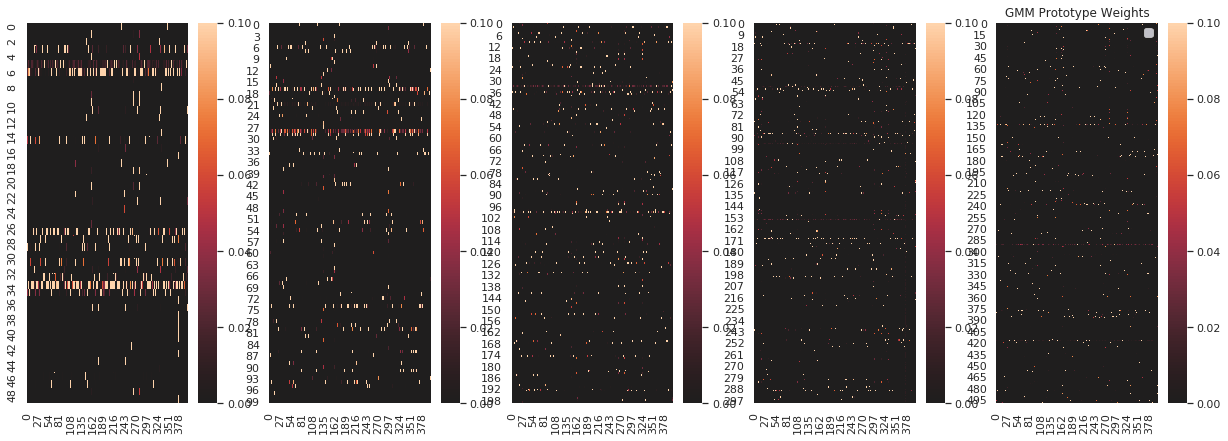

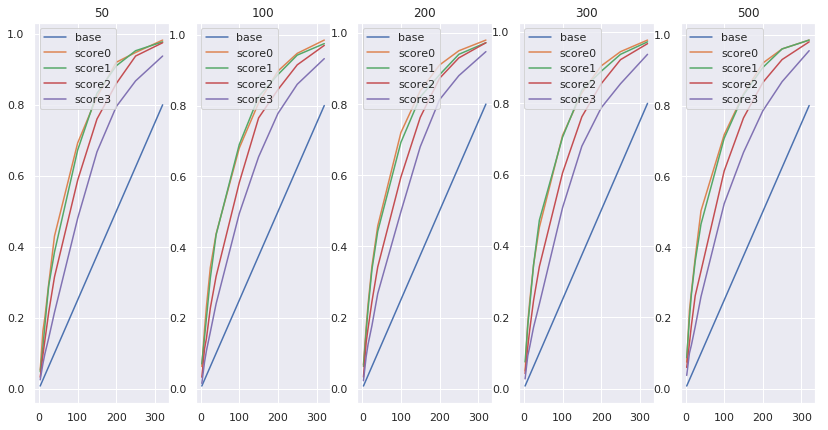

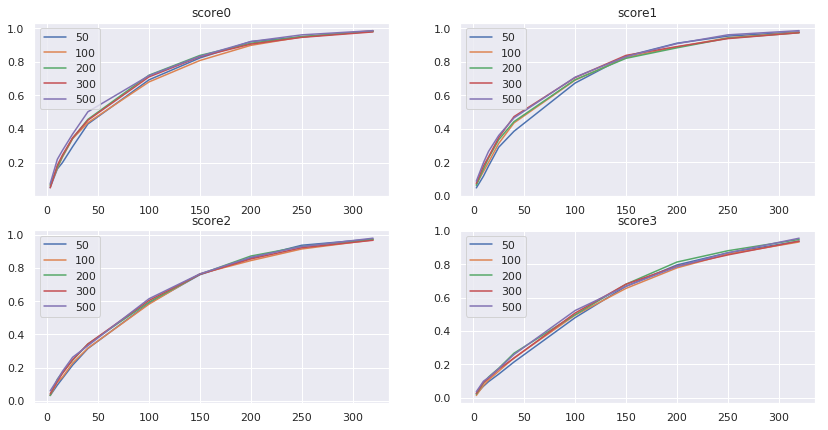

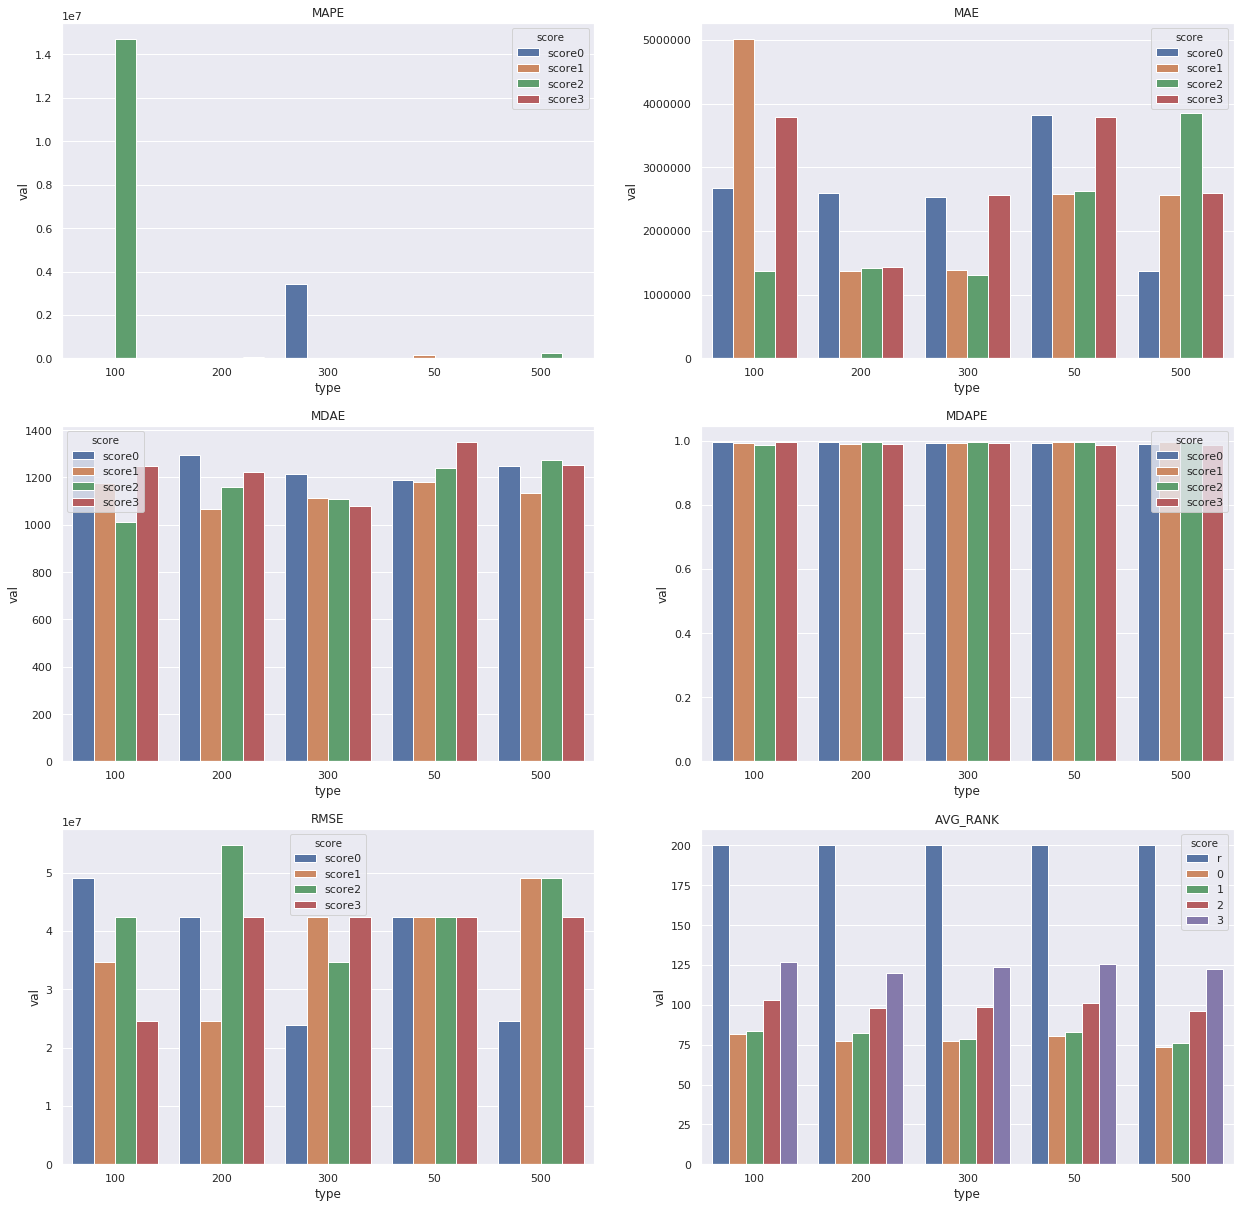

In [366]:
gmms = ['50', '100', '200', '300', '500']
res = {}

fig = plt.figure(0)
fig.set_figheight(7)
fig.set_figwidth(21)
count = 1
for gmm_name in gmms:
    numerals = np.array([float(i[0]) for i in filtered_dataset]).reshape(-1,1)
    
    idx2vec_o = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/gmm/{}-rd/idx2vec_o_epoch5.dat'.format(gmm_name),'rb'))
    idx2vec_i = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/gmm/{}-rd/idx2vec_i_epoch5.dat'.format(gmm_name),'rb'))
    trained_prototypes = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/gmm/{}-rd/trained_gmms_epoch5_{}.dat'.format(gmm_name, gmm_name),'rb'))

    mean_vec_o = compute_mean_vec(idx2vec_o)
    mean_vec_i = compute_mean_vec(idx2vec_i)
    
    
    gmm = pickle.load(open('../../data/wikipedia/preprocess0.05Bnotable/NumeralAsNumeral/gmm/gmm-{}-rd.dat'.format(gmm_name),'rb'))
    prototype_weights = gmm.predict_proba(numerals.reshape(-1,1))
    
    prototypes2vec_i = trained_prototypes['i_embedding']
    prototypes2vec_o = trained_prototypes['o_embedding']
    numeral_embed_i = t.from_numpy(np.matmul(prototype_weights, prototypes2vec_i)) # (93, 150)
    numeral_embed_o = t.from_numpy(np.matmul(prototype_weights, prototypes2vec_o)) # (93, 150)
    

    plt.subplot(1, len(gmms), count)
    sns.heatmap(prototype_weights.T, vmin=0, vmax=.1, center=0, label=gmm_name)
    norms, _ = compute_norm_factor()

    res[gmm_name] = eval_res('test')
        
    count += 1

plt.legend('upper left')
plt.title('GMM Prototype Weights')    
plt.show()
draw(res)

with open('res_gmm_rd_test.v2.json'.format(mode),'w') as f:
    f.write(str(res))

# val for GMM , 150 dim epoch 5, 0.05B no table, from prototype initialization

Computing mean vectors, missing 48 vectors
Computing mean vectors, missing 48 vectors
9.82 [282606.] [28777.61507128] <function _get_score_0 at 0x7fe42abdfa60>
0.83 [1195.] [1438.75903614] <function _get_score_0 at 0x7fe42abdfa60>
0.9995 [101325.] [101374.68784392] <function _get_score_0 at 0x7fe42abdfa60>
4.8 [6958.] [1448.58333333] <function _get_score_0 at 0x7fe42abdfa60>
0.2 [1779.] [8894.] <function _get_score_0 at 0x7fe42abdfa60>
75.6 [144000.] [1903.76190476] <function _get_score_0 at 0x7fe42abdfa60>
944.0 [1208268.] [1278.94491525] <function _get_score_0 at 0x7fe42abdfa60>
479.0 [673094.] [1404.20668058] <function _get_score_0 at 0x7fe42abdfa60>
0.1429 [1009.] [7059.88173548] <function _get_score_0 at 0x7fe42abdfa60>
1.6 [38400.] [23999.] <function _get_score_0 at 0x7fe42abdfa60>
189.0 [264000.] [1395.82539683] <function _get_score_0 at 0x7fe42abdfa60>
0.15 [785.] [5232.33333333] <function _get_score_0 at 0x7fe42abdfa60>
378.0 [1208268.] [3195.47619048] <function _get_score_0 a

101325.0 [1687.] [99638.] <function _get_score_0 at 0x7fe42abdfa60>
0.7179 [6338.] [6337.2821] <function _get_score_0 at 0x7fe42abdfa60>
475.0 [1733.] [1258.] <function _get_score_0 at 0x7fe42abdfa60>
8.05 [264000.] [263991.95] <function _get_score_0 at 0x7fe42abdfa60>
1255.0 [199.] [1056.] <function _get_score_0 at 0x7fe42abdfa60>
1647.0 [303.] [1344.] <function _get_score_0 at 0x7fe42abdfa60>
27.5 [1637.] [1609.5] <function _get_score_0 at 0x7fe42abdfa60>
14.0 [3183.] [3169.] <function _get_score_0 at 0x7fe42abdfa60>
1645.0 [30069.] [28424.] <function _get_score_0 at 0x7fe42abdfa60>
91.3 [1825.] [1733.7] <function _get_score_0 at 0x7fe42abdfa60>
160000.0 [1295.] [158705.] <function _get_score_0 at 0x7fe42abdfa60>
4500.0 [1111.] [3389.] <function _get_score_0 at 0x7fe42abdfa60>
14.9 [1620.] [1605.1] <function _get_score_0 at 0x7fe42abdfa60>
430.0 [1930.] [1500.] <function _get_score_0 at 0x7fe42abdfa60>
0.9995 [1909.] [1908.0005] <function _get_score_0 at 0x7fe42abdfa60>
62.3 [144000.

210.0 [2019.] [1809.] <function _get_score_0 at 0x7fe42abdfa60>
502.0 [2600.] [2098.] <function _get_score_0 at 0x7fe42abdfa60>
23.0 [1641.] [1618.] <function _get_score_0 at 0x7fe42abdfa60>
20.6 [1943.] [1922.4] <function _get_score_0 at 0x7fe42abdfa60>
5.9 [1559.] [1553.1] <function _get_score_0 at 0x7fe42abdfa60>
1643.0 [673094.] [671451.] <function _get_score_0 at 0x7fe42abdfa60>
46000.0 [303.] [45697.] <function _get_score_0 at 0x7fe42abdfa60>
75000.0 [550.] [74450.] <function _get_score_0 at 0x7fe42abdfa60>
120.0 [2600.] [2480.] <function _get_score_0 at 0x7fe42abdfa60>
1030.0 [600000.] [598970.] <function _get_score_0 at 0x7fe42abdfa60>
53.42 [1720.] [1666.58] <function _get_score_0 at 0x7fe42abdfa60>
2.376 [1559.] [1556.624] <function _get_score_0 at 0x7fe42abdfa60>
7400.0 [189.] [7211.] <function _get_score_0 at 0x7fe42abdfa60>
1972.0 [5700.] [3728.] <function _get_score_0 at 0x7fe42abdfa60>
9.9 [1688.] [1678.1] <function _get_score_0 at 0x7fe42abdfa60>
1914.0 [278.] [1636.] <

75.9 [1990.] [1914.1] <function _get_score_1 at 0x7fe42abdfae8>
222555.0 [0.2] [222554.8] <function _get_score_1 at 0x7fe42abdfae8>
144000.0 [1807.] [142193.] <function _get_score_1 at 0x7fe42abdfae8>
1949.0 [785.] [1164.] <function _get_score_1 at 0x7fe42abdfae8>
1130.0 [38400.] [37270.] <function _get_score_1 at 0x7fe42abdfae8>
792000.0 [682.] [791318.] <function _get_score_1 at 0x7fe42abdfae8>
604.0 [2014.] [1410.] <function _get_score_1 at 0x7fe42abdfae8>
39.48 [166000.] [165960.52] <function _get_score_1 at 0x7fe42abdfae8>
1212.0 [6.7] [1205.3] <function _get_score_1 at 0x7fe42abdfae8>
6.54 [1195.] [1188.46] <function _get_score_1 at 0x7fe42abdfae8>
60000.0 [53000.] [7000.] <function _get_score_1 at 0x7fe42abdfae8>
2639.0 [1212.] [1427.] <function _get_score_1 at 0x7fe42abdfae8>
423.0 [1643.] [1220.] <function _get_score_1 at 0x7fe42abdfae8>
4250.0 [39.48] [4210.52] <function _get_score_1 at 0x7fe42abdfae8>
1945.0 [3850000.] [3848055.] <function _get_score_1 at 0x7fe42abdfae8>
158

510.0 [1807.] [1297.] <function _get_score_2 at 0x7fe42a279e18>
2014.0 [3.9] [2010.1] <function _get_score_2 at 0x7fe42a279e18>
1916.0 [0.95] [1915.05] <function _get_score_2 at 0x7fe42a279e18>
1756.0 [46000.] [44244.] <function _get_score_2 at 0x7fe42a279e18>
944.0 [1972.] [1028.] <function _get_score_2 at 0x7fe42a279e18>
1933.0 [49.] [1884.] <function _get_score_2 at 0x7fe42a279e18>
213000.0 [1266.] [211734.] <function _get_score_2 at 0x7fe42a279e18>
155.0 [1807.] [1652.] <function _get_score_2 at 0x7fe42a279e18>
881.0 [673094.] [672213.] <function _get_score_2 at 0x7fe42a279e18>
1634.0 [21.] [1613.] <function _get_score_2 at 0x7fe42a279e18>
200.0 [1655.] [1455.] <function _get_score_2 at 0x7fe42a279e18>
1517.0 [389.] [1128.] <function _get_score_2 at 0x7fe42a279e18>
200000.0 [14.9] [199985.1] <function _get_score_2 at 0x7fe42a279e18>
217.0 [1883.] [1666.] <function _get_score_2 at 0x7fe42a279e18>
478.0 [1807.] [1329.] <function _get_score_2 at 0x7fe42a279e18>
1111.0 [1208268.] [1207

23.0 [220444.] [220421.] <function _get_score_2 at 0x7fe42a279e18>
20.6 [1240.] [1219.4] <function _get_score_2 at 0x7fe42a279e18>
1140.0 [3.9] [1136.1] <function _get_score_2 at 0x7fe42a279e18>
0.0537 [1480.] [1479.9463] <function _get_score_2 at 0x7fe42a279e18>
46000.0 [2015.] [43985.] <function _get_score_2 at 0x7fe42a279e18>
75000.0 [868.] [74132.] <function _get_score_2 at 0x7fe42a279e18>
1779.0 [550.] [1229.] <function _get_score_2 at 0x7fe42a279e18>
53.42 [1547.] [1493.58] <function _get_score_2 at 0x7fe42a279e18>
7400.0 [487.] [6913.] <function _get_score_2 at 0x7fe42a279e18>
1972.0 [270.] [1702.] <function _get_score_2 at 0x7fe42a279e18>
1914.0 [5.9] [1908.1] <function _get_score_2 at 0x7fe42a279e18>
5.3 [1943.] [1937.7] <function _get_score_3 at 0x7fe42c5e8488>
1012.0 [5700.] [4688.] <function _get_score_3 at 0x7fe42c5e8488>
412.0 [4500.] [4088.] <function _get_score_3 at 0x7fe42c5e8488>
1038.0 [50171.] [49133.] <function _get_score_3 at 0x7fe42c5e8488>
11.2 [1238.] [1226.8] 

343.0 [3850000.] [3849657.] <function _get_score_3 at 0x7fe42c5e8488>
165.0 [1887.] [1722.] <function _get_score_3 at 0x7fe42c5e8488>
374000.0 [378.] [373622.] <function _get_score_3 at 0x7fe42c5e8488>
1559.0 [75000.] [73441.] <function _get_score_3 at 0x7fe42c5e8488>
2040.0 [192.] [1848.] <function _get_score_3 at 0x7fe42c5e8488>
355.5 [1994.] [1638.5] <function _get_score_3 at 0x7fe42c5e8488>
166000.0 [172.] [165828.] <function _get_score_3 at 0x7fe42c5e8488>
6338.0 [1698.] [4640.] <function _get_score_3 at 0x7fe42c5e8488>
1584.0 [6958.] [5374.] <function _get_score_3 at 0x7fe42c5e8488>
2.2 [1663.] [1660.8] <function _get_score_3 at 0x7fe42c5e8488>
4000.0 [1212.] [2788.] <function _get_score_3 at 0x7fe42c5e8488>
145.0 [1641.] [1496.] <function _get_score_3 at 0x7fe42c5e8488>
199.0 [1909.] [1710.] <function _get_score_3 at 0x7fe42c5e8488>
395.0 [2600.] [2205.] <function _get_score_3 at 0x7fe42c5e8488>
16.3 [1111.] [1094.7] <function _get_score_3 at 0x7fe42c5e8488>
1924.0 [120.] [1804.

0.7179 [2015.] [2805.79760412] <function _get_score_1 at 0x7fe42abdfae8>
91.3 [1022000.] [11192.86637459] <function _get_score_1 at 0x7fe42abdfae8>
0.9995 [1280.] [1279.64032016] <function _get_score_1 at 0x7fe42abdfae8>
0.2 [399.] [1994.] <function _get_score_1 at 0x7fe42abdfae8>
9.0 [220444.] [24492.77777778] <function _get_score_1 at 0x7fe42abdfae8>
0.1429 [1700.] [11895.43107068] <function _get_score_1 at 0x7fe42abdfae8>
40.7 [182000.] [4470.74447174] <function _get_score_1 at 0x7fe42abdfae8>
19.5 [850000.] [43588.74358974] <function _get_score_1 at 0x7fe42abdfae8>
42.0 [53000.] [1260.9047619] <function _get_score_1 at 0x7fe42abdfae8>
4.08 [90000.] [22057.82352941] <function _get_score_1 at 0x7fe42abdfae8>
75.9 [673094.] [8867.16864295] <function _get_score_1 at 0x7fe42abdfae8>
0.0833 [127.] [1523.60984394] <function _get_score_1 at 0x7fe42abdfae8>
30.6 [166000.] [5423.83660131] <function _get_score_1 at 0x7fe42abdfae8>
0.5538 [1516.] [2736.45034308] <function _get_score_1 at 0x7fe

496.0 [3850000.] [3849504.] <function _get_score_0 at 0x7fe42abdfa60>
1645.0 [430.] [1215.] <function _get_score_0 at 0x7fe42abdfa60>
0.83 [1733.] [1732.17] <function _get_score_0 at 0x7fe42abdfa60>
1560.0 [0.0537] [1559.9463] <function _get_score_0 at 0x7fe42abdfa60>
160000.0 [1162.] [158838.] <function _get_score_0 at 0x7fe42abdfa60>
4500.0 [82.] [4418.] <function _get_score_0 at 0x7fe42abdfa60>
430.0 [2015.] [1585.] <function _get_score_0 at 0x7fe42abdfa60>
2000.0 [4250.] [2250.] <function _get_score_0 at 0x7fe42abdfa60>
936.0 [242885.] [241949.] <function _get_score_0 at 0x7fe42abdfa60>
0.9995 [374000.] [373999.0005] <function _get_score_0 at 0x7fe42abdfa60>
4.8 [1625.] [1620.2] <function _get_score_0 at 0x7fe42abdfa60>
62.3 [160000.] [159937.7] <function _get_score_0 at 0x7fe42abdfa60>
1449.0 [2930.] [1481.] <function _get_score_0 at 0x7fe42abdfa60>
282606.0 [1295.] [281311.] <function _get_score_0 at 0x7fe42abdfa60>
75.6 [8848.] [8772.4] <function _get_score_0 at 0x7fe42abdfa60>


5.7 [1500.] [1494.3] <function _get_score_0 at 0x7fe42abdfa60>
1251.0 [7400.] [6149.] <function _get_score_0 at 0x7fe42abdfa60>
210.0 [1702.] [1492.] <function _get_score_0 at 0x7fe42abdfa60>
1643.0 [9.9] [1633.1] <function _get_score_0 at 0x7fe42abdfa60>
46000.0 [1949.] [44051.] <function _get_score_0 at 0x7fe42abdfa60>
75000.0 [1.83] [74998.17] <function _get_score_0 at 0x7fe42abdfa60>
1779.0 [282606.] [280827.] <function _get_score_0 at 0x7fe42abdfa60>
120.0 [1253.] [1133.] <function _get_score_0 at 0x7fe42abdfa60>
2.376 [850000.] [849997.624] <function _get_score_0 at 0x7fe42abdfa60>
7400.0 [1874.] [5526.] <function _get_score_0 at 0x7fe42abdfa60>
9.9 [1685.] [1675.1] <function _get_score_0 at 0x7fe42abdfa60>
19.1 [1737.] [1717.9] <function _get_score_1 at 0x7fe42abdfae8>
5.3 [1876.] [1870.7] <function _get_score_1 at 0x7fe42abdfae8>
83.0 [1887.] [1804.] <function _get_score_1 at 0x7fe42abdfae8>
1848.0 [314.] [1534.] <function _get_score_1 at 0x7fe42abdfae8>
167.0 [1559.] [1392.] <

48.0 [673094.] [673046.] <function _get_score_1 at 0x7fe42abdfae8>
399.0 [4760.] [4361.] <function _get_score_1 at 0x7fe42abdfae8>
600000.0 [1607.] [598393.] <function _get_score_1 at 0x7fe42abdfae8>
1850.0 [130.] [1720.] <function _get_score_1 at 0x7fe42abdfae8>
490000000.0 [2.376] [4.89999998e+08] <function _get_score_1 at 0x7fe42abdfae8>
264000.0 [40000.] [224000.] <function _get_score_1 at 0x7fe42abdfae8>
1379.0 [1.0025] [1377.9975] <function _get_score_1 at 0x7fe42abdfae8>
11108.0 [1386.] [9722.] <function _get_score_1 at 0x7fe42abdfae8>
1990.0 [19.5] [1970.5] <function _get_score_1 at 0x7fe42abdfae8>
5.25 [1238.] [1232.75] <function _get_score_1 at 0x7fe42abdfae8>
550.0 [242885.] [242335.] <function _get_score_1 at 0x7fe42abdfae8>
1928.0 [16000.] [14072.] <function _get_score_1 at 0x7fe42abdfae8>
4.08 [1122.] [1117.92] <function _get_score_1 at 0x7fe42abdfae8>
240.0 [1390.] [1150.] <function _get_score_1 at 0x7fe42abdfae8>
1178.0 [40.7] [1137.3] <function _get_score_1 at 0x7fe42a

57.5 [1659.] [1601.5] <function _get_score_2 at 0x7fe42a279e18>
160000.0 [451.] [159549.] <function _get_score_2 at 0x7fe42a279e18>
4500.0 [2040.] [2460.] <function _get_score_2 at 0x7fe42a279e18>
0.9995 [1990.] [1989.0005] <function _get_score_2 at 0x7fe42a279e18>
62.3 [1531.] [1468.7] <function _get_score_2 at 0x7fe42a279e18>
0.2 [1022000.] [1021999.8] <function _get_score_2 at 0x7fe42a279e18>
282606.0 [1778.] [280828.] <function _get_score_2 at 0x7fe42a279e18>
75.6 [6958.] [6882.4] <function _get_score_2 at 0x7fe42a279e18>
1906.0 [83.] [1823.] <function _get_score_2 at 0x7fe42a279e18>
3850000.0 [386.] [3849614.] <function _get_score_2 at 0x7fe42a279e18>
1769.0 [76.] [1693.] <function _get_score_2 at 0x7fe42a279e18>
2019.0 [165.] [1854.] <function _get_score_2 at 0x7fe42a279e18>
9.0 [2015.] [2006.] <function _get_score_2 at 0x7fe42a279e18>
8848.0 [83.] [8765.] <function _get_score_2 at 0x7fe42a279e18>
1893.0 [362.] [1531.] <function _get_score_2 at 0x7fe42a279e18>
132.0 [60000.] [598

361.0 [11108.] [10747.] <function _get_score_2 at 0x7fe42a279e18>
196670.0 [1.0025] [196668.9975] <function _get_score_2 at 0x7fe42a279e18>
195.0 [1559.] [1364.] <function _get_score_2 at 0x7fe42a279e18>
1266.0 [2.376] [1263.624] <function _get_score_2 at 0x7fe42a279e18>
1814.0 [39.48] [1774.52] <function _get_score_2 at 0x7fe42a279e18>
5700.0 [3.49] [5696.51] <function _get_score_2 at 0x7fe42a279e18>
0.95 [1874.] [1873.05] <function _get_score_2 at 0x7fe42a279e18>
1240.0 [4250.] [3010.] <function _get_score_2 at 0x7fe42a279e18>
750.0 [1922.] [1172.] <function _get_score_2 at 0x7fe42a279e18>
1808.0 [3850000.] [3848192.] <function _get_score_2 at 0x7fe42a279e18>
1122.0 [860000.] [858878.] <function _get_score_2 at 0x7fe42a279e18>
251.0 [1916.] [1665.] <function _get_score_2 at 0x7fe42a279e18>
1641.0 [2.376] [1638.624] <function _get_score_2 at 0x7fe42a279e18>
6500.0 [251.] [6249.] <function _get_score_2 at 0x7fe42a279e18>
6600.0 [1700.] [4900.] <function _get_score_2 at 0x7fe42a279e18>


0.1429 [1828.] [1827.8571] <function _get_score_3 at 0x7fe42c5e8488>
90000.0 [1228.] [88772.] <function _get_score_3 at 0x7fe42c5e8488>
2400.0 [1240.] [1160.] <function _get_score_3 at 0x7fe42c5e8488>
1733.0 [200000.] [198267.] <function _get_score_3 at 0x7fe42c5e8488>
189.0 [1265.] [1076.] <function _get_score_3 at 0x7fe42c5e8488>
76.0 [1848.] [1772.] <function _get_score_3 at 0x7fe42c5e8488>
1460.0 [3183.] [1723.] <function _get_score_3 at 0x7fe42c5e8488>
343.0 [1500.] [1157.] <function _get_score_3 at 0x7fe42c5e8488>
620.0 [6852.] [6232.] <function _get_score_3 at 0x7fe42c5e8488>
165.0 [1422.] [1257.] <function _get_score_3 at 0x7fe42c5e8488>
374000.0 [1832.] [372168.] <function _get_score_3 at 0x7fe42c5e8488>
2040.0 [550.] [1490.] <function _get_score_3 at 0x7fe42c5e8488>
166000.0 [2015.] [163985.] <function _get_score_3 at 0x7fe42c5e8488>
6338.0 [1460.] [4878.] <function _get_score_3 at 0x7fe42c5e8488>
3.49 [3680.] [3676.51] <function _get_score_3 at 0x7fe42c5e8488>
1456.0 [5.25] 

0.95 [130000.] [136841.10526316] <function _get_score_0 at 0x7fe42abdfa60>
251.0 [600000.] [2389.43824701] <function _get_score_0 at 0x7fe42abdfa60>
0.5538 [1275.] [2301.2751896] <function _get_score_0 at 0x7fe42abdfa60>
5.7 [3850000.] [675437.59649123] <function _get_score_0 at 0x7fe42abdfa60>
0.0028 [600.] [214284.71428571] <function _get_score_0 at 0x7fe42abdfa60>
0.0537 [172.] [3201.97951583] <function _get_score_0 at 0x7fe42abdfa60>
1.0025 [1663.] [1657.85286783] <function _get_score_1 at 0x7fe42abdfae8>
38400.0 [4.9e+08] [12759.41666667] <function _get_score_1 at 0x7fe42abdfae8>
45.8 [60000.] [1309.04366812] <function _get_score_1 at 0x7fe42abdfae8>
4.1 [264000.] [64389.24390244] <function _get_score_1 at 0x7fe42abdfae8>
27.5 [3850000.] [139999.] <function _get_score_1 at 0x7fe42abdfae8>
0.83 [6338.] [7635.14457831] <function _get_score_1 at 0x7fe42abdfae8>
172.0 [222555.] [1292.9244186] <function _get_score_1 at 0x7fe42abdfae8>
0.9995 [1936.] [1935.96848424] <function _get_score

10.1 [3183.] [3172.9] <function _get_score_0 at 0x7fe42abdfa60>
127.0 [1140.] [1013.] <function _get_score_0 at 0x7fe42abdfa60>
27.1 [1663.] [1635.9] <function _get_score_0 at 0x7fe42abdfa60>
101325.0 [4.8] [101320.2] <function _get_score_0 at 0x7fe42abdfa60>
0.7179 [1205.] [1204.2821] <function _get_score_0 at 0x7fe42abdfa60>
475.0 [6852.] [6377.] <function _get_score_0 at 0x7fe42abdfa60>
8.05 [792000.] [791991.95] <function _get_score_0 at 0x7fe42abdfa60>
1255.0 [54.] [1201.] <function _get_score_0 at 0x7fe42abdfa60>
14.0 [1909.] [1895.] <function _get_score_0 at 0x7fe42abdfa60>
57.5 [1212.] [1154.5] <function _get_score_0 at 0x7fe42abdfa60>
1645.0 [0.0028] [1644.9972] <function _get_score_0 at 0x7fe42abdfa60>
0.83 [6338.] [6337.17] <function _get_score_0 at 0x7fe42abdfa60>
91.3 [1634.] [1542.7] <function _get_score_0 at 0x7fe42abdfa60>
160000.0 [1731.] [158269.] <function _get_score_0 at 0x7fe42abdfa60>
953.0 [2400.] [1447.] <function _get_score_0 at 0x7fe42abdfa60>
4500.0 [4.9e+08]

0.5538 [6500.] [6499.4462] <function _get_score_0 at 0x7fe42abdfa60>
5.7 [75000.] [74994.3] <function _get_score_0 at 0x7fe42abdfa60>
1830.0 [55.4] [1774.6] <function _get_score_0 at 0x7fe42abdfa60>
1251.0 [90000.] [88749.] <function _get_score_0 at 0x7fe42abdfa60>
34.2 [1687.] [1652.8] <function _get_score_0 at 0x7fe42abdfa60>
370.0 [1547.] [1177.] <function _get_score_0 at 0x7fe42abdfa60>
487.0 [1755.] [1268.] <function _get_score_0 at 0x7fe42abdfa60>
23.0 [27000.] [26977.] <function _get_score_0 at 0x7fe42abdfa60>
1080.0 [9.82] [1070.18] <function _get_score_0 at 0x7fe42abdfa60>
5.9 [792000.] [791994.1] <function _get_score_0 at 0x7fe42abdfa60>
46000.0 [4.8] [45995.2] <function _get_score_0 at 0x7fe42abdfa60>
75000.0 [0.95] [74999.05] <function _get_score_0 at 0x7fe42abdfa60>
1779.0 [0.7179] [1778.2821] <function _get_score_0 at 0x7fe42abdfa60>
1030.0 [2.2] [1027.8] <function _get_score_0 at 0x7fe42abdfa60>
2.376 [2400.] [2397.624] <function _get_score_0 at 0x7fe42abdfa60>
7400.0 [2

1828.0 [2.376] [1825.624] <function _get_score_1 at 0x7fe42abdfae8>
5.25 [40000.] [39994.75] <function _get_score_1 at 0x7fe42abdfae8>
378.0 [1637.] [1259.] <function _get_score_1 at 0x7fe42abdfae8>
550.0 [1552.] [1002.] <function _get_score_1 at 0x7fe42abdfae8>
4.08 [1769.] [1764.92] <function _get_score_1 at 0x7fe42abdfae8>
1178.0 [137.] [1041.] <function _get_score_1 at 0x7fe42abdfae8>
1910.0 [6500.] [4590.] <function _get_score_1 at 0x7fe42abdfae8>
4096.0 [5.7] [4090.3] <function _get_score_1 at 0x7fe42abdfae8>
1718.0 [4.9e+08] [4.89998282e+08] <function _get_score_1 at 0x7fe42abdfae8>
1987.0 [130.] [1857.] <function _get_score_1 at 0x7fe42abdfae8>
12970479.0 [902.] [12969577.] <function _get_score_1 at 0x7fe42abdfae8>
1561.0 [44.6] [1516.4] <function _get_score_1 at 0x7fe42abdfae8>
1208268.0 [196670.] [1011598.] <function _get_score_1 at 0x7fe42abdfae8>
149031.0 [1930.] [147101.] <function _get_score_1 at 0x7fe42abdfae8>
673094.0 [27.5] [673066.5] <function _get_score_1 at 0x7fe42

1645.0 [177.] [1468.] <function _get_score_2 at 0x7fe42a279e18>
0.83 [1041.] [1040.17] <function _get_score_2 at 0x7fe42a279e18>
1560.0 [23.] [1537.] <function _get_score_2 at 0x7fe42a279e18>
91.3 [1702.] [1610.7] <function _get_score_2 at 0x7fe42a279e18>
160000.0 [11108.] [148892.] <function _get_score_2 at 0x7fe42a279e18>
1956.0 [3.14] [1952.86] <function _get_score_2 at 0x7fe42a279e18>
4500.0 [1910.] [2590.] <function _get_score_2 at 0x7fe42a279e18>
14.9 [50171.] [50156.1] <function _get_score_2 at 0x7fe42a279e18>
430.0 [1607.] [1177.] <function _get_score_2 at 0x7fe42a279e18>
2000.0 [220444.] [218444.] <function _get_score_2 at 0x7fe42a279e18>
0.9995 [1024.] [1023.0005] <function _get_score_2 at 0x7fe42a279e18>
4.8 [1906.] [1901.2] <function _get_score_2 at 0x7fe42a279e18>
62.3 [75000.] [74937.7] <function _get_score_2 at 0x7fe42a279e18>
0.2 [2015.] [2014.8] <function _get_score_2 at 0x7fe42a279e18>
282606.0 [475.] [282131.] <function _get_score_2 at 0x7fe42a279e18>
1906.0 [217.] [

210.0 [11108.] [10898.] <function _get_score_2 at 0x7fe42a279e18>
23.0 [1769.] [1746.] <function _get_score_2 at 0x7fe42a279e18>
20.6 [1634.] [1613.4] <function _get_score_2 at 0x7fe42a279e18>
46000.0 [1212.] [44788.] <function _get_score_2 at 0x7fe42a279e18>
75000.0 [27000.] [48000.] <function _get_score_2 at 0x7fe42a279e18>
1779.0 [713.] [1066.] <function _get_score_2 at 0x7fe42a279e18>
53.42 [1248.] [1194.58] <function _get_score_2 at 0x7fe42a279e18>
7400.0 [8848.] [1448.] <function _get_score_2 at 0x7fe42a279e18>
1972.0 [3.9] [1968.1] <function _get_score_2 at 0x7fe42a279e18>
9.9 [2019.] [2009.1] <function _get_score_2 at 0x7fe42a279e18>
1914.0 [219.] [1695.] <function _get_score_2 at 0x7fe42a279e18>
19.1 [1916.] [1896.9] <function _get_score_3 at 0x7fe42c5e8488>
83.0 [144000.] [143917.] <function _get_score_3 at 0x7fe42c5e8488>
167.0 [6958.] [6791.] <function _get_score_3 at 0x7fe42c5e8488>
412.0 [6852.] [6440.] <function _get_score_3 at 0x7fe42c5e8488>
228.6 [1266.] [1037.4] <fun

1698.0 [514.] [1184.] <function _get_score_3 at 0x7fe42c5e8488>
365.0 [1922.] [1557.] <function _get_score_3 at 0x7fe42c5e8488>
395.0 [1731.] [1336.] <function _get_score_3 at 0x7fe42c5e8488>
1924.0 [55.4] [1868.6] <function _get_score_3 at 0x7fe42c5e8488>
220444.0 [4.08] [220439.92] <function _get_score_3 at 0x7fe42c5e8488>
1537.0 [155.] [1382.] <function _get_score_3 at 0x7fe42c5e8488>
40000.0 [42.] [39958.] <function _get_score_3 at 0x7fe42c5e8488>
42.0 [30069.] [30027.] <function _get_score_3 at 0x7fe42c5e8488>
48.0 [1733.] [1685.] <function _get_score_3 at 0x7fe42c5e8488>
399.0 [40000.] [39601.] <function _get_score_3 at 0x7fe42c5e8488>
600000.0 [634.5] [599365.5] <function _get_score_3 at 0x7fe42c5e8488>
1850.0 [510.] [1340.] <function _get_score_3 at 0x7fe42c5e8488>
490000000.0 [767.] [4.89999233e+08] <function _get_score_3 at 0x7fe42c5e8488>
264000.0 [166.] [263834.] <function _get_score_3 at 0x7fe42c5e8488>
11108.0 [487.] [10621.] <function _get_score_3 at 0x7fe42c5e8488>
1828

8.05 [200000.] [24843.72049689] <function _get_score_1 at 0x7fe42abdfae8>
0.83 [3850000.] [4638553.21686747] <function _get_score_1 at 0x7fe42abdfae8>
430.0 [4.9e+08] [1139533.88372093] <function _get_score_1 at 0x7fe42abdfae8>
0.9995 [1647.] [1646.82391196] <function _get_score_1 at 0x7fe42abdfae8>
1916.0 [12970479.] [6768.56106472] <function _get_score_1 at 0x7fe42abdfae8>
0.1429 [1637.] [11454.563331] <function _get_score_1 at 0x7fe42abdfae8>
1.6 [242885.] [151802.125] <function _get_score_1 at 0x7fe42abdfae8>
165.0 [4.9e+08] [2969695.96969697] <function _get_score_1 at 0x7fe42abdfae8>
19.5 [166000.] [8511.82051282] <function _get_score_1 at 0x7fe42abdfae8>
10.9 [213000.] [19540.28440367] <function _get_score_1 at 0x7fe42abdfae8>
399.0 [1022000.] [2560.40350877] <function _get_score_1 at 0x7fe42abdfae8>
6.7 [282606.] [42179.] <function _get_score_1 at 0x7fe42abdfae8>
177.0 [860000.] [4857.75706215] <function _get_score_1 at 0x7fe42abdfae8>
0.9998 [1265.] [1264.25305061] <function _g

8848.0 [886.] [7962.] <function _get_score_0 at 0x7fe42abdfa60>
1893.0 [255.] [1638.] <function _get_score_0 at 0x7fe42abdfa60>
1514.0 [91.3] [1422.7] <function _get_score_0 at 0x7fe42abdfa60>
132.0 [1275.] [1143.] <function _get_score_0 at 0x7fe42abdfa60>
2014.0 [91.3] [1922.7] <function _get_score_0 at 0x7fe42abdfa60>
270.0 [1622.] [1352.] <function _get_score_0 at 0x7fe42abdfa60>
1916.0 [189.] [1727.] <function _get_score_0 at 0x7fe42abdfa60>
1933.0 [458.] [1475.] <function _get_score_0 at 0x7fe42abdfa60>
213000.0 [16000.] [197000.] <function _get_score_0 at 0x7fe42abdfa60>
155.0 [1685.] [1530.] <function _get_score_0 at 0x7fe42abdfa60>
81.0 [1808.] [1727.] <function _get_score_0 at 0x7fe42abdfa60>
90.0 [75000.] [74910.] <function _get_score_0 at 0x7fe42abdfa60>
1634.0 [568.] [1066.] <function _get_score_0 at 0x7fe42abdfa60>
200.0 [1756.] [1556.] <function _get_score_0 at 0x7fe42abdfa60>
1922.0 [21.] [1901.] <function _get_score_0 at 0x7fe42abdfa60>
1517.0 [53000.] [51483.] <functio

1830.0 [4.1] [1825.9] <function _get_score_0 at 0x7fe42abdfa60>
1251.0 [44.6] [1206.4] <function _get_score_0 at 0x7fe42abdfa60>
487.0 [1808.] [1321.] <function _get_score_0 at 0x7fe42abdfa60>
0.0028 [1347.] [1346.9972] <function _get_score_0 at 0x7fe42abdfa60>
575.0 [1808.] [1233.] <function _get_score_0 at 0x7fe42abdfa60>
150.0 [1883.] [1733.] <function _get_score_0 at 0x7fe42abdfa60>
20.6 [1910.] [1889.4] <function _get_score_0 at 0x7fe42abdfa60>
46000.0 [1240.] [44760.] <function _get_score_0 at 0x7fe42abdfa60>
75000.0 [6500.] [68500.] <function _get_score_0 at 0x7fe42abdfa60>
2.376 [1973.] [1970.624] <function _get_score_0 at 0x7fe42abdfa60>
7400.0 [151.] [7249.] <function _get_score_0 at 0x7fe42abdfa60>
1972.0 [907.] [1065.] <function _get_score_0 at 0x7fe42abdfa60>
1914.0 [210.] [1704.] <function _get_score_0 at 0x7fe42abdfa60>
19.1 [1559.] [1539.9] <function _get_score_1 at 0x7fe42abdfae8>
896.0 [1909.] [1013.] <function _get_score_1 at 0x7fe42abdfae8>
1848.0 [850000.] [848152.

199.0 [1537.] [1338.] <function _get_score_1 at 0x7fe42abdfae8>
1698.0 [673094.] [671396.] <function _get_score_1 at 0x7fe42abdfae8>
16.3 [1561.] [1544.7] <function _get_score_1 at 0x7fe42abdfae8>
1924.0 [713.] [1211.] <function _get_score_1 at 0x7fe42abdfae8>
220444.0 [10.1] [220433.9] <function _get_score_1 at 0x7fe42abdfae8>
893.0 [1972.] [1079.] <function _get_score_1 at 0x7fe42abdfae8>
290.0 [149031.] [148741.] <function _get_score_1 at 0x7fe42abdfae8>
40000.0 [475.] [39525.] <function _get_score_1 at 0x7fe42abdfae8>
42.0 [38400.] [38358.] <function _get_score_1 at 0x7fe42abdfae8>
48.0 [1228.] [1180.] <function _get_score_1 at 0x7fe42abdfae8>
600000.0 [20.5] [599979.5] <function _get_score_1 at 0x7fe42abdfae8>
1772.0 [475.] [1297.] <function _get_score_1 at 0x7fe42abdfae8>
1850.0 [3.49] [1846.51] <function _get_score_1 at 0x7fe42abdfae8>
490000000.0 [868.] [4.89999132e+08] <function _get_score_1 at 0x7fe42abdfae8>
264000.0 [1808.] [262192.] <function _get_score_1 at 0x7fe42abdfae8

30069.0 [575.] [29494.] <function _get_score_2 at 0x7fe42a279e18>
114.0 [156922.] [156808.] <function _get_score_2 at 0x7fe42a279e18>
1422.0 [16.3] [1405.7] <function _get_score_2 at 0x7fe42a279e18>
130.0 [1936.] [1806.] <function _get_score_2 at 0x7fe42a279e18>
1300.0 [16.3] [1283.7] <function _get_score_2 at 0x7fe42a279e18>
46354.0 [1922.] [44432.] <function _get_score_2 at 0x7fe42a279e18>
1655.0 [80.] [1575.] <function _get_score_2 at 0x7fe42a279e18>
42.5 [1808.] [1765.5] <function _get_score_2 at 0x7fe42a279e18>
850000.0 [22.5] [849977.5] <function _get_score_2 at 0x7fe42a279e18>
1644.0 [60000.] [58356.] <function _get_score_2 at 0x7fe42a279e18>
1177.0 [50171.] [48994.] <function _get_score_2 at 0x7fe42a279e18>
14000.0 [1814.] [12186.] <function _get_score_2 at 0x7fe42a279e18>
6958.0 [1990.] [4968.] <function _get_score_2 at 0x7fe42a279e18>
545.0 [1967.] [1422.] <function _get_score_2 at 0x7fe42a279e18>
1531.0 [14.] [1517.] <function _get_score_2 at 0x7fe42a279e18>
20.5 [156922.] [

1208268.0 [30.6] [1208237.4] <function _get_score_2 at 0x7fe42a279e18>
907.0 [4500.] [3593.] <function _get_score_2 at 0x7fe42a279e18>
1480.0 [114.] [1366.] <function _get_score_2 at 0x7fe42a279e18>
149031.0 [6852.] [142179.] <function _get_score_2 at 0x7fe42a279e18>
673094.0 [21.] [673073.] <function _get_score_2 at 0x7fe42a279e18>
156922.0 [1702.] [155220.] <function _get_score_2 at 0x7fe42a279e18>
3680.0 [850000.] [846320.] <function _get_score_2 at 0x7fe42a279e18>
1973.0 [514.] [1459.] <function _get_score_2 at 0x7fe42a279e18>
222555.0 [9.82] [222545.18] <function _get_score_2 at 0x7fe42a279e18>
144000.0 [1987.] [142013.] <function _get_score_2 at 0x7fe42a279e18>
1949.0 [767.] [1182.] <function _get_score_2 at 0x7fe42a279e18>
792000.0 [1422.] [790578.] <function _get_score_2 at 0x7fe42a279e18>
604.0 [2025.] [1421.] <function _get_score_2 at 0x7fe42a279e18>
39.48 [1248.] [1208.52] <function _get_score_2 at 0x7fe42a279e18>
600.0 [11108.] [10508.] <function _get_score_2 at 0x7fe42a279

3850000.0 [1584.] [3848416.] <function _get_score_3 at 0x7fe42c5e8488>
1769.0 [251.] [1518.] <function _get_score_3 at 0x7fe42c5e8488>
1025.0 [46354.] [45329.] <function _get_score_3 at 0x7fe42c5e8488>
9.0 [1265.] [1256.] <function _get_score_3 at 0x7fe42c5e8488>
113.0 [2014.] [1901.] <function _get_score_3 at 0x7fe42c5e8488>
8848.0 [22.5] [8825.5] <function _get_score_3 at 0x7fe42c5e8488>
1514.0 [4250.] [2736.] <function _get_score_3 at 0x7fe42c5e8488>
132.0 [1275.] [1143.] <function _get_score_3 at 0x7fe42c5e8488>
1876.0 [458.] [1418.] <function _get_score_3 at 0x7fe42c5e8488>
504.0 [1620.] [1116.] <function _get_score_3 at 0x7fe42c5e8488>
2014.0 [6958.] [4944.] <function _get_score_3 at 0x7fe42c5e8488>
270.0 [1945.] [1675.] <function _get_score_3 at 0x7fe42c5e8488>
213000.0 [893.] [212107.] <function _get_score_3 at 0x7fe42c5e8488>
155.0 [1876.] [1721.] <function _get_score_3 at 0x7fe42c5e8488>
81.0 [1622.] [1541.] <function _get_score_3 at 0x7fe42c5e8488>
90.0 [6852.] [6762.] <func

34.2 [1178.] [1143.8] <function _get_score_3 at 0x7fe42c5e8488>
0.0028 [1024.] [1023.9972] <function _get_score_3 at 0x7fe42c5e8488>
575.0 [144000.] [143425.] <function _get_score_3 at 0x7fe42c5e8488>
210.0 [166000.] [165790.] <function _get_score_3 at 0x7fe42c5e8488>
20.6 [1238.] [1217.4] <function _get_score_3 at 0x7fe42c5e8488>
5.9 [1951.] [1945.1] <function _get_score_3 at 0x7fe42c5e8488>
1643.0 [475.] [1168.] <function _get_score_3 at 0x7fe42c5e8488>
0.0537 [1909.] [1908.9463] <function _get_score_3 at 0x7fe42c5e8488>
46000.0 [182000.] [136000.] <function _get_score_3 at 0x7fe42c5e8488>
75000.0 [1130.] [73870.] <function _get_score_3 at 0x7fe42c5e8488>
120.0 [2025.] [1905.] <function _get_score_3 at 0x7fe42c5e8488>
1030.0 [4000.] [2970.] <function _get_score_3 at 0x7fe42c5e8488>
53.42 [90000.] [89946.58] <function _get_score_3 at 0x7fe42c5e8488>
2.376 [1916.] [1913.624] <function _get_score_3 at 0x7fe42c5e8488>
7400.0 [19.1] [7380.9] <function _get_score_3 at 0x7fe42c5e8488>
1914.

46354.0 [901.] [45453.] <function _get_score_0 at 0x7fe42abdfa60>
785.0 [53000.] [52215.] <function _get_score_0 at 0x7fe42abdfa60>
850000.0 [2639.] [847361.] <function _get_score_0 at 0x7fe42abdfa60>
1644.0 [144000.] [142356.] <function _get_score_0 at 0x7fe42abdfa60>
14000.0 [45.8] [13954.2] <function _get_score_0 at 0x7fe42abdfa60>
6958.0 [545.] [6413.] <function _get_score_0 at 0x7fe42abdfa60>
20.5 [1531.] [1510.5] <function _get_score_0 at 0x7fe42abdfa60>
1390.0 [31395.] [30005.] <function _get_score_0 at 0x7fe42abdfa60>
1009.0 [60000.] [58991.] <function _get_score_0 at 0x7fe42abdfa60>
514.0 [1644.] [1130.] <function _get_score_0 at 0x7fe42abdfa60>
182000.0 [0.5538] [181999.4462] <function _get_score_0 at 0x7fe42abdfa60>
2930.0 [44.6] [2885.4] <function _get_score_0 at 0x7fe42abdfa60>
1887.0 [30.6] [1856.4] <function _get_score_0 at 0x7fe42abdfa60>
4.1 [90000.] [89995.9] <function _get_score_0 at 0x7fe42abdfa60>
27000.0 [423.] [26577.] <function _get_score_0 at 0x7fe42abdfa60>
18

432.0 [1848.] [1416.] <function _get_score_0 at 0x7fe42abdfa60>
137.0 [1422.] [1285.] <function _get_score_0 at 0x7fe42abdfa60>
1945.0 [4.9e+08] [4.89998055e+08] <function _get_score_0 at 0x7fe42abdfa60>
1586.0 [165.] [1421.] <function _get_score_0 at 0x7fe42abdfa60>
0.9998 [1098.] [1097.0002] <function _get_score_0 at 0x7fe42abdfa60>
43.0 [60000.] [59957.] <function _get_score_0 at 0x7fe42abdfa60>
255.0 [1733.] [1478.] <function _get_score_0 at 0x7fe42abdfa60>
2015.0 [514.] [1501.] <function _get_score_0 at 0x7fe42abdfa60>
50171.0 [2014.] [48157.] <function _get_score_0 at 0x7fe42abdfa60>
1555.0 [2.2] [1552.8] <function _get_score_0 at 0x7fe42abdfa60>
1909.0 [75000.] [73091.] <function _get_score_0 at 0x7fe42abdfa60>
1400.0 [11108.] [9708.] <function _get_score_0 at 0x7fe42abdfa60>
860000.0 [1162.] [858838.] <function _get_score_0 at 0x7fe42abdfa60>
0.0833 [1177.] [1176.9167] <function _get_score_0 at 0x7fe42abdfa60>
1552.0 [34.7] [1517.3] <function _get_score_0 at 0x7fe42abdfa60>
30.

953.0 [264000.] [263047.] <function _get_score_1 at 0x7fe42abdfae8>
1956.0 [155.] [1801.] <function _get_score_1 at 0x7fe42abdfae8>
4500.0 [1038.] [3462.] <function _get_score_1 at 0x7fe42abdfae8>
430.0 [1737.] [1307.] <function _get_score_1 at 0x7fe42abdfae8>
2000.0 [314.] [1686.] <function _get_score_1 at 0x7fe42abdfae8>
62.3 [4760.] [4697.7] <function _get_score_1 at 0x7fe42abdfae8>
1449.0 [82.] [1367.] <function _get_score_1 at 0x7fe42abdfae8>
282606.0 [3.9] [282602.1] <function _get_score_1 at 0x7fe42abdfae8>
75.6 [2930.] [2854.4] <function _get_score_1 at 0x7fe42abdfae8>
3850000.0 [1720.] [3848280.] <function _get_score_1 at 0x7fe42abdfae8>
1769.0 [53000.] [51231.] <function _get_score_1 at 0x7fe42abdfae8>
1025.0 [156922.] [155897.] <function _get_score_1 at 0x7fe42abdfae8>
2019.0 [4000.] [1981.] <function _get_score_1 at 0x7fe42abdfae8>
9.0 [1364.] [1355.] <function _get_score_1 at 0x7fe42abdfae8>
8848.0 [72.4] [8775.6] <function _get_score_1 at 0x7fe42abdfae8>
1731.0 [200000.] 

5.3 [1547.] [1541.7] <function _get_score_2 at 0x7fe42a279e18>
83.0 [1604.] [1521.] <function _get_score_2 at 0x7fe42a279e18>
1848.0 [101325.] [99477.] <function _get_score_2 at 0x7fe42a279e18>
228.6 [1560.] [1331.4] <function _get_score_2 at 0x7fe42a279e18>
49.0 [1500.] [1451.] <function _get_score_2 at 0x7fe42a279e18>
11.2 [1772.] [1760.8] <function _get_score_2 at 0x7fe42a279e18>
1936.0 [6958.] [5022.] <function _get_score_2 at 0x7fe42a279e18>
1198.0 [16000.] [14802.] <function _get_score_2 at 0x7fe42a279e18>
1191.0 [182000.] [180809.] <function _get_score_2 at 0x7fe42a279e18>
1580.0 [365.] [1215.] <function _get_score_2 at 0x7fe42a279e18>
1950.0 [0.95] [1949.05] <function _get_score_2 at 0x7fe42a279e18>
1874.0 [514.] [1360.] <function _get_score_2 at 0x7fe42a279e18>
31395.0 [1559.] [29836.] <function _get_score_2 at 0x7fe42a279e18>
1842.0 [83.] [1759.] <function _get_score_2 at 0x7fe42a279e18>
1205.0 [167.] [1038.] <function _get_score_2 at 0x7fe42a279e18>
6852.0 [1716.] [5136.] <f

507.5 [1825.] [1317.5] <function _get_score_2 at 0x7fe42a279e18>
199.0 [4250.] [4051.] <function _get_score_2 at 0x7fe42a279e18>
1698.0 [160000.] [158302.] <function _get_score_2 at 0x7fe42a279e18>
395.0 [2015.] [1620.] <function _get_score_2 at 0x7fe42a279e18>
16.3 [1672.] [1655.7] <function _get_score_2 at 0x7fe42a279e18>
1924.0 [6.54] [1917.46] <function _get_score_2 at 0x7fe42a279e18>
220444.0 [1842.] [218602.] <function _get_score_2 at 0x7fe42a279e18>
1537.0 [0.0833] [1536.9167] <function _get_score_2 at 0x7fe42a279e18>
290.0 [1663.] [1373.] <function _get_score_2 at 0x7fe42a279e18>
40000.0 [1248.] [38752.] <function _get_score_2 at 0x7fe42a279e18>
48.0 [149031.] [148983.] <function _get_score_2 at 0x7fe42a279e18>
600000.0 [114.] [599886.] <function _get_score_2 at 0x7fe42a279e18>
1772.0 [3.14] [1768.86] <function _get_score_2 at 0x7fe42a279e18>
1850.0 [6600.] [4750.] <function _get_score_2 at 0x7fe42a279e18>
490000000.0 [182000.] [4.89818e+08] <function _get_score_2 at 0x7fe42a27

27000.0 [1446.] [25554.] <function _get_score_3 at 0x7fe42c5e8488>
1807.0 [0.7179] [1806.2821] <function _get_score_3 at 0x7fe42c5e8488>
3183.0 [11.2] [3171.8] <function _get_score_3 at 0x7fe42c5e8488>
44.6 [4000.] [3955.4] <function _get_score_3 at 0x7fe42c5e8488>
2600.0 [290.] [2310.] <function _get_score_3 at 0x7fe42c5e8488>
54.0 [1756.] [1702.] <function _get_score_3 at 0x7fe42c5e8488>
278.0 [1956.] [1678.] <function _get_score_3 at 0x7fe42c5e8488>
1700.0 [0.95] [1699.05] <function _get_score_3 at 0x7fe42c5e8488>
688.0 [1022000.] [1021312.] <function _get_score_3 at 0x7fe42c5e8488>
127.0 [1956.] [1829.] <function _get_score_3 at 0x7fe42c5e8488>
101325.0 [6500.] [94825.] <function _get_score_3 at 0x7fe42c5e8488>
8.05 [1295.] [1286.95] <function _get_score_3 at 0x7fe42c5e8488>
1255.0 [114.] [1141.] <function _get_score_3 at 0x7fe42c5e8488>
1647.0 [222555.] [220908.] <function _get_score_3 at 0x7fe42c5e8488>
800.0 [1876.] [1076.] <function _get_score_3 at 0x7fe42c5e8488>
27.5 [2019.] 

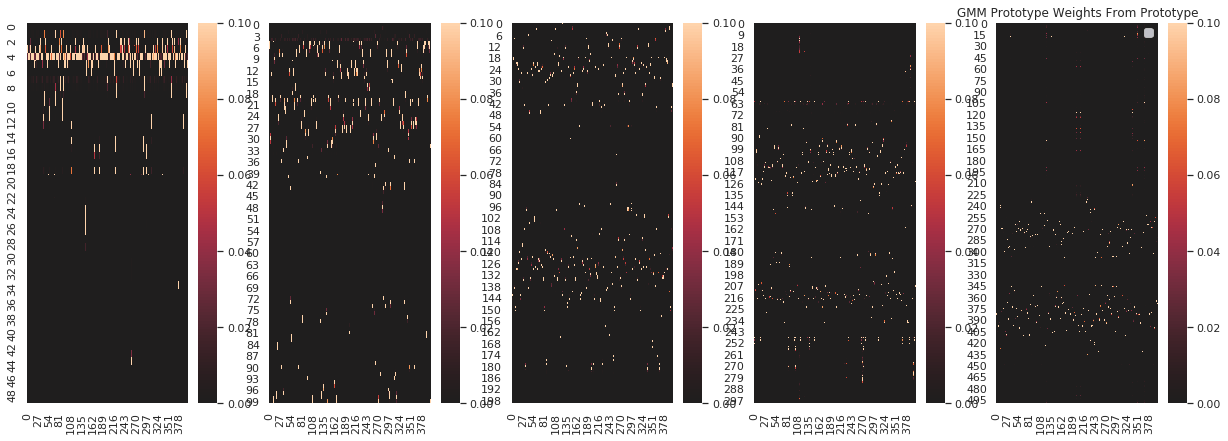

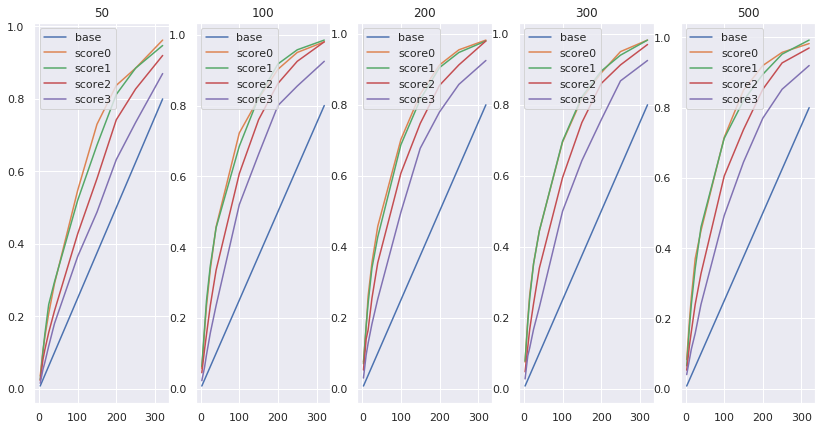

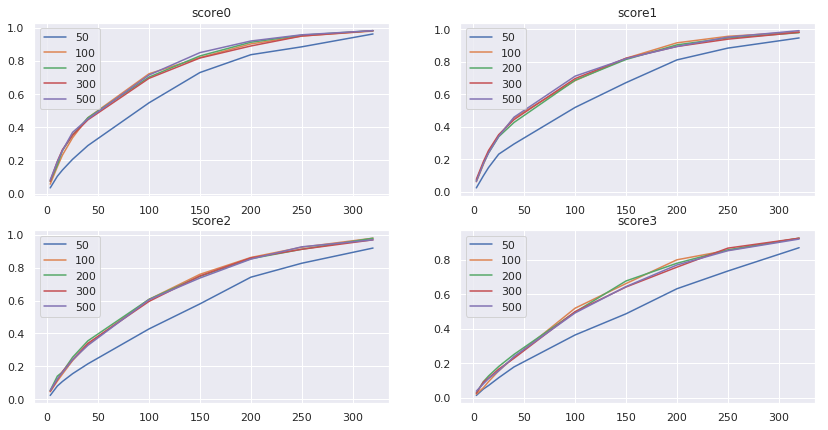

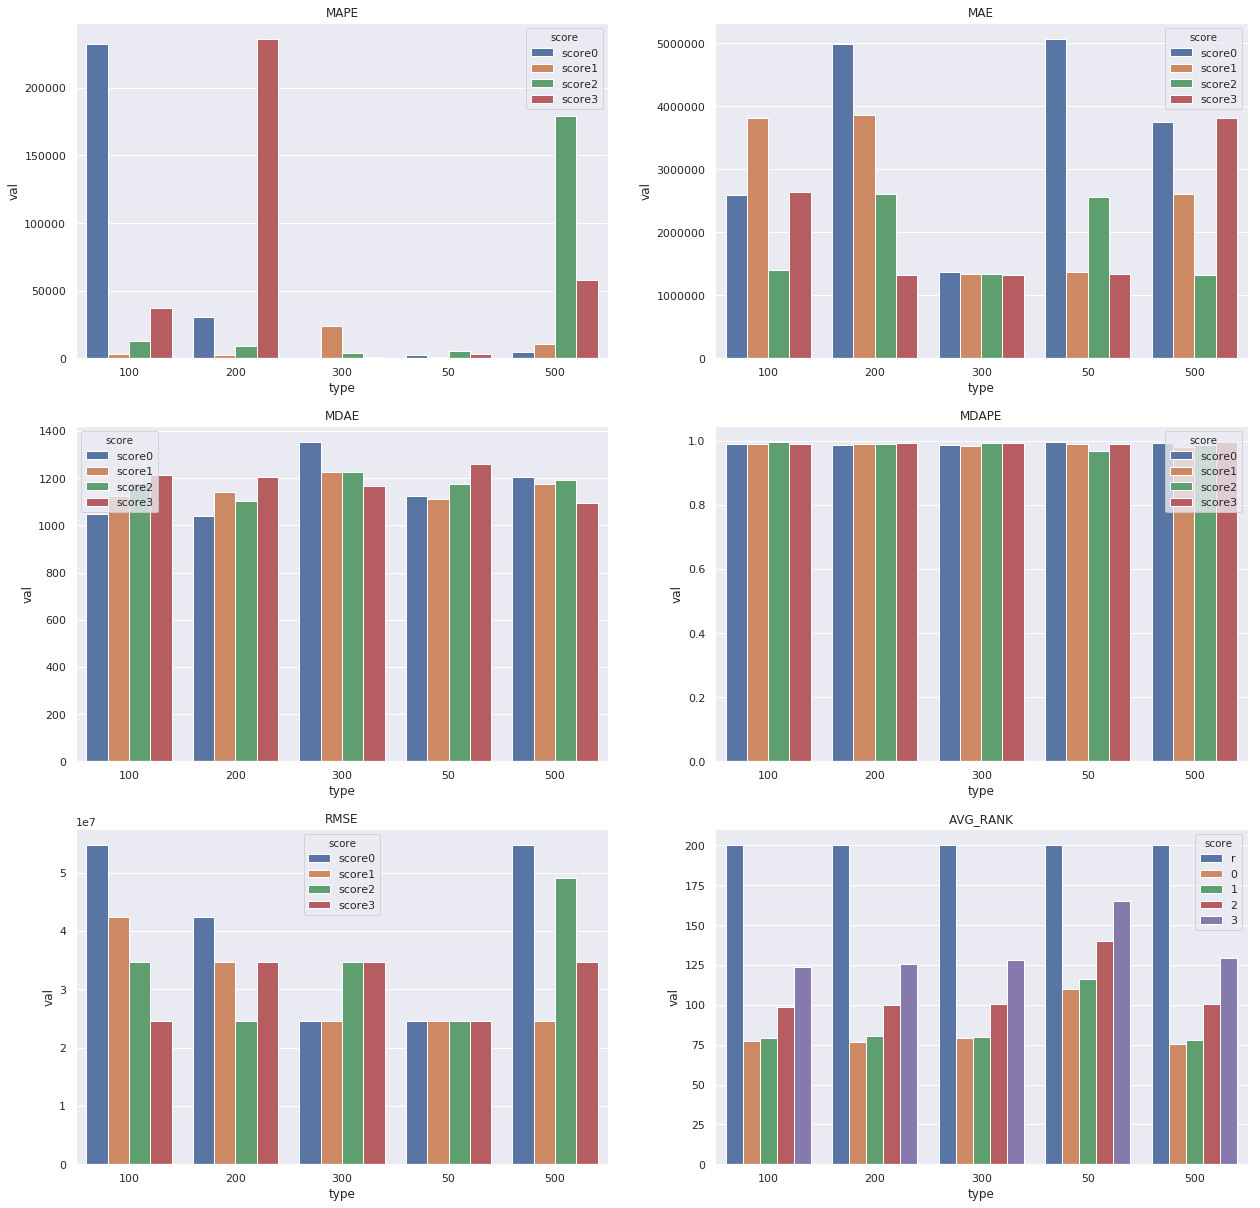

In [367]:
gmms = ['50', '100', '200','300', '500']
res = {}

fig = plt.figure(0)
fig.set_figheight(7)
fig.set_figwidth(21)
count = 1
for gmm_name in gmms:
    numerals = np.array([float(i[0]) for i in filtered_dataset]).reshape(-1,1)
    
    idx2vec_o = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/gmm/{}-fp/idx2vec_o_epoch5.dat'.format(gmm_name),'rb'))
    idx2vec_i = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/gmm/{}-fp/idx2vec_i_epoch5.dat'.format(gmm_name),'rb'))
    trained_prototypes = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/gmm/{}-fp/trained_gmms_epoch5_{}.dat'.format(gmm_name, gmm_name),'rb'))

    mean_vec_o = compute_mean_vec(idx2vec_o)
    mean_vec_i = compute_mean_vec(idx2vec_i)
    
    gmm = pickle.load(open('../../data/wikipedia/preprocess0.05Bnotable/NumeralAsNumeral/gmm/gmm-{}-fp.dat'.format(gmm_name),'rb'))
    prototype_weights = gmm.predict_proba(numerals.reshape(-1,1))
    
    prototypes2vec_i = trained_prototypes['i_embedding']
    prototypes2vec_o = trained_prototypes['o_embedding']
    numeral_embed_i = t.from_numpy(np.matmul(prototype_weights, prototypes2vec_i)) # (93, 150)
    numeral_embed_o = t.from_numpy(np.matmul(prototype_weights, prototypes2vec_o)) # (93, 150)

    plt.subplot(1, len(gmms), count)
    sns.heatmap(prototype_weights.T, vmin=0, vmax=.1, center=0, label=gmm_name)
    norms, _ = compute_norm_factor()
    res[gmm_name] = eval_res('test')
    count += 1

plt.legend('upper left')
plt.title('GMM Prototype Weights From Prototype')    
plt.show()
draw(res)

with open('res_gmm_fp_test.v2.json','w') as f:
    f.write(str(res))

# TEST

In [46]:
filtered_dataset = pickle.load(open('build/data_filtered_0.05Bnotable.test.pkl','rb'))
print(len(filtered_dataset))
print(filtered_dataset[:3])

# filtered_dataset = filter_oov(word2idx, filtered_dataset)
numerals = np.array([float(i[0]) for i in filtered_dataset])
print(len(filtered_dataset))
print(numerals)

419
[('1867.0', ['known', 'as', 'the', 'constitution', 'act', 'but', 'the', 'federal', 'model', 'and']), ('1926.0', ['in', 'the', 'balfour', 'declaration', 'of', 'the', 'british', 'government', 'expressed', 'its']), ('1995.0', ['the', 'narrow', 'federalist', 'victory', 'in', 'reference', 'was', 'made', 'by', 'the'])]
419
[1.867e+03 1.926e+03 1.995e+03 2.004e+03 3.400e+01 2.000e+03 1.100e+03
 1.866e+03 1.880e+03 1.886e+03 2.016e+03 2.006e+03 1.400e+01 1.900e+01
 1.841e+03 5.300e+01 1.200e+00 2.008e+03 1.996e+03 1.600e+01 1.960e+03
 1.400e+03 1.000e+05 2.000e+01 1.941e+03 2.010e+03 1.997e+03 1.968e+03
 5.000e+01 1.000e+01 2.013e+03 1.970e+03 1.988e+03 2.018e+03 1.916e+03
 1.794e+03 1.868e+03 1.920e+03 2.017e+03 1.500e+03 7.500e+01 1.790e+03
 1.958e+03 2.001e+03 1.979e+03 1.991e+03 3.000e+01 2.011e+03 6.000e+01
 2.009e+03 1.927e+03 1.541e+03 1.800e+01 1.847e+03 1.848e+03 7.000e+02
 3.500e+01 1.834e+03 1.871e+03 1.874e+03 1.860e+03 2.000e+04 2.500e+01
 1.896e+03 2.005e+03 2.900e+01 1.030e+

Computing mean vectors, missing 57 vectors
Computing mean vectors, missing 57 vectors
Computing mean vectors, missing 57 vectors
Computing mean vectors, missing 57 vectors
{'200': {'x': [3, 10, 15, 25, 40, 100, 150, 200, 250, 320], 'topk': [[0.007159904534606206, 0.02386634844868735, 0.03579952267303103, 0.059665871121718374, 0.0954653937947494, 0.2386634844868735, 0.35799522673031026, 0.477326968973747, 0.5966587112171837, 0.7637231503579952], [0.06205250596658711, 0.16467780429594273, 0.20047732696897375, 0.3031026252983294, 0.3412887828162291, 0.6062052505966588, 0.747016706443914, 0.8114558472553699, 0.9021479713603818, 0.9284009546539379], [0.050119331742243436, 0.1288782816229117, 0.18377088305489261, 0.23389021479713604, 0.3341288782816229, 0.5727923627684964, 0.7255369928400954, 0.8233890214797136, 0.8758949880668258, 0.9522673031026253], [0.07637231503579953, 0.19331742243436753, 0.24821002386634844, 0.33890214797136037, 0.43675417661097854, 0.6897374701670644, 0.7995226730310

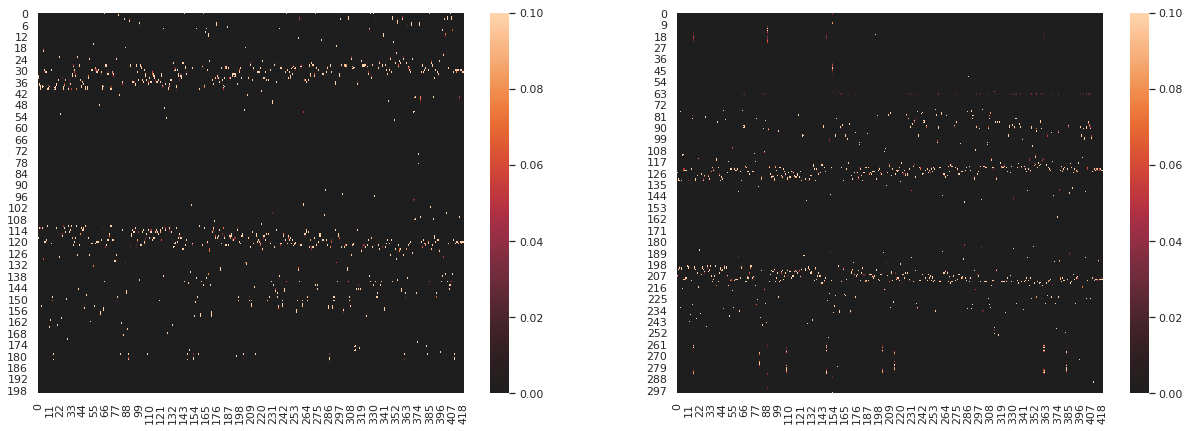

In [49]:
gmms = ['200','300']
res = {}

fig = plt.figure(0)
fig.set_figheight(7)
fig.set_figwidth(21)
count = 1
for gmm_name in gmms:
    numerals = np.array([float(i[0]) for i in filtered_dataset]).reshape(-1,1)
    numeral2idx = {float(numeral):idx for idx, numeral in enumerate(list(nc.keys()))}
    idxs = np.array([numeral2idx[i[0]] for i in numerals])
    
    idx2vec_o = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/gmm/{}-fp/idx2vec_o_epoch5.dat'.format(gmm_name),'rb'))
    idx2vec_i = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/gmm/{}-fp/idx2vec_i_epoch5.dat'.format(gmm_name),'rb'))
    trained_prototypes = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/gmm/{}-fp/trained_gmms_epoch5_{}.dat'.format(gmm_name, gmm_name),'rb'))

    mean_vec_o = compute_mean_vec(idx2vec_o)
    mean_vec_i = compute_mean_vec(idx2vec_i)
    
    gmm = trained_prototypes['gmm_posterior']
    prototype_weights = np.take(gmm, idxs, axis=0)

    prototypes2vec_i = trained_prototypes['i_embedding']
    prototypes2vec_o = trained_prototypes['o_embedding']
    numeral_embed_i = np.matmul(prototype_weights, prototypes2vec_i) # (93, 150)
    numeral_embed_o = np.matmul(prototype_weights, prototypes2vec_o) # (93, 150)

    plt.subplot(1, len(gmms), count)
    sns.heatmap(prototype_weights.T, vmin=0, vmax=.1, center=0, label=gmm_name)
    norms, _ = compute_norm_factor()
    res[gmm_name] = eval_res('test')
    count += 1

# plt.legend('upper left')
# plt.title('GMM Prototype Weights From Prototype')    
# plt.show()
# draw(res)
print(res)
with open('res_gmm_fp_test.json','w') as f:
    f.write(str(res))
    

Computing mean vectors, missing 57 vectors
Computing mean vectors, missing 57 vectors
Computing mean vectors, missing 57 vectors
Computing mean vectors, missing 57 vectors


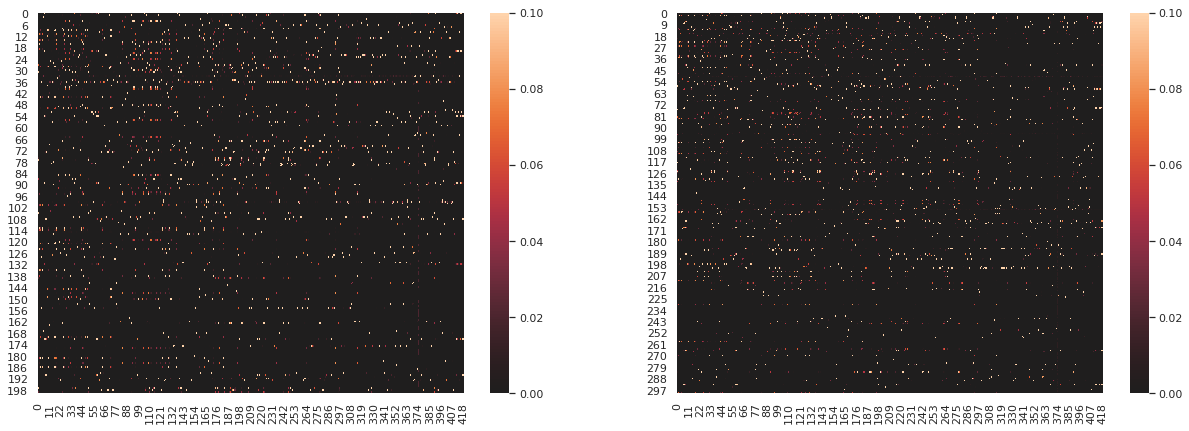

In [50]:
gmms = [ '200', '300']
res = {}

fig = plt.figure(0)
fig.set_figheight(7)
fig.set_figwidth(21)
count = 1
for gmm_name in gmms:
    numerals = np.array([float(i[0]) for i in filtered_dataset]).reshape(-1,1)
    numeral2idx = {float(numeral):idx for idx, numeral in enumerate(list(nc.keys()))}
    idxs = np.array([numeral2idx[i[0]] for i in numerals])
    
    idx2vec_o = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/gmm/{}-rd/idx2vec_o_epoch5.dat'.format(gmm_name),'rb'))
    idx2vec_i = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/gmm/{}-rd/idx2vec_i_epoch5.dat'.format(gmm_name),'rb'))
    trained_prototypes = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/gmm/{}-rd/trained_gmms_epoch5_{}.dat'.format(gmm_name, gmm_name),'rb'))

    mean_vec_o = compute_mean_vec(idx2vec_o)
    mean_vec_i = compute_mean_vec(idx2vec_i)
    
    gmm = trained_prototypes['gmm_posterior']
    prototype_weights = np.take(gmm, idxs, axis=0)

    prototypes2vec_i = trained_prototypes['i_embedding']
    prototypes2vec_o = trained_prototypes['o_embedding']
    numeral_embed_i = np.matmul(prototype_weights, prototypes2vec_i) # (93, 150)
    numeral_embed_o = np.matmul(prototype_weights, prototypes2vec_o) # (93, 150)

    plt.subplot(1, len(gmms), count)
    sns.heatmap(prototype_weights.T, vmin=0, vmax=.1, center=0, label=gmm_name)
    norms, _ = compute_norm_factor()
    res[gmm_name] = eval_res('test')
    count += 1

# plt.legend('upper left')
# plt.title('GMM Prototype Weights')    
# plt.show()
# draw(res)

with open('res_gmm_rd_test.json','w') as f:
    f.write(str(res))

Computing mean vectors, missing 57 vectors
Computing mean vectors, missing 57 vectors
Computing mean vectors, missing 57 vectors
Computing mean vectors, missing 57 vectors


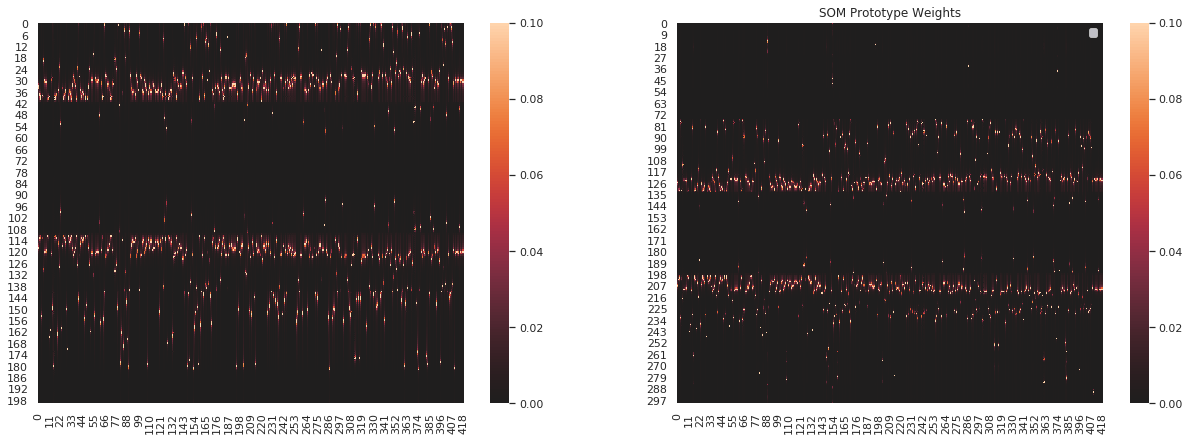

{'200': {'x': [3, 10, 15, 25, 40, 100, 150, 200, 250, 320], 'topk': [[0.007159904534606206, 0.02386634844868735, 0.03579952267303103, 0.059665871121718374, 0.0954653937947494, 0.2386634844868735, 0.35799522673031026, 0.477326968973747, 0.5966587112171837, 0.7637231503579952], [0.05250596658711217, 0.11933174224343675, 0.16945107398568018, 0.2649164677804296, 0.32935560859188545, 0.5775656324582339, 0.7279236276849642, 0.8162291169451074, 0.8902147971360382, 0.9379474940334129], [0.03579952267303103, 0.0954653937947494, 0.1431980906921241, 0.1909307875894988, 0.2911694510739857, 0.5322195704057279, 0.7088305489260143, 0.8114558472553699, 0.8615751789976134, 0.9427207637231504], [0.05489260143198091, 0.1431980906921241, 0.20763723150357996, 0.2744630071599045, 0.4009546539379475, 0.6778042959427207, 0.8042959427207638, 0.8806682577565632, 0.9260143198090692, 0.964200477326969], [0.057279236276849645, 0.15035799522673032, 0.1957040572792363, 0.30071599045346065, 0.4033412887828162, 0.6873

In [51]:
prototype_size = ['200', '300']
res = {}

fig = plt.figure(0)
fig.set_figheight(7)
fig.set_figwidth(21)
count = 1
for sz in prototype_size:
    
    idx2vec_o = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/prototypes/{}/idx2vec_o_epoch5.dat'.format(sz),'rb'))
    idx2vec_i = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/prototypes/{}/idx2vec_i_epoch5.dat'.format(sz),'rb'))
    trained_prototypes = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/prototypes/{}/trained_prototypes_epoch5.dat'.format(sz),'rb'))

    mean_vec_o = compute_mean_vec(idx2vec_o)
    mean_vec_i = compute_mean_vec(idx2vec_i)
    prototypes = trained_prototypes['prototypes']

    prototypes2vec_i = trained_prototypes['i_embedding']
    prototypes2vec_o = trained_prototypes['o_embedding']

    transformed_protp = t.tensor(t.from_numpy(prototypes), dtype=t.float32).apply_(weighted_log).view(-1,1)
    numerals = np.array([float(i[0]) for i in filtered_dataset])
    prototype_weights = get_numeral_embed_weights_batch(t.tensor(t.from_numpy(numerals),dtype=t.float),transformed_protp)
    numeral_embed_i = t.matmul(prototype_weights.transpose(0,1),t.from_numpy(prototypes2vec_i))
    numeral_embed_o = t.matmul(prototype_weights.transpose(0,1),t.from_numpy(prototypes2vec_o))

    plt.subplot(1, len(prototype_size), count)
    sns.heatmap(prototype_weights, vmin=0, vmax=.1, center=0, label=sz)
    norms, _ = compute_norm_factor()
#     norms = compute_norm_factor_1()    
    
    res[sz] = eval_res('test')
    count += 1

plt.legend('upper left')
plt.title('SOM Prototype Weights')    
plt.show()
print(res)
# draw(res)

with open('res_sz_test.json','w') as f:
    f.write(str(res))

In [3]:
filtered_dataset = pickle.load(open('build/data_filtered_1B.val.pkl','rb'))
nc = pickle.load(open('../../data/wikipedia/preprocess1B/NumeralAsNumeral/nc.dat','rb'))
idx2word = pickle.load(open('../../data/wikipedia/preprocess1B/NumeralAsNumeral/idx2word.dat','rb'))
wc = pickle.load(open('../../data/wikipedia/preprocess1B/NumeralAsNumeral/wc.dat','rb'))
word2idx = pickle.load(open('../../data/wikipedia/preprocess1B/NumeralAsNumeral/word2idx.dat','rb'))

wf = np.array([wc[word] for word in idx2word])
w_sum = wf.sum()
wf = wf / w_sum
wf = np.power(wf, 0.75)
wf = wf / wf.sum()
nf = np.array(list(nc.values()))
n_sum = nf.sum()
nf = nf / n_sum

Computing mean vectors, missing 57 vectors
Computing mean vectors, missing 57 vectors


KeyboardInterrupt: 

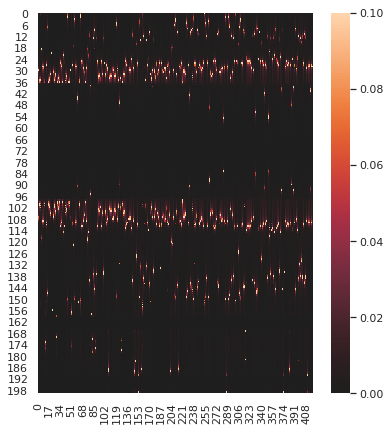

In [42]:
prototype_size = ['2','3','5']
res = {}

fig = plt.figure(0)
fig.set_figheight(7)
fig.set_figwidth(21)
count = 1
for sz in prototype_size:
    
    idx2vec_o = pickle.load(open('../../data/wikipedia/save/1B/prototypes/{}/idx2vec_o_epoch1.dat'.format(sz),'rb'))
    idx2vec_i = pickle.load(open('../../data/wikipedia/save/1B/prototypes/{}/idx2vec_i_epoch1.dat'.format(sz),'rb'))
    trained_prototypes = pickle.load(open('../../data/wikipedia/save/1B/prototypes/{}/trained_prototypes_epoch1_{}00_1.0.dat'.format(sz, sz),'rb'))

    mean_vec_o = compute_mean_vec(idx2vec_o)
    mean_vec_i = compute_mean_vec(idx2vec_i)
    prototypes = trained_prototypes['prototypes']

    prototypes2vec_i = trained_prototypes['i_embedding']
    prototypes2vec_o = trained_prototypes['o_embedding']

    transformed_protp = t.tensor(t.from_numpy(prototypes), dtype=t.float32).apply_(weighted_log).view(-1,1)
    numerals = np.array([float(i[0]) for i in filtered_dataset])
    prototype_weights = get_numeral_embed_weights_batch(t.tensor(t.from_numpy(numerals),dtype=t.float),transformed_protp)
    numeral_embed_i = t.matmul(prototype_weights.transpose(0,1),t.from_numpy(prototypes2vec_i))
    numeral_embed_o = t.matmul(prototype_weights.transpose(0,1),t.from_numpy(prototypes2vec_o))

    plt.subplot(1, len(prototype_size), count)
    sns.heatmap(prototype_weights, vmin=0, vmax=.1, center=0, label=sz)
    norms, _ = compute_norm_factor()
#     norms = compute_norm_factor_1()    
    
    res[sz] = eval_res()
    count += 1

plt.legend('upper left')
plt.title('SOM Prototype Weights')    
plt.show()
print(res)


with open('res_sz.json','w') as f:
    f.write(str(res))


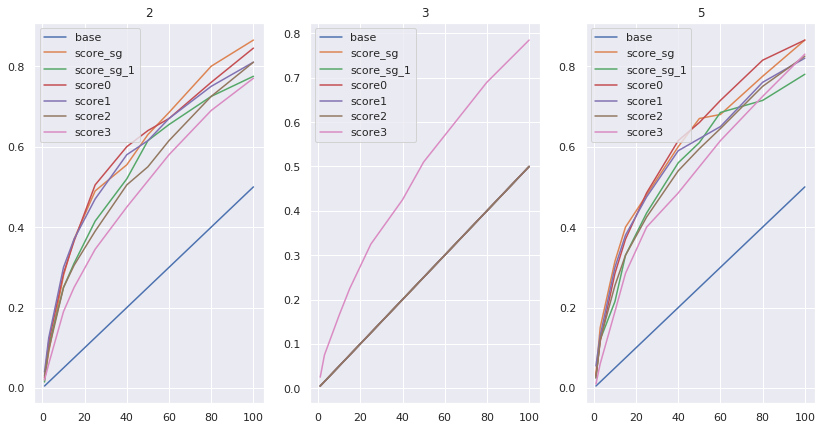

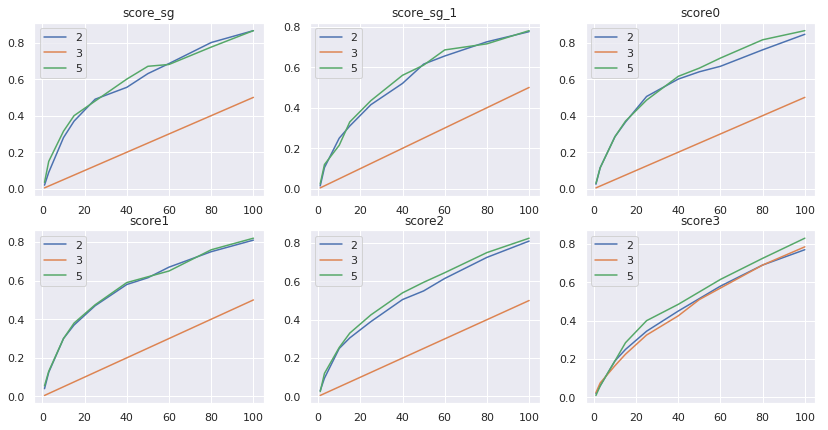

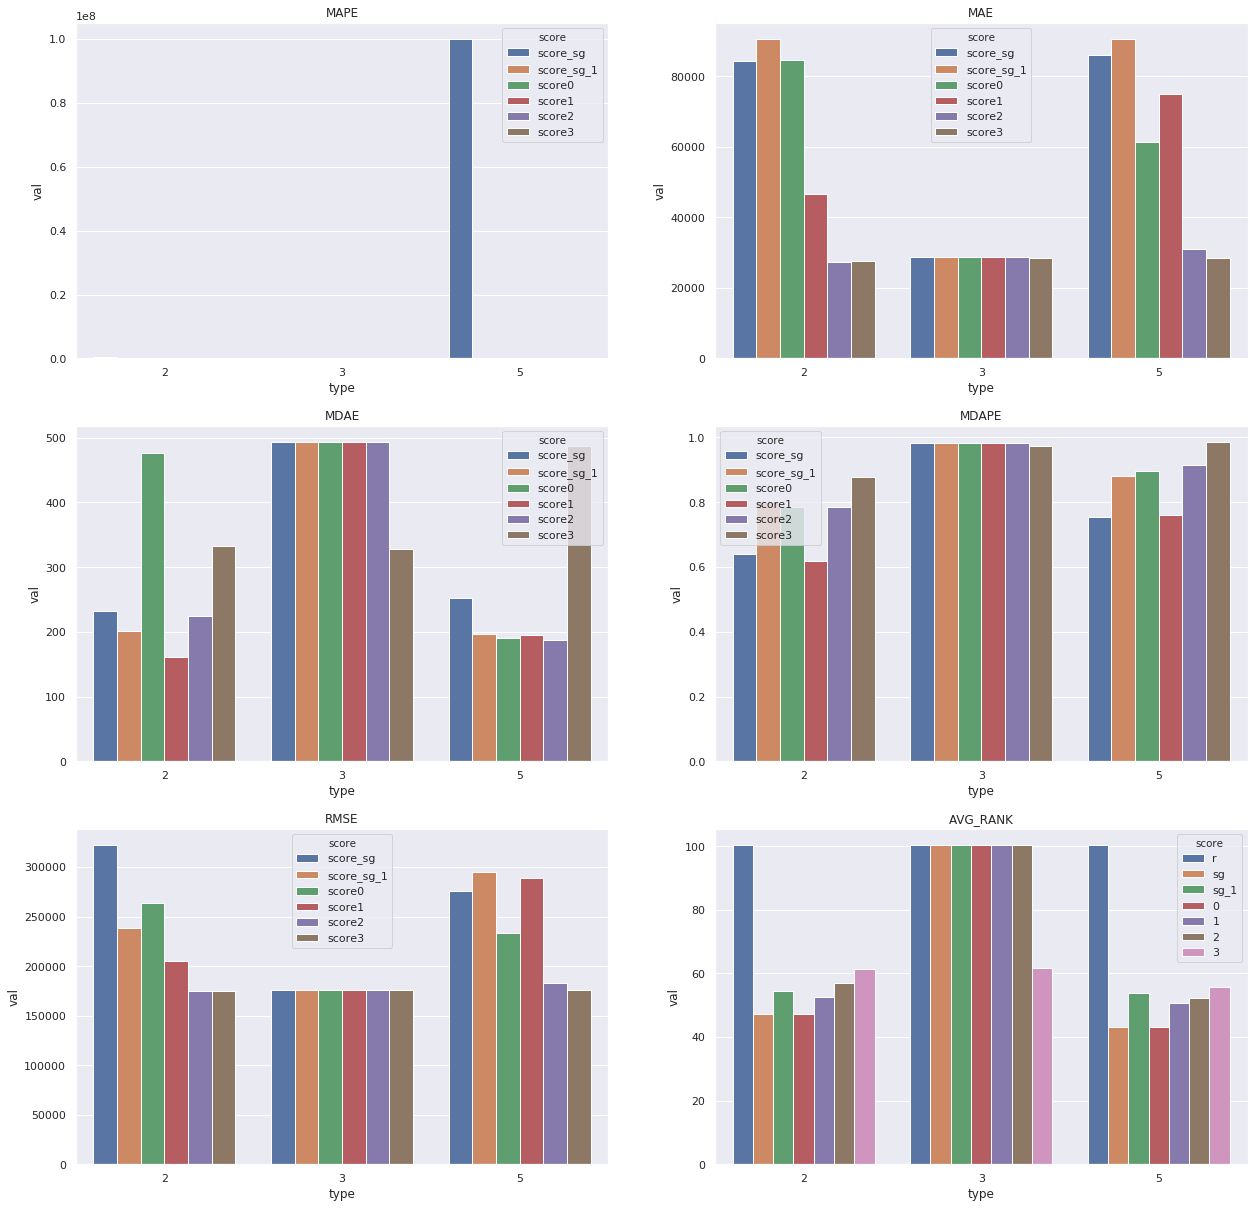

In [12]:
draw(res)

# Baseline NumeralAsUnkToken

In [442]:
filtered_dataset = pickle.load(open('build/data_filtered_0.05Bnotable.test.v2.pkl','rb'))
nc = pickle.load(open('../../data/wikipedia/preprocess0.05Bnotable/NumeralAsTokenUnkNumeral/nc.dat','rb'))
idx2word = pickle.load(open('../../data/wikipedia/preprocess0.05Bnotable/NumeralAsTokenUnkNumeral/idx2word.dat','rb'))
wc = pickle.load(open('../../data/wikipedia/preprocess0.05Bnotable/NumeralAsTokenUnkNumeral/wc.dat','rb'))
word2idx = pickle.load(open('../../data/wikipedia/preprocess0.05Bnotable/NumeralAsTokenUnkNumeral/word2idx.dat','rb'))
print(len(filtered_dataset))
print(filtered_dataset[:3])

# filtered_dataset = filter_oov(word2idx, filtered_dataset)
numerals_str = [i[0] for i in filtered_dataset]
numerals = np.array([float(i[0]) for i in filtered_dataset])



400
[('19.1', ['are', 'the', 'second', 'largest', 'group', 'the', 'next', 'largest', 'group', 'is']), ('896.0', ['were', 'attacking', 'lazio', 'on', 'april', 'formosus', 'died', 'he', 'was', 'succeeded']), ('5.3', ['carrier', 'sc', 'mode', 'up', 'to', 'gbit', 'high', 'speed', 'interface', 'hsi'])]


In [443]:
numeral_embed_i = np.zeros((len(filtered_dataset), 150))
numeral_embed_o = np.zeros((len(filtered_dataset), 150))
idx2vec_o = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/1/NumeralAsTokenUnkNumeral/idx2vec_o_epoch5.dat','rb'))
idx2vec_i = pickle.load(open('../../data/wikipedia/save/0.05Bnotable/1/NumeralAsTokenUnkNumeral/idx2vec_i_epoch5.dat','rb'))

UNK_idxs = []

for i in range(len(numerals_str)):
    try:
        numeral_embed_i[i] = idx2vec_i[word2idx[numerals_str[i]]]
        
    except:
        print('oov:',numerals_str[i])
        UNK_idxs.append(i)
        numeral_embed_i[i] = idx2vec_i[word2idx['<UNK_N>']]

        
for i in range(len(numerals_str)):
    try:
        numeral_embed_o[i] = idx2vec_o[word2idx[numerals_str[i]]]
        
    except:
        print('oov:',numerals_str[i])
        numeral_embed_o[i] = idx2vec_o[word2idx['<UNK_N>']]
        
print(len(UNK_idxs))

oov: 228.6
oov: 9.82
oov: 31395.0
oov: 6852.0
oov: 4760.0
oov: 55.4
oov: 1.0025
oov: 38400.0
oov: 4.57
oov: 242885.0
oov: 634.5
oov: 1022000.0
oov: 30069.0
oov: 46354.0
oov: 6958.0
oov: 182000.0
oov: 2930.0
oov: 3183.0
oov: 101325.0
oov: 0.7179
oov: 8.05
oov: 91.3
oov: 62.3
oov: 282606.0
oov: 3850000.0
oov: 8848.0
oov: 213000.0
oov: 374000.0
oov: 355.5
oov: 166000.0
oov: 72.4
oov: 6338.0
oov: 3.49
oov: 507.5
oov: 220444.0
oov: 5.23
oov: 490000000.0
oov: 264000.0
oov: 11108.0
oov: 4.08
oov: 12970479.0
oov: 1208268.0
oov: 149031.0
oov: 673094.0
oov: 156922.0
oov: 3680.0
oov: 222555.0
oov: 792000.0
oov: 39.48
oov: 6.54
oov: 2639.0
oov: 4250.0
oov: 50171.0
oov: 196670.0
oov: 11.16
oov: 5.54
oov: 0.5538
oov: 0.0028
oov: 0.0537
oov: 53.42
oov: 2.376
oov: 228.6
oov: 9.82
oov: 31395.0
oov: 6852.0
oov: 4760.0
oov: 55.4
oov: 1.0025
oov: 38400.0
oov: 4.57
oov: 242885.0
oov: 634.5
oov: 1022000.0
oov: 30069.0
oov: 46354.0
oov: 6958.0
oov: 182000.0
oov: 2930.0
oov: 3183.0
oov: 101325.0
oov: 0.7179
o

In [444]:
norms, _ = compute_norm_factor()
ressss = {}
for i in range(5):
    res = eval_res('test')
    ressss[i] = res

In [445]:
with open('res_TokenNumeral_test.v2.json','w') as f:
    f.write(str(ressss))

In [446]:
print(ressss)

{0: {'x': [3, 10, 15, 25, 40, 100, 150, 200, 250, 320], 'topk': [[0.0075, 0.025, 0.0375, 0.0625, 0.1, 0.25, 0.375, 0.5, 0.625, 0.8], [0.0975, 0.1825, 0.225, 0.3075, 0.4, 0.675, 0.815, 0.8725, 0.925, 0.9675], [0.0875, 0.17, 0.23, 0.3075, 0.3925, 0.6475, 0.775, 0.87, 0.9275, 0.975], [0.01, 0.0275, 0.0375, 0.0725, 0.105, 0.485, 0.7075, 0.8225, 0.9025, 0.97], [0.005, 0.025, 0.04, 0.065, 0.0975, 0.4125, 0.6, 0.75, 0.865, 0.96]], 'mape': [445.919496083735, 3720.926102049781, 2294251.5304096956, 1318868.9139648445], 'mae': [1299698.6732994998, 1326596.1409445, 6639678.712379751, 12921850.61180675], 'mdae': [346.5, 435.5, 29475.0, 30283.5], 'mdape': [0.7744487261175624, 0.7670552174859123, 17.501366313309774, 17.55116348920295], 'RMSE': [24509649.888547596, 24508998.342663627, 54789614.33942006, 77496090.44376267], 'avg_rank': [200.5, 86.8525, 90.9525, 124.0175, 140.5625]}, 1: {'x': [3, 10, 15, 25, 40, 100, 150, 200, 250, 320], 'topk': [[0.0075, 0.025, 0.0375, 0.0625, 0.1, 0.25, 0.375, 0.5, 0.